<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/procgen_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -qq procgen
# !pip install -qq procgen faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
# @title faiss
import faiss
import numpy as np

# d = 256 # dimension
# res = faiss.StandardGpuResources()  # use a single GPU
# nlist = 100
# m = 8
# index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
# index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
# # index = faiss.IndexIVFPQ(index, d, nlist, m, 8) # each sub-vector is encoded as 8 bits # 3-IVFPQ.py
# # index = faiss.index_cpu_to_gpu(res, 0, index) # 4-GPU.py
# # index = faiss.index_cpu_to_all_gpus(index) # 5-Multiple-GPUs.py


# import torch
# ltmk = torch.rand(1000,d)
# ltmv = torch.rand(1000,d)

def makefaissindex(vert_store):
    d = vert_store.shape[-1]
    nlist = 100
    index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
    index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
    if not index.is_trained: index.train(vert_store)
    index.add(vert_store)
    return index
# index = makefaissindex(ltmk)


def vecsearch(query, index, k=5, treshold=36): # k nearest neighbors
    # index.nprobe = 5 # 1
    D, I = index.search(query, k) # dist, idx
    D, I = D[0], I[0]
    mask = I[D<treshold]
    return mask

# import torch
# query = torch.rand(1,d)

# mask = vecsearch(query, index, k=5, treshold=37)
# print(mask)
# rag = ltmk[mask]
# print(rag)


# removing = torch.tensor([998, 769, 643])
# index.remove_ids(removing)



In [ ]:
# @title mem
import faiss
import pickle
import torch

class Stm():
    def __init__(self): # [batch_size, len_ltm, d_model]
        self.stmk, self.stmv = torch.tensor([], device=device), torch.tensor([], device=device)

    def __call__(self, query): # [batch_size, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, 1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, 1, len_ltm]
        x = attention @ self.stmv
        return x.squeeze(1) # [batch_size, d_model]

    def add(self, k, v): # [batch_size, 1, d_model]
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)


class Mem():
    def __init__(self, batch_size=1):
        self.index = None
        self.ltmk, self.ltmv = torch.tensor([]), torch.tensor([])
        # self.stmk, self.stmv, self.meta = torch.tensor([]), torch.tensor([]), torch.tensor([])
        # self.ltmk, self.ltmv = torch.tensor([], device=device), torch.tensor([], device=device)
        self.stmk, self.stmv, self.meta = torch.tensor([], device=device), torch.tensor([], device=device), torch.tensor([], device=device)
        self.batch_size = batch_size

    def __call__(self, query, a=0.5):
        return a*self.Stm(query) + (1-a)*self.Ltm(query.cpu()).to(device)

    def Stm(self, query): # [1, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query @ self.stmk.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ self.stmv # [1, len_ltm] @ [len_ltm, d_model] = [1, d_model]
        self.meta = self.meta + attn.squeeze(0) # attention # [len_ltm]
        return x # [1, d_model]

    def Ltm(self, query, k=5, treshold=36): # [batch_size, d_model] or [d_model]
        if self.index: rag = self.vecsearch(query, k, treshold)
        else: rag = self.ltmk
        if len(rag)==0: return torch.zeros(1)
        # print("ltm call", query.shape, rag.shape)
        attn = query @ rag.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ rag
        return x # [1, d_model]

    def add(self, k, v): # [batch_size, d_model] or [d_model]
        # print("add", k.shape,self.stmk.shape)
        self.stmk = torch.cat([self.stmk, k], dim=0)
        self.stmv = torch.cat([self.stmv, v], dim=0)
        self.meta = torch.cat([self.meta, torch.ones((1), device=device)], dim=-1)
        if torch.rand(1)<0.1:
            self.pop()
            self.decay()

    def decay(self, g=0.9, k=256): # remove unimportant mem in stm
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        if len(self.meta)>k:
            topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
            self.meta = topk.values # cap stm size
            self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5): # transfer from stm to ltm
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        k, v = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask] # remove from stm
        self.meta = self.meta[~mask]
        # print("pop", k.shape, self.ltmk.shape, k)
        k, v = k.cpu(), v.cpu()
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        self.ltmk = torch.cat([self.ltmk, k], dim=0) # add to ltm
        self.ltmv = torch.cat([self.ltmv, v], dim=0)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.01:
                self.index.train(self.ltmk)
        else:
            if len(self.ltmk)>=100:
                self.index = makefaissindex(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        rag = self.ltmk[mask] # [len_rag, d_model]
        return rag

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(self, file='mem.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta), f)

    def load(self, file='mem.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta = pickle.load(f)


In [1]:
# @title intrinsic cost
# import faiss
import torch
import torch.nn.functional as F

class ICost():
    def __init__(self, d_model, n=100):
        self.recent=[]
        # self.linmul = torch.linspace(0,1/n,n).unsqueeze(-1) # 1/n so that sum to 1
        self.linsx = torch.zeros((n, d_model), device=device)
        self.n = n
        self.p=(n-1)/n

    def boredom(self, lsx, linsx=None): # lsx: [len_seq, d_model]; for simulate only
        if linsx==None: linsx = self.linsx.clone()
        lsx, linsx = F.normalize(lsx, dim=-1), F.normalize(linsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        linsx = linsx[mask]
        bore = (linsx[:-1]@lsx[-1].T).sum()/(self.n-1)
        return bore#.squeeze()

    def update(self, lsx): # lsx: []
        # self.linsx = torch.cat([lsx, self.linsx[:-lsx.shape[0]]], dim=0)
        lsx = F.normalize(lsx, dim=-1)
        len_seq = lsx.shape[0]
        # print("update", self.linsx.shape, lsx.shape)
        linsx = torch.cat([self.linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        self.linsx = linsx[mask]


    # def curiousity(self, sx):
    #     lin= nn.Linear(d_model, 100)#, bias=False)
    #     with torch.no_grad():
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)

    #         n,d=10,2
    #         data=torch.rand(n,d)

    #         index = faiss.IndexFlatIP(d) # IndexFlatL2, IndexFlatIP
    #         index = faiss.IndexIDMap(index)
    #         ids=torch.arange(n)
    #         index.add_with_ids(data,ids)
    #         a=torch.rand(1,2)
    #         id=torch.tensor([0])
    #         index.remove_ids(id) # https://github.com/facebookresearch/faiss/wiki/Faiss-indexes#supported-operations
    #         index.add_with_ids(a,id)

    #         D, I = index.search(a, 20)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         curious = 1-torch.clamp(priority, 0, 1)
    #         D.sum(-1)
    #         curious = 1-torch.clamp(, max=1) # IP


    # def __call__(self, st, a): # [batch_size, d_model]
    def __call__(self, x): # [batch_size, d_model**2]
        return 0

# pain, death, boredom, empathy


In [2]:
# @title conv deconv
import torch
import torch.nn as nn

class Conv(torch.nn.Module):
    def __init__(self, d_model=256, drop=0.5):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] # 1278976
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Dropout(p=drop),
            # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            nn.Linear(4*d_list[4],d_model), nn.ReLU(),
        )
    def forward(self, x): return self.cnn(x)

class Deconv(torch.nn.Module):
    def __init__(self, d_model = 1024):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] # 1278979
        # d_list = [min(d, d_model) for d in d_list]
        self.decoder = nn.Sequential(
            nn.Linear(d_model,4*d_list[4]), nn.ReLU(),
            # nn.Linear(d_list[5],4*d_list[4]), nn.ReLU(),
            nn.Unflatten(-1, (d_list[4],2,2)),
            # nn.Unflatten(-1, (d_list[5],1,1)),
            # nn.ConvTranspose2d(d_list[5], d_list[4], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[4], d_list[3], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[3], d_list[2], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),
        )
    def forward(self, x): return self.decoder(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
conv = Conv().to(device)
print(sum(p.numel() for p in conv.parameters() if p.requires_grad)) # 19683
input = torch.rand((4,3,64,64), device=device)
out = conv(input)
print(out.shape)

deconv = Deconv(256).to(device)
print(sum(p.numel() for p in deconv.parameters() if p.requires_grad)) # 19683
input = torch.rand((4,256), device=device)
out = deconv(input)
print(out.shape)

# print(conv)


1278976
torch.Size([4, 256])
1278979
torch.Size([4, 3, 64, 64])


In [3]:
# @title transfer_sd store_sd load_sd

def transfer_sd(tgt_sd, src_sd): #
    with torch.no_grad():
        for wht_name in tgt_sd.keys():
            if not wht_name in src_sd.keys(): continue
            tgt_wht, src_wht = tgt_sd[wht_name], src_sd[wht_name]
            # print(wht_name, tgt_wht.shape, src_wht.shape)
            if tgt_wht.shape==src_wht.shape:
                tgt_wht.copy_(src_wht)
                continue
            if tgt_wht.shape[0] != src_wht.shape[0]: continue # output dim diff
            if len(tgt_wht.shape)==2: tgt_wht[:, :src_wht.shape[1]].copy_(src_wht[:, :tgt_wht.shape[1]])
    return tgt_sd

def store_sd(all_sd, new_sd): # change input dim of gru
    with torch.no_grad():
        for wht_name in new_sd.keys():
            if not wht_name in all_sd.keys():
                # print(wht_name, new_sd[wht_name].shape)
                all_sd[wht_name] = (new_sd[wht_name],)
                continue
            all_tpl, new_wht = all_sd[wht_name], new_sd[wht_name]
            for all_wht in all_tpl:
                print(wht_name, all_wht.shape, new_wht.shape)
                if all_wht.shape==new_wht.shape:
                    all_wht = new_wht
                    break
                if all_wht.shape[0] != new_wht.shape[0]: continue # diff output shape
                if len(all_wht.shape)==2: all_wht[:, :new_wht.shape[1]] = new_wht[:, :all_wht.shape[1]]
                break
            if len(all_wht.shape)>=2 and len(all_wht.shape)>=2:
                if all_wht.shape[0] != new_wht.shape[0]: all_tpl = all_tpl + (new_wht,) # wht not in all_wht
    return all_sd

def load_sd(tgt_sd, all_sd): # change input dim of gru
    with torch.no_grad():
        for wht_name in tgt_sd.keys():
            if not wht_name in all_sd.keys(): continue
            tgt_wht, all_tpl = tgt_sd[wht_name], all_sd[wht_name]
            for all_wht in all_tpl:
                # try: print(wht_name, tgt_wht.shape, all_wht.shape)
                # except: print(wht_name, tgt_wht, all_wht)
                if tgt_wht.shape==all_wht.shape:
                    tgt_wht.copy_(all_wht)
                    break
                if tgt_wht.shape[0] != all_wht.shape[0]: continue # output dim diff
                if len(tgt_wht.shape)==2: tgt_wht[:, :all_wht.shape[1]].copy_(all_wht[:, :tgt_wht.shape[1]])
                break
    return tgt_sd




# agent = Agent(d_model=256, dim_a=3, dim_z=3, dim_v=512).to(device)

# modelsd = torch.load('agent.pkl', map_location=device).values()
# tgt_sd = transfer_sd(agent.state_dict(), modelsd)
# agent.load_state_dict(tgt_sd, strict=False)



# all_sd = {}
# all_sd = store_sd(all_sd, agent1.state_dict())
# print(all_sd.keys())
# checkpoint = {'model': all_sd}
# torch.save(checkpoint, 'all_sd.pkl')

# agent3 = Agent(d_model=256, dim_a=3, dim_z=1, dim_v=512).to(device)
# agent3.tcost = tcost3
# tgt_sd = load_sd(agent3.state_dict(), all_sd)
# agent3.load_state_dict(tgt_sd, strict=False)

# for x,y in zip(agent1.state_dict().values(), agent3.state_dict().values()):
#     print((x==y).all())

# print(agent1.jepa.enc.cnn[1].num_batches_tracked)
# jepa.enc.cnn.0.weight
# print(agent1.jepa.enc.cnn[0].weight.shape)
# print(agent1.jepa.enc.cnn[0].weight[0][0])
# print(agent3.jepa.enc.cnn[0].weight[0][0])


In [4]:
# @title rename_sd
def rename_sd(agent_sd):
    sd_={}
    convert={}
    na_=''
    for wht_name, wht in agent_sd.items():
        o=wht_name.split('.')
        # print("####", wht_name)
        name=wht_name
        for i in range(len(o)):
            c = o[i]
            if c.isnumeric():
                na, me = '.'.join(o[:i]), '.'.join(o[i+1:])
                c=int(c)
                if na!=na_: # param name diff
                    j=0 # reset num
                    c_=c # track wht_name num
                    na_=na # track param name
                elif c_<c: # same param name, diff num
                    j+=1
                    c_=c
                name = f'{na}.{j}.{me}'
        # print(name)
        sd_[name] = wht
        convert[name] = wht_name
    return sd_, convert


# modelsd, optimsd = torch.load(folder+'agentoptim.pkl', map_location=device).values()
# # modelsd, optimsd = torch.load('agentoptim.pkl', map_location=device).values()
# modelsd, _ = rename_sd(modelsd)

# _, convert = rename_sd(agent.state_dict())
# agentsd = dict((convert[k], v) for (k, v) in modelsd.items())

# modelsd = transfer_sd(agentsd, modelsd)
# agent.load_state_dict(modelsd, strict=False)



In [5]:
# @title transfer_optim me

import torch
import torch.nn as nn


# def transfer_optim(tgt_sd, src_sd, tgt_optim, src_optim): #
def transfer_optim(tgt_sd, src_sd, tgt_optim_sd, src_optim_sd): #
    non_lst = ['running_mean', 'running_var', 'num_batches_tracked', 'num_batches_tracked', 'loss_fn']
    tgt_lst, src_lst = [], []
    for i, (k,v) in enumerate(tgt_sd.items()):
        # print(i, k, v.shape, any(s in k for s in non_lst))
        if not any(s in k for s in non_lst): tgt_lst.append(k)
    for i, (k,v) in enumerate(src_sd.items()):
        if not any(s in k for s in non_lst): src_lst.append(k)

    # tgt_optim_st, src_optim_st = tgt_optim.state_dict()['state'], src_optim.state_dict()['state']
    tgt_optim_st, src_optim_st = tgt_optim_sd['state'], src_optim_sd['state']

    with torch.no_grad():
        for i, wht_name in enumerate(tgt_lst):
            if not wht_name in src_lst: continue
            tgt_wht, src_wht = tgt_optim_st[tgt_lst.index(wht_name)], src_optim_st[src_lst.index(wht_name)]
            # print(wht_name, tgt_wht, src_wht)
            tgt_shp, src_shp = tgt_wht['exp_avg'].shape, src_wht['exp_avg'].shape
            if tgt_shp==src_shp:
                tgt_wht = src_wht
                continue
            if tgt_shp[0] != src_shp[0]: continue # output dim diff
            if len(tgt_shp)==2:
                tgt_wht['step'] = src_wht['step']
                tgt_wht['exp_avg'][:, :src_shp[1]] = src_wht['exp_avg'][:, :tgt_shp[1]]
                tgt_wht['exp_avg_sq'][:, :src_shp[1]] = src_wht['exp_avg_sq'][:, :tgt_shp[1]]
    # return tgt_optim.state_dict()
    return tgt_optim_sd

# model_src = torch.nn.Linear(10, 5)  # Example source model
# model_tgt = torch.nn.Linear(20, 5)  # Example target model (with more input dimensions)

# model_src = nn.Sequential( # trained cost
#     nn.Linear(10, 5, bias=False), nn.Softmax(),
#     )
# d_model=4
# model_tgt = nn.Sequential( # trained cost
#     nn.Linear(20, d_model), nn.ReLU(),
#     nn.Linear(d_model, d_model), nn.ReLU(),
#     nn.Linear(d_model, 5), nn.Softmax(),
#     )

# source_optimizer = optim.AdamW(model_src.parameters())
# target_optimizer = optim.AdamW(model_tgt.parameters())

# dummy_input = torch.randn(3, 10)
# dummy_target = torch.randn(3, 5)
# criterion = torch.nn.MSELoss()
# output = model_src(dummy_input)
# loss = criterion(output, dummy_target)
# loss.backward()
# source_optimizer.step()

# dummy_input = torch.randn(3, 20)
# output = model_tgt(dummy_input)
# loss = criterion(output, dummy_target)
# loss.backward()
# target_optimizer.step()


# print(source_optimizer.state_dict())
# print(target_optimizer.state_dict())

# optimsd = transfer_optim(model_tgt.state_dict(), model_src.state_dict(), target_optimizer, source_optimizer)
# target_optimizer.load_state_dict(optimsd)
# print(target_optimizer.state_dict())



In [21]:
# @title TCost
import torch
import torch.nn as nn

class TCost(nn.Module):
    def __init__(self, in_dim, d_model=256): # in_dim=(1+self.jepa.pred.num_layers)*d_model
        super().__init__()
        self.tc = torch.tensor([-1., 0.], device=device).unsqueeze(-1) # unsqueeze(0).T
        self.tcost = nn.Sequential( # trained cost
            # nn.Dropout(p=0.),
            nn.Linear(in_dim, 2, bias=False), nn.Softmax(dim=-1),
            # nn.Linear(in_dim, d_model), nn.LeakyReLU(),
            # # nn.Dropout(p=0.5),
            # nn.Linear(d_model, d_model), nn.LeakyReLU(),
            # nn.Linear(d_model, 2), nn.Softmax(),
            )
        self.loss_fn = nn.CrossEntropyLoss()

    def update_loss_weight(self, train_data):
        a = len(buffer)/len(train_data.data) # ratio dided/tt steps
        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1/a, 1/(1-a)], device=device))

    def forward(self, x):
        return self.tcost(x)@self.tc

    def loss(self, x, y):
        out = self.tcost(x)
        y = torch.where(y < -0.5, 0, 1)
        return self.loss_fn(out, y)


# tcost=TCost(1024)
# x=torch.rand(256,1024)
# import time
# start = time.time()
# out=tcost(x)
# # out=F.gumbel_softmax(out)
# print(time.time()-start)
# # nn.AdaptiveLogSoftmaxWithLoss(in_features=2, n_classes=2, cutoffs


In [19]:

def train_jepa(self, dataloader, optim, bptt=25): #32
    self.train()
    for batch, (state, action, reward) in enumerate(dataloader): # collate: [seq_len, batch_length], default: [batch_size, seq_len]
        state, action, reward = state.to(device), action.to(device), reward.to(device)
        with torch.cuda.amp.autocast():
            lsy = self.jepa.enc(state.flatten(end_dim=1)) # [batch_size, bptt, d_model]
            # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(lsy.flatten(end_dim=1)))
            # lsy = self.jepa.enc(state) # [batch_size, d_model]
            std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(lsy))
            jloss = self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss
            clossl = self.tcost.loss(lsy, reward.flatten(end_dim=1))
            closs = self.closs_coeff * clossl

            pred = self.tcost(lsy).squeeze(-1).unflatten(0, reward.shape) # [batch_size, bptt]
            print("pred",pred[0])
            print("rwd",reward[0])
            mask = torch.where(abs(reward- pred)>0.5,1,0).bool()
            # # print("rwd, pred, clossl", rwd[mask].data, pred[mask].data, clossl.item())
            # try: imshow(torchvision.utils.make_grid(st[0].cpu(), nrow=10))
            # # try: imshow(torchvision.utils.make_grid(st[mask].cpu(), nrow=10))
            # except ZeroDivisionError: pass

        loss = jloss + closs

        print("std, cov, clossl, wrong", std_loss.item(), cov_loss.item(), clossl.item(), mask.sum().item())
        # print("repr, std, cov, clossl, z, norm", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item(), z_norm.item(), norm)
        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
        scaler.step(optim)
        scaler.update()
        optim.zero_grad()
        try: wandb.log({"std": std_loss.item(), "cov": cov_loss.item(), "closs": clossl.item()})
        except: pass

for i in range(5):
    print(i)
    train_jepa(agent, train_loader, optim)


0


<ipython-input-19-b20720e54f0e>:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


pred tensor([-0.9065, -0.9503, -0.8922, -0.8784, -0.8300, -0.9326, -0.9012, -0.8968,
        -0.8397, -0.8236, -0.6494, -0.9033, -0.8178, -0.1345, -0.0572, -0.0022,
        -0.2381, -0.0379, -0.0400, -0.0525, -0.0721, -0.1442, -0.1354, -0.2275,
        -0.2425, -0.0261, -0.1565, -0.1476, -0.1326, -0.1335, -0.2210, -0.1987,
        -0.2970, -0.1985, -0.2819, -0.1936, -0.5464, -0.0905, -0.3438, -0.3489,
        -0.2093, -0.0594, -0.5009, -0.3977, -0.4156, -0.2535, -0.4324, -0.6285,
        -0.5767, -0.5588], grad_fn=<SelectBackward0>)
rwd tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
std, cov, clossl, wrong 0.18088741600513458 4.019855499267578 0.6002451181411743 1111
pred tensor([-0.7504, -0.2370, -0.4876, -0.5241, -0.3017, -0.5826, -0.4879, -0.4526,
   

KeyboardInterrupt: 

In [7]:
# @title jepa
# https://openreview.net/pdf?id=BZ5a1r-kVsf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
device = "cuda" if torch.cuda.is_available() else "cpu"
# from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class JEPA(nn.Module):
    def __init__(self, in_dim, d_model, dim_a, dim_z, dim_v):
        super(JEPA, self).__init__()
        self.enc = Conv(d_model) # pixel
        # self.enc = ConvEnc(d_model) #
        # self.enc = EfficientNet(inverted_residual_setting, dropout=0.1, last_channel=last_channel, num_classes=256)
        # self.enc.features = efficientnet.Conv2dNormActivation(1, last_channel, kernel_size=3, stride=2, norm_layer=partial(nn.BatchNorm2d, eps=1e-03), activation_layer=nn.SiLU)
        # self.pred = nn.Sequential(
        #     nn.Linear(d_model+dim_a+dim_z, d_model), nn.ReLU(),
        #     nn.Linear(d_model, d_model), nn.ReLU(),
        #     nn.Linear(d_model, d_model), nn.ReLU(),
        #     nn.Linear(d_model, d_model),
        #     )
        self.pred = torch.nn.GRU(d_model+dim_a+dim_z, d_model, num_layers=1, batch_first=True, dropout=0.3)
        self.exp = nn.Sequential(
            nn.Linear(d_model, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v),# nn.ReLU(),
            )
        self.d_model = d_model
        self.dim_z = dim_z
        self.sim_coeff=25. # 10.0 # 25.0 # λ
        self.std_coeff=25. # 1.0 # 25.0 # µ
        self.cov_coeff=1. # 25.0 # 1.0 # ν
        self.z=torch.zeros((1,dim_z),device=device)
        # self.enc_ema = AveragedModel(self.enc, multi_avg_fn=get_ema_multi_avg_fn(0.999))
        # self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    def v_creg(self, x): # vx [batch_size, d_model]
        x = x - x.mean(dim=0)
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_loss = torch.mean(F.relu(1 - std_x)) / 2
        batch_size, num_features = x.shape
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)
        # return self.std_coeff * std_loss, self.cov_coeff * cov_loss
        return std_loss, cov_loss

    def argm(self, sx, a, sy, lr=3e3, h0=None): # 3e3
        batch=sx.size(dim=0)
        z = nn.Parameter(torch.zeros((batch,self.dim_z),device=device))
        optim = torch.optim.SGD([z], lr=lr)
        # optim = torch.optim.AdamW([z], 1e1, (0.9, 0.95))
        lossfn = torch.nn.MSELoss()
        sx, a, sy = sx.detach(), a.detach(), sy.detach()
        for i in range(5): # 10
            sxaz = torch.cat([sx, a, z], dim=-1)
            with torch.amp.autocast('cuda'):
                # sy_ = self.pred(sxaz)
                sy_, _ = self.pred(sxaz, h0)
                loss = lossfn(sy_, sy)# + self.z_coeff * torch.norm(z)
            loss.backward()
            optim.step()
            # scaler.scale(loss).backward()
            # scaler.step(optim)
            # scaler.update()
            optim.zero_grad()
            with torch.no_grad(): z.clamp_(min=-1, max=1)
            # print("argm",i,loss.item(), torch.mean(abs(z.detach())).item())
        if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
        return z#.detach()

# torch.norm(z, dim=-1)
# -(z*torch.log(z)).sum(-1) # Shannon entropy archive.is/CaYrq
# in RL, distribution of action, if certainty is high, entropy is low


    # def loss(self, x, y, a, z=None):
    #     sx, sy = self.enc(x), self.enc(y)
    #     z = self.argm(sx, a, sy)
    #     sxaz = torch.cat([sx, a, z], dim=-1)
    #     sy_ = self.pred(sxaz)
    #     repr_loss = self.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
    #     # v_c_loss = self.v_creg(self.exp(sx))
    #     vx, vy = self.exp(sx), self.exp(sy)
    #     v_c_loss = self.v_creg(vx) + self.v_creg(vy)
    #     return repr_loss + v_c_loss

    # def forward(self, sx, a): # state, ctrl
    #     batch=sx.size(dim=0)
    #     z=torch.zeros((batch,self.dim_z),device=device)
    #     sxaz = torch.cat([sx, a, z], dim=-1)
    #     sy_ = self.pred(sxaz)
    #     return sy_ # state1


# d_model=16
# dim_z= 1#-5
# dim_v=32
# dim_a=4
# model = JEPA(in_dim, d_model, dim_a, dim_z, dim_v).to(device)
# x=torch.rand(1, in_dimx)
# y=torch.rand(1, in_dimy)
# loss = model.loss(x,y)
# distance = torch.norm(embeddings.weight.data - my_sample, dim=-1)
# nearest = torch.argmin(distance)


<ipython-input-7-9b3493e3f0c0>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [8]:
# @title agent gru
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

from matplotlib import pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def ste_argmax(x, temp=1.0):
    x_soft = F.softmax(x / temp, dim=-1)
    x_hard = torch.zeros_like(x)
    x_hard.scatter_(-1, x_soft.argmax(dim=-1, keepdim=True), 1.0)
    x_hard = (x_hard - x_soft).detach() + x_soft
    return x_hard # one hot

class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=8, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        # self.sense = Conv(d_model)
        # self.sense = EfficientNet(inverted_residual_setting, dropout=0.1, last_channel=last_channel, num_classes=256)
        # self.mem = Mem()
        # self.world_state = torch.zeros((d_model, d_model), device=device) # Sum i] vi kiT
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.icost = ICost(d_model) # intrinsic cost
        self.tcost = TCost((1+self.jepa.pred.num_layers)*d_model)
        # self.q = nn.Linear(d_model, d_model, bias=False)
        # self.k = nn.Linear(d_model, d_model, bias=False)
        # self.v = nn.Linear(d_model, d_model, bias=False)
        self.emb = torch.nn.Embedding(15, dim_a, max_norm=1.) # env.action_space # 15
        self.jepa.sim_coeff=50. # 50 # 50 # 10 # λ repr Invariance reconstruction, ->0 slowly
        self.jepa.std_coeff=50. # 50 # 20 # 50 # µ std Variance
        self.jepa.cov_coeff=1. # 1 # 0.001 # 1 # ν cov Covariance
        self.closs_coeff=100. # 100 # 100 # 100
        self.zloss_coeff=10. # 10 # 20 # 1
        self.h0 = torch.zeros((self.jepa.pred.num_layers, 1, d_model), device=device) # [num_layers, batch, d_model]
        self.lx, self.lz = torch.empty((0,dim_a),device=device), torch.empty((0,dim_z),device=device) # [T,dim_az]
        self.sx = self.jepa.enc(torch.zeros((1, 3,64,64)))
        self.la = torch.empty(0,device=device)

    def forward(self, lstate, laction=None, k=1): # live run in env # np (64, 64, 3)
        self.eval()
        if len(self.la)>1 or laction!=None:
            self.update_h0(lstate, laction)
        else:
            with torch.no_grad():
                self.sx = self.jepa.enc(lstate[-1])#.unsqueeze(0)
                # self.icost.update(sx)
        lact, lh0, lx, lz = self.search(self.sx, T=8, h0=self.h0) # [T], [T, num_layers, d_model], [T, dim_a], [T, dim_z]
        act = lact.cpu()[:k].tolist()
        self.la, self.lx, self.lz = lact, lx, lz
        return act

    def update_h0(self, lstate, laction=None): # live run in env # np (64, 64, 3)
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                lsx = self.jepa.enc(torch.cat(lstate, dim=0))
                # self.icost.update(sx)
                out_ = lsx - torch.cat([self.sx, lsx[:-1]], dim=0)
                seq_len = len(lstate)
                if laction!=None:
                    self.la = torch.cat([torch.tensor(laction, device=device), self.la[len(laction):]], dim=-1)
                la = self.emb(self.la[:seq_len])

        lz = nn.Parameter(torch.zeros((seq_len, self.dim_z),device=device))
        torch.nn.init.normal_(lz, mean=0., std=.3/lz.shape[-1]**0.5) # torch.nn.init.xavier_normal_(lz) # xavier_normal_ xavier_uniform_
        optim_z = torch.optim.SGD([lz], lr=1e1) # 3e3
        # optim_z = torch.optim.AdamW([lz], 1e-1, (0.9, 0.999)) # 1e0 ; 3e-2 1e-1
        lsx, la = lsx.detach(), la.detach() # [T, d_model], [T, dim_a]
        # print("update_h0 lz", lz.data)
        self.jepa.pred.train()
        for i in range(1): # 1?
            sxaz = torch.cat([lsx, la, lz], dim=-1).unsqueeze(0) # [1, seq_len, d_model+dim_a+dim_z]
            with torch.cuda.amp.autocast(): # with torch.amp.autocast('cuda'):
                out, h0 = self.jepa.pred(sxaz, self.h0.detach()) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                loss = F.mse_loss(out_, out.squeeze(0))
            loss.backward()
            optim_z.step()
            optim_z.zero_grad()
            # print("update_h0 loss, lz",i,loss.item(), lz.data)
            with torch.no_grad(): lz /= torch.norm(lz, dim=-1).unsqueeze(-1).clamp_(min=1)
        self.h0 = h0
        self.sx = lsx[-1].unsqueeze(0)
        # print("update_h0", self.lx.data)
        # print(self.la.shape, self.lx.shape, self.lz.shape, self.la[seq_len:].shape, self.lx[seq_len:].shape, self.lz[seq_len:].shape)
        self.la, self.lx, self.lz = self.la[seq_len:], self.lx[seq_len:], self.lz[seq_len:] # [T, dim_a], [T, dim_z]
        return h0

    def argm_s(self, sx, x, h0): # batch argm z for search
        T, _ = x.shape
        batch = 64 # 16
        z = nn.Parameter(torch.zeros((batch, T, self.dim_z),device=device))
        torch.nn.init.normal_(z, mean=0., std=1./z.shape[-1]**0.5) # norm ~1
        optim_z = torch.optim.SGD([z], lr=1e4, maximize=True) # 3e3
        # optim_z = torch.optim.AdamW([z], 1e-2, (0.9, 0.999), maximize=True) # ? 1e0 ; 3e-2 1e-1
        # optim_z = torch.optim.AdamW([z], 1e-0, (0.9, 0.95), maximize=True) # ? 1e0 ; 3e-2 1e-1
        with torch.no_grad():
            z[:,:self.lz.shape[0]] = self.lz[:T].unsqueeze(0).repeat(batch,1,1) # [batch, seq_len, dim_z]
        sx, h0 = sx.detach(), h0.detach()
        x = x.detach().repeat(batch,1,1) # [batch, seq_len, dim_a]
        # print("argm", z[0].squeeze())
        for i in range(2): # 5
            loss, lh0 = self.rnn_pred(sx, x, z, h0) # snap x to act emb
            loss.sum().backward()
            optim_z.step()
            optim_z.zero_grad()
            with torch.no_grad():
                z /= torch.norm(z, dim=-1).unsqueeze(-1).clamp_(min=1) # z.clamp_(min=-1, max=1)
            # print(i, "argm z loss", z[0].squeeze().data, loss[0].squeeze().data)
        idx = torch.argmin(loss) # choose best x even with greatest adv z
        return z[idx]

    def search(self, sx, T=6, h0=None):
        x = nn.Parameter(torch.empty((T, self.dim_a),device=device))
        torch.nn.init.normal_(x, mean=0., std=.3/x.shape[-1]**0.5)
        optim_x = torch.optim.SGD([x], lr=1e3) # 1e-1,1e-0,1e4 ; 1e2
        # optim_x = torch.optim.AdamW([x], 1e1, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2
        # optim_x = torch.optim.AdamW([x], 1e1, (0.9, 0.95)) # 1e-1 ; 1e-2 3e-2
        with torch.no_grad(): x[:self.lx.shape[0]] = self.lx[:T] # [seq_len, dim_az]
        sx, h0 = sx.detach(), h0.detach()
        # print("search x",x.squeeze().data)
        for i in range(2): # 5
            dist = torch.norm(self.emb.weight.data.unsqueeze(0) - x.unsqueeze(-2), dim=-1) # [1,act_space,emb_dim], [T,1,emb_dim] -> [T,act_space]
            x_ = ste_argmax(-dist) @ self.emb.weight.data # [T, dim_a]
            z = self.argm_s(sx, x_,h0) # [T, dim_z]
            loss, lh0 = self.rnn_pred(sx, x_.unsqueeze(0), z.unsqueeze(0), h0) # snap x to act emb
            loss.sum().backward()
            optim_x.step()
            optim_x.zero_grad()
            # print(i, "search x loss", x.squeeze().data, loss.squeeze().item())
            with torch.no_grad():
                x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1)
        dist = torch.norm(self.emb.weight.data.unsqueeze(0) - x.unsqueeze(-2), dim=-1) # [1,act_space,emb_dim], [T,1,emb_dim] -> [T,act_space]
        lact = torch.argmin(dist, dim=-1) # [T]
        return lact, lh0, x.data, z # [T], [T, num_layers, batch, d_model], [T, dim_a], [T, dim_z]

    def rnn_pred(self, sx, la, lz=None, h0=None, gamma=0.9): # 0.95 [1, d_model], [batch, seq_len, dim_a/z], [num_layers, d_model]
        self.jepa.pred.train()
        batch, seq_len, _ = la.shape
        sx=sx.repeat(batch, 1) # [batch, d_model]
        h0=h0.repeat(1, batch, 1) # [num_layers, batch, d_model]
        lsx = torch.empty((batch, 0, self.d_model), device=device) # [batch_size, T, d_model]
        lh0 = torch.empty((0,)+h0.shape, device=device)
        for t in range(seq_len):
            a, z = la[:,t], lz[:,t] # [1, dim_a], [1, dim_z]
            sxaz = torch.cat([sx, a, z], dim=-1).unsqueeze(1) # [batch, 1, d_model+dim_a/z]
            with torch.amp.autocast('cuda'):
                out, h0 = self.jepa.pred(sxaz, h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                sx = sx + out.squeeze(1) # [batch,seq_len,d_model]
            lsx = torch.cat([lsx, sx.unsqueeze(1)], dim=1) # [batch, T, d_model]
            lh0 = torch.cat([lh0, h0.unsqueeze(0)], dim=0) # [seq_len, num_layers, batch, d_model]
        icost = 0#*0.0005*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
        syh0 = torch.cat([lsx, lh0.permute(2,0,1,3).flatten(2)], dim=-1).flatten(end_dim=1) # [batch_size,T,d_model], [T,num_layers,batch_size,d_model] -> [batch_size*bptt, (1+num_layers)*d_model]
        tcost = -self.tcost(syh0).unflatten(0, (batch, seq_len)).squeeze(-1)
        c = (tcost + icost)*gamma**torch.arange(seq_len, device=device)
        # if len(c.shape) == 1: print("rnn_pred c", [f'{cc.item():g}' for cc in c.squeeze(0)]) # print(f'{cc:6f}')
        if len(tcost.shape) == 1: print("rnn_pred tcost", [f'{cc.item():g}' for cc in tcost.squeeze(0)]) # print(f'{cc:6f}')
        return c.sum(), lh0


    # def get(self, state, _mem=None, world_state=None): # update world_state and mem from state
    #     # if _mem==None: _mem = self.mem
    #     if world_state==None: world_state = self.world_state
    #     current = self.sense(state) # [batch_size, d_model] or [1, d_model]
    #     Q = self.q(current) # [batch_size, d_model]
    #     # mem = _mem(Q) # _mem(current)
    #     obs = current# + mem # [batch_size, d_model]
    #     K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
    #     # self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))
    #     # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
    #     K = F.normalize(K, dim=-1)
    #     if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
    #     V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
    #     world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
    #     # _mem.add(K, V) # [batch_size, 1, d_model] or [1, d_model]
    #     return _mem, world_state#, cost


    def argm(self, lsy, sy, h0, la, rwd):
        self.tcost.eval()
        batch_size, bptt, _ = lsy.shape # [batch_size, bptt, d_model]
        lz = nn.Parameter(torch.zeros((batch_size, bptt, self.dim_z), device=device))
        torch.nn.init.normal_(lz, mean=0., std=.3/lz.shape[-1]**0.5)
        # optim = torch.optim.SGD([lz], lr=1e-2) # 1e-2
        # optim = torch.optim.AdamW([lz], 1e-1, (0.9, 0.95)) # 1e-1
        optim = torch.optim.AdamW([lz], 1e-1, (0.9, 0.999)) # 1e-1
        lsy, la, rwd = lsy.detach(), la.detach(), rwd.detach()
        for i in range(3): # 10
            sy_, h0_ = sy.detach(), h0.detach()
            lh0 = torch.empty((0,)+h0.shape, device=device)
            lsy_ = torch.empty((batch_size, 0, self.d_model), device=device) # [batch_size, T, d_model]
            with torch.cuda.amp.autocast():
                for i, (a, z) in enumerate(zip(la.permute(1,0,2), lz.permute(1,0,2))):
                    syaz = torch.cat([sy_.squeeze(1), a, z], dim=-1) # [batch_size, 1, d_model], [batch_size, dim_az]
                    out_, h0_ = self.jepa.pred(syaz.unsqueeze(1), h0_) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                    sy_ = sy_ + out_[:, -1, :].unsqueeze(1)
                    lsy_ = torch.cat((lsy_, sy_), dim=1)
                    lh0 = torch.cat((lh0, h0_.unsqueeze(0)), dim=0)
                repr_loss = F.mse_loss(lsy, lsy_)
                syh0 = torch.cat([lsy_, lh0.permute(2,0,1,3).flatten(2)], dim=-1).flatten(end_dim=1) # [batch_size,bptt,d_model], [bptt,num_layers,batch_size,d_model] -> [batch_size*bptt, (1+num_layers)*d_model]
                clossl = self.tcost.loss(syh0, rwd.flatten())
                z_loss = torch.abs(lz).sum() # z_loss = torch.norm(z)
                # print("z_loss", i, z[0].data, z_loss)
                cost = self.jepa.sim_coeff * repr_loss + self.closs_coeff * clossl + self.zloss_coeff * z_loss
            cost.backward()
            optim.step()
            optim.zero_grad()
            with torch.no_grad(): lz /= torch.norm(lz, dim=-1).unsqueeze(-1).clamp_(min=1)
            # print(i, "repr c z loss, z", torch.cat([torch.tensor([repr_loss, clossl, z_loss]), z[0].cpu()],dim=-1).squeeze().data)
        self.tcost.train() # https://pytorch.org/docs/stable/_modules/torch/autograd/grad_mode.html#no_grad # https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.eval
        return lz.detach()


    def train_jepa(self, dataloader, optim, bptt=25): #32
        self.train()
        for batch, (state, action, reward) in enumerate(dataloader): # collate: [seq_len, batch_length], default: [batch_size, seq_len]
            h0 = torch.zeros((self.jepa.pred.num_layers, batch_size, self.d_model), device=device) # [num_layers, batch, d_model]
            sy_ = self.jepa.enc(torch.zeros((batch_size, 3,64,64), device=device)).unsqueeze(1) # [batch_size, 1, d_model]
            # sx=sy_
            state, action, reward = state.to(device), action.to(device), reward.to(device)

            for st, act, rwd in zip(torch.split(state, bptt, dim=1), torch.split(action, bptt, dim=1), torch.split(reward, bptt, dim=1)):
                lh0 = torch.empty((0,)+h0.shape, device=device)
                lsy_ = torch.empty((batch_size, 0, self.d_model), device=device) # [batch_size, T, d_model]

                with torch.cuda.amp.autocast():
                    lsy = self.jepa.enc(st.flatten(end_dim=1)).unflatten(0, (batch_size, -1)) # [batch_size, bptt, d_model]
                    la = self.emb(act) # [batch_size, bptt, dim_a]
                    lz = self.argm(lsy, sy_, h0, la, rwd) # [batch_size, bptt, d_model],
                    # with torch.no_grad(): lz.mul_(torch.rand_like(lz)).mul_((torch.rand_like(lz)>0.5).bool()) # dropout without scailing

                    for i, (a, z) in enumerate(zip(la.permute(1,0,2), lz.permute(1,0,2))):
                        syaz = torch.cat([sy_.squeeze(1), a, z], dim=-1) # [batch_size, 1, d_model], [batch_size, dim_az]
                        out_, h0 = self.jepa.pred(syaz.unsqueeze(1), h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                        # sy_ = sy_ + out_[:, -1, :].unsqueeze(1)
                        sy_ = out_[:, -1, :].unsqueeze(1)
                        lsy_ = torch.cat((lsy_, sy_), dim=1)
                        lh0 = torch.cat((lh0, h0.unsqueeze(0)), dim=0)

                    repr_loss = F.mse_loss(lsy, lsy_) # [batch_size, bptt, d_model]
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(lsy.flatten(end_dim=1)))
                    jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss

                    syh0 = torch.cat([lsy, lh0.permute(2,0,1,3).flatten(2)], dim=-1).flatten(end_dim=1) # [batch_size,bptt,d_model], [bptt,num_layers,batch_size,d_model] -> [batch_size*bptt, (1+num_layers)*d_model] # not lsy_, else unstable
                    clossl = self.tcost.loss(syh0, rwd.flatten())
                    closs = self.closs_coeff * clossl

                    pred = self.tcost(syh0).squeeze(-1).unflatten(0, rwd.shape) # [batch_size, bptt]
                    print("pred",pred[0])
                    print("rwd",rwd[0])
                    mask = torch.where(abs(rwd- pred)>0.5,1,0).bool()
                    # # print("rwd, pred, clossl", rwd[mask].data, pred[mask].data, clossl.item())
                    # try: imshow(torchvision.utils.make_grid(st[0].cpu(), nrow=10))
                    # # try: imshow(torchvision.utils.make_grid(st[mask].cpu(), nrow=10))
                    # except ZeroDivisionError: pass

                loss = jloss + closs

                # print("norm", torch.norm(sy, dim=-1)[0].item())
                # norm = torch.norm(lsy, dim=-1)[0][0].item()
                # z_norm = torch.norm(z)
                # print("repr, std, cov, clossl", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item())
                # print("clossl, wrong", clossl.item(), mask.sum())
                print("repr, std, cov, clossl, wrong", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item(), mask.sum().item())
                # print("repr, std, cov, clossl, z, norm", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item(), z_norm.item(), norm)
                scaler.scale(loss).backward()
                # torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                scaler.step(optim)
                scaler.update()
                optim.zero_grad()
                sy_, h0 = sy_.detach(), h0.detach()
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": clossl.item()})
                except: pass


agent = Agent(d_model=256).to(device)
# agent = torch.compile(Agent(d_model=256), mode='max-autotune').to(device)

optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.999)) # lr = 1e-4 #3e-4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4
# !pip show torch triton
# # !pip install --upgrade torch
# !pip install --upgrade triton

# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 1lyr:2727982, 2lyr:4401710
# print(sum(p.numel() for p in agent.jepa.enc.parameters() if p.requires_grad)) # 1278976
# print(sum(p.numel() for p in agent.jepa.pred.parameters() if p.requires_grad)) # 1lyr:397824, 2lyr:792576
# print(sum(p.numel() for p in agent.tcost.parameters() if p.requires_grad)) # 197633


<ipython-input-8-2f08d6d8256a>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# print(agent.tcost._parameters['weight'].shape)


In [ ]:
# print(agent.jepa.enc.parameters().values()[0].requires_grad)
# for name, param in agent.tcost.named_parameters():
# # # for name, param in agent.named_parameters():
# #     # print(name, param.requires_grad)
#     print(name, param)

for name, param in agent.tcost.named_parameters(): print(param.data)

# print(agent.tcost.1.weight.data)

# print(agent.tcost.named_parameters()['tcost.1.weight'])

# print(vars(agent.jepa.exp.named_parameters()['exp.1.weight']))

tensor([[ 0.0229, -0.0159, -0.0247,  ...,  0.0336,  0.0319, -0.0009],
        [-0.0306, -0.0346, -0.0081,  ..., -0.0064,  0.0082,  0.0179]],
       device='cuda:0')


In [ ]:

# dim_a, dim_z = 3, 8
# batch, T = 4,6
# x = nn.Parameter(torch.empty((batch, T, dim_a),device=device))
# torch.nn.init.normal_(x, mean=0., std=.3/x.shape[-1]**0.5)
# dist = torch.norm(agent.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
# x = ste_argmax(-dist) @ agent.emb.weight.data
# z = nn.Parameter(torch.zeros((batch, T, dim_z),device=device))
# torch.nn.init.normal_(z, mean=0., std=1./z.shape[-1]**0.5) # norm ~1
# state = torch.zeros((1, 3,64,64))
# # state = torch.rand((1, 3,64,64), device=device)
# sx = agent.jepa.enc(state)

act = agent([state], k=4)
# h0 = torch.zeros((agent.jepa.pred.num_layers, 1, agent.d_model), device=device) # [num_layers, batch, d_model]
# lact, lh0, lx, lz = agent.search(sx, T=6, h0=h0)
# loss, lsx, lh0,c = agent.rnn_pred(sx, x, z, h0) # snap x to act emb
# print(loss,c)
# print(lact, lh0, lx, lz)


NameError: name 'state' is not defined

In [9]:
# !gdown 1bGWBbcKUgHESkbD3NfYt1WWikScVSFOj -O agentoptim.pkl # M1 gru3 tcost1
# !gdown 1XBDhD2efIFW9lnewGRLrb362w47a8b1q -O agentoptim.pkl # B2 gru3 tcost1
# !gdown 12Ez0fE8QtJ8b35zeuZQp85mrbHbWvhA_ -O agentoptim.pkl # S3
# !gdown 1zoZ52jctM0jed6TgD7kAwrtnuDMeA5II -O agentoptim.pkl # T4 gru1 tcost1 drop
# !gdown 1GlZxrzdH5f28Qo4olbOi0vmAK5WDV7jc -O agentoptim.pkl # A2
# !gdown 1UDgNtFsWGAhvqR9lwA0QbMLhUtmip4ne -O agentoptim.pkl # M1 agentoptimgru3tcost1
# !gdown 1-0oc6yucS5JXLHX1zqbYe3NTVMuhP_5r -O agentoptim.pkl # A2 agentoptim25251c25z3
# !gdown 1U1CuCU1FugkrzPXsvTPpIX-wzWz6szl2 -O agentoptim.pkl # T4 agentoptimargm
# !gdown 1CWZAtiEwSnglClJbq2LJTYlKhPN10gfo -O agentoptim.pkl # S3 agentoptimargm
# !gdown 1XAbr6l1pCmcUCKR6kYlQ_dSDsOBqRg_j -O agentoptim.pkl # B2 argm2search2
# !gdown 1UkQuf-IC2LYErSapkF6rZM1dv3svGI5P -O agentoptim.pkl # T4 gru3 argm offline
# !gdown 1-4sNf6mINCiD5YsBdQvCrlyqzzfS64si -O agentoptim.pkl # T4 gru3 argm offline
# !gdown 1MV9Qj_53Vu6wpe7nOFn47M5vDj7F7-gv -O agentoptim.pkl # S3 agentoptimargm2
# !gdown 1--1Vl3337zugQng-j1qbptFY8EvhZA-T -O agentoptim.pkl # T4 agentoptimargm3 online
# !gdown 1XHFBVPSH4T4FpUOBKN8X20xDQLNmL7go -O agentoptim.pkl # M1 agentoptimargm4
# !gdown 1fFXsee_cSZxhTRewD7ZkGT68NXeq8OcH -O agentoptim.pkl # B2 agentoptimargm4

# !gdown 1sCW9uvcdCJkCH5HQDdISLws5rMvmkmFR -O all_sd.pkl # M1 all_sd

import pickle
# !gdown 1j9hOq8_752duPB0PMYUJqabNvYoGLysX -O buffer512down.pkl # S
# with open('buffer512down.pkl', 'rb') as f: buffer = pickle.load(f)
# !gdown 1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY -O buffer512.pkl # S
# with open('buffer512.pkl', 'rb') as f: buffer = pickle.load(f)
# !gdown 1tzlp_Yc_70XSFy2yiCliLd6Jlt1X78lB -O buffergo.pkl # S3
# !gdown 1egXy0t_kn0M0oL6sbwixoVr7bqMfcB8j -O buffergo.pkl # T4
# !gdown 1-34fhOMTdMvtuAeHuL28Y4taSINvOejQ -O buffergo.pkl # B2
with open('buffergo.pkl', 'rb') as f: buffer = pickle.load(f)

In [11]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'
import pickle

# with open(folder+'buffergo.pkl', 'rb') as f: buffer = pickle.load(f)
# with open('buffergo.pkl', 'rb') as f: buffer = pickle.load(f)


# modelsd, optimsd = torch.load(folder+'agentoptim.pkl', map_location=device).values()
# modelsd, optimsd = torch.load(folder+'agentoptimargm4.pkl', map_location=device).values()
modelsd, optimsd = torch.load('agentoptim.pkl', map_location=device).values()
# _, convert = rename_sd(agent.state_dict())
# agentsd = dict((convert[k], v) for (k, v) in modelsd.items())
# modelsd = transfer_sd(agentsd, modelsd)
# modelsd = transfer_sd(agent.state_dict(), modelsd)
agent.load_state_dict(modelsd, strict=False)
# # optimsd = transfer_optim(agent.state_dict(), modelsd, optim.state_dict(), optimsd)
optim.load_state_dict(optimsd)



# all_sd = torch.load(folder+'all_sd.pkl', map_location=device)
# # all_sd = torch.load('all_sd.pkl', map_location=device)
# _, convert = rename_sd(agent.state_dict())
# # agentsd = dict((convert[k], v) for (k, v) in all_sd.items())
# allsd = {}
# for (k, v) in all_sd.items():
#     try: allsd[convert[k]] = v
#     except Exception as e: print('dict err', e)
# # agentsd = dict((convert[k], v) for (k, v) in modelsd.items())
# tgt_sd = load_sd(agent.state_dict(), allsd)
# agent.load_state_dict(tgt_sd, strict=False)



# for i, (k,v) in enumerate(modelsd.items()):
# for i, (k,v) in enumerate(agent.state_dict().items()):
#     print(i,k,v.shape)


Mounted at /content/drive


In [31]:
# buffer = [episode for episode in buffer if episode[-1][2]==-1]
# with open(folder+'buffergo.pkl', 'wb') as f: pickle.dump((buffer), f)

# agentsd, _ = rename_sd(agent.state_dict())
# checkpoint = {'model': agentsd, 'optimizer': optim.state_dict(),}
checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
# torch.save(checkpoint, folder+'agentoptim.pkl')
torch.save(checkpoint, folder+'agent_nores.pkl')
# torch.save(checkpoint, 'agentoptim.pkl')

# all_sd = {}
# agentsd, _ = rename_sd(agent.state_dict())
# all_sd = store_sd(all_sd, agentsd)
# # torch.save(all_sd, 'all_sd.pkl')
# torch.save(all_sd, folder+'all_sd.pkl')


In [10]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        self.data = [step for episode in self.process(buffer) for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.data)//self.seq_len

    def __getitem__(self, idx):
        sar = self.data[idx*self.seq_len : (idx+1)*self.seq_len]
        state, action, reward = zip(*sar)
        state = [self.transform(s) for s in state] # list
        return torch.stack(state, dim=0), torch.tensor(action), torch.tensor(reward, dtype=torch.float)

    def process(self, buffer):
        cleaned = [episode for episode in buffer if episode[-1][2]==-1]
        cleaned = [episode[-random.randint(20, 100):] for episode in cleaned]
        random.shuffle(cleaned)
        return cleaned


    # def add(self, episode):
    #     self.data.append(episode)

    # def pop(self, data, p=1, k=5, n=3): # p: num eps to pop; k: knn clustered; n: ave frames
    #     lin= nn.Linear(3*64*64, 100)#, bias=False)
    #     with torch.no_grad():
    #         imgs = [[sample[0] for sample in random.sample(episode,n)] for episode in buffer] # [num_episodes, num_samples, 64, 64, 3]
    #         data=torch.from_numpy(np.stack(imgs)).float().mean(1) # sum mean
    #         # imshow(torchvision.utils.make_grid(data.int().permute(0,3,1,2),nrow=4))
    #         data=data.flatten(start_dim=-3)
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)
    #         idx = torch.randperm(len(data))[:100] # sample some episodes
    #         sample = data[idx]
    #         index = faiss.IndexFlatL2(data.shape[-1]) # 6.53 ms ± 1.23 ms
    #         # index = faiss.IndexFlatIP(data.shape[-1]) #
    #         index.add(data)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         # priority = -D.sum(-1) # IP
    #         topk = torch.topk(priority, p)#, dim=None, largest=True, sorted=True
    #         index_list = idx[topk.values] # most clustered
    #         for i in reversed(index_list): data.pop(i)
    #     return data


    # def pop_unif(self, buffer_, n=3):
    #     buffer_.pop(random.randrange(len(buffer_)))
    #     return buffer_

# while len(train_data.data)>10000:
#     buffer.pop(random.randrange(len(buffer)))
#     train_data = BufferDataset(buffer, seq_len)

def collate_fn(sar):
    state, action, reward = zip(*sar)
    state=torch.stack(state, dim=1) # batch first -> dim=0
    action=torch.stack(action, dim=1)
    reward=torch.stack(reward, dim=1)
    return state, action, reward


from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30, 14))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # [3,batch, T]
# train_loader = DataLoader(train_data, shuffle = True, collate_fn=torch.utils.data._utils.collate.default_convert, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True)
# train_loader = DataLoader(train_data, shuffle = True, collate_fn=collate_fn, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # # [3,T,batch]

# train_data.data = train_data.data + episode


In [11]:
# @title data weighted
import torch
import torch.nn as nn

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

data = [step for episode in buffer for step in episode]
state, action, reward = zip(*data)
# print("reward",type(reward))
data_targets=(torch.tensor(reward)==0).int()
ctrain_data=list(zip(state,reward))


from torch.utils.data import Dataset
import torchvision.transforms as transforms
class Datasetme(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, torch.tensor(y, dtype=torch.float)
        # return x, y+1
ctrain_data = Datasetme(ctrain_data)


from collections import Counter
class_count = torch.tensor(list(Counter(data_targets.tolist()).values()))
class_count = sorted(Counter(data_targets.tolist()).items())
class_count=torch.tensor([x[1] for x in class_count])
weight=1./class_count
weights = weight[data_targets]

# batch_size = 64 #

train_sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
# train_loader = torch.utils.data.DataLoader(ctrain_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
c_loader = torch.utils.data.DataLoader(ctrain_data, sampler=train_sampler, batch_size=batch_size, pin_memory=True)


def make_weighted(buffer):
    data = [step for episode in buffer for step in episode]
    state, action, reward = zip(*data)
    # print("reward",type(reward))
    data_targets=(torch.tensor(reward)==0).int()
    ctrain_data=list(zip(state,reward))
    ctrain_data = Datasetme(ctrain_data)

    from collections import Counter
    class_count = torch.tensor(list(Counter(data_targets.tolist()).values()))
    class_count = sorted(Counter(data_targets.tolist()).items())
    class_count=torch.tensor([x[1] for x in class_count])
    weight=1./class_count
    weights = weight[data_targets]

    # batch_size = 64 #
    train_sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
    # train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
    c_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, pin_memory=True)
    return c_loader


import matplotlib
import numpy as np
matplotlib.rcParams['figure.dpi'] = 300
def imshow(img): # display img from torch tensor
    img = img / 2 + 0.5  # unnormalize
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

trainiter = iter(c_loader)
images, labels = next(trainiter)
# images, labels = images.to(device), labels.to(device)
batch=40
images, labels = images[:batch], labels[:batch]
# imshow(torchvision.utils.make_grid(images,nrow=10))
# print(labels)
for x in range(len(labels)//10):
    print(labels[10*x:10*x+10])

# # try:
with torch.no_grad():
    # pred = agent.tcost(agent.jepa.enc(images.to(device))).argmax(-1).cpu()
    # pred = agent.tcost(agent.jepa.enc(images.to(device))).squeeze(-1).cpu()
    # _, world_state = agent.get(images.to(device))
    # pred = agent.tcost(agent.jepa.enc(world_state.unsqueeze(1))).squeeze(-1).cpu()
    h0 = torch.zeros((agent.jepa.pred.num_layers, batch, agent.d_model), device=device)
    # h0 = torch.empty((agent.jepa.pred.num_layers, batch_size, agent.d_model), device=device)
    # torch.nn.init.xavier_normal_(h0)
    sy = agent.jepa.enc(images.to(device)) # [batch_size, d_model]
    syh0 = torch.cat([sy.flatten(1),h0.permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
    agent.tcost.update_loss_weight(train_data)
    pred = agent.tcost(syh0).squeeze(-1).cpu()

    # print(pred)
    for x in range(len(pred)//10):
        print(pred[10*x:10*x+10])
    # print((labels==pred).sum())
# except: pass
print(agent.tcost.loss(syh0, labels.to(device)).squeeze(-1))
print(F.mse_loss(labels, pred))

# torch.where(abs(labels- pred)>0.5,1,0)
for x in range(len(pred)//10):
    print(torch.where(abs(labels- pred)>0.5,1,0)[10*x:10*x+10])

mask = torch.where(abs(labels- pred)>0.5,1,0).bool()
print("reward, pred", labels[mask].data, pred[mask].data)
try: imshow(torchvision.utils.make_grid(images[mask], nrow=10))
except ZeroDivisionError: pass



tensor([-1.,  0., -1., -1., -1.,  0.,  0., -1., -1.,  0.])
tensor([ 0., -1., -1., -1., -1., -1., -1.,  0.,  0., -1.])
tensor([-1.,  0., -1., -1.,  0., -1.,  0., -1., -1.,  0.])
tensor([ 0., -1., -1., -1., -1., -1.,  0., -1., -1., -1.])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (40x512 and 256x256)

In [ ]:

labels = torch.tensor([0])
# pred = torch.tensor([[.999,.001]])
pred = torch.tensor([[1.,0.]])
pred = torch.tensor([[5.,-5.]])
# pred = torch.tensor([[.5,.5]])
# pred = torch.tensor([[1/a, 1/(1-a)]])
# pred = torch.tensor([[1/(1-a), 1/a]])
# print(F.mse_loss(labels, pred))

pred = torch.rand(10,2)
pred = nn.Softmax(dim=-1)(pred)
print(pred)
labels = torch.where(torch.rand(10)>0.5,1,0)


a=10
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1/a, 1/(1-a)]))
print(loss_fn(pred, labels))

# print((pred@torch.log(pred).T).sum())
# print(pred,torch.log(pred).T)

# 0.6931


In [ ]:
# optim = torch.optim.SGD(agent.parameters(), 1e-1, momentum=0.9, dampening=0, weight_decay=0)
# print(optim.param_groups[0]["lr"])
# print(optim)
optim.param_groups[0]["lr"] = 1e-3

In [ ]:
# @title wwwwwwwwwwww
from matplotlib import pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    print(npimg.shape)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

import torchvision.transforms.v2 as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for i in range(100):
    print(i)
    train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
    # train_loader = DataLoader(train_data, shuffle = True, collate_fn=collate_fn, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
    train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # [3,batch, T]
    agent.tcost.update_loss_weight(train_data)

    agent.train_jepa(train_loader, optim)

    # checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
    # torch.save(checkpoint, folder+'agentoptim.pkl')

    # agentsd, _ = rename_sd(agent.state_dict())
    # all_sd = store_sd(all_sd, agentsd)
    # torch.save(all_sd, folder+'all_sd.pkl')

# batch64 28m58s 84


0


<ipython-input-28-2f08d6d8256a>:237: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-28-2f08d6d8256a>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Streaming output truncated to the last 5000 lines.
        -1.1639e-01, -1.8969e-03, -3.5548e-04, -3.0518e-03, -1.5308e-01,
        -8.4457e-03, -9.5010e-05, -4.3726e-04, -4.3726e-04, -1.9562e-04,
        -3.6068e-03, -9.3311e-01, -4.0192e-02, -1.3405e-02, -1.2695e-01,
        -9.9561e-01, -4.7266e-01, -4.4220e-02, -1.4524e-03, -4.1504e-03],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)
rwd tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], device='cuda:0')
repr, std, cov, clossl, wrong 0.0658985897898674 0.00589752197265625 1.5666611194610596 0.3593037724494934 57
pred tensor([-1.8909e-01, -2.3270e-02, -2.9945e-04, -3.6836e-04, -1.8206e-03,
        -7.8392e-04, -1.8668e-04, -1.1277e-04, -4.7455e-03, -3.9490e-02,
        -9.4748e-04, -1.3709e-04, -8.5068e-04, -5.0697e-03, -3.9160e-05,
        -2.9469e-04, -1.2982e-04, -3.7336e-04, -1.0973e-04, -3.1853e-03,
        -5.4216e-04, -7.3195e-04, -1.80

In [ ]:
# @title procgen
# https://github.com/openai/procgen
import gym
# env = gym.make("procgen:procgen-coinrun-v0")
# env = gym.make("procgen:procgen-coinrun-v0", start_level=0, num_levels=1)

# from procgen import ProcgenGym3Env
# env = ProcgenGym3Env(num=1, env_name="coinrun")

env_name="procgen:procgen-{}-v0".format("bigfish") # https://github.com/openai/procgen/blob/master/procgen/gym_registration.py#L29
env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array")
# env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array", use_backgrounds=False, restrict_themes=True, use_monochrome_assets=True)

# ENV_NAMES = ["bigfish", "bossfight", "caveflyer", "chaser", "climber", "coinrun", "dodgeball", "fruitbot", "heist", "jumper", "leaper", "maze", "miner", "ninja", "plunder", "starpilot",]


# # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
# 2  5/11 8
# 1/10 4 7/9
# 0  3/12 6

# 13 11 14
# 10 12 9

# from gymnasium.wrappers import TimeLimit
from gym.wrappers import TimeLimit
env = TimeLimit(env, max_episode_steps=600)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# @title simulate 4
from google.colab.patches import cv2_imshow
import cv2
import time
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# buffer=[]

from matplotlib import pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print(env.action_space) # 15

def simulate(agent, buffer=[], k=4):
    # agent.eval()
    out=None
    writer = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    # writer = cv2.VideoWriter('video{}.avi'.format(time.time()), cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    act=[]
    act_list=[]
    lstate=[]
    # h0 = torch.randn((agent.jepa.pred.num_layers, agent.d_model), device=device)
    while True:
    # for i in range(400):
    # while not done:
        state = transform(state).unsqueeze(0).to(device)
        # state = transform(state).unsqueeze(0).to(device)[0]
        # with torch.no_grad():
        #     st = agent.jepa.enc(state)
        #     # st_ = agent.jepa.pred(st)
        #     stt = agent.tcost(st).squeeze(-1)
        #     imshow(state.detach().cpu().squeeze(0))
        #     print(stt)
            # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        # if len(act)<=0: act = agent(state).cpu()[:1].tolist()
        # if len(act)<=0: act = agent(state).cpu()[0,:4].tolist()
        # print(act.shape, h0.shape) # [1, 6], [1, 256]
        lstate.append(state)
        if len(act)<=0:
            # lact, lh0, lx, lz = agent(state, h0)
            # act = lact.cpu()[0,:k].tolist()
            # act = agent(state, k)
            act = agent(lstate, k=k)
            lstate=[]
        action = act.pop(0)
        state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        # print(i, 'act: ',action, 'reward: ',reward)
        act_list.append(action)
        writer.write(state)
        if done:
            episode.append((state, action, -1))
            print("dided")
            break
        episode.append((state, action, 0))
    print('time')
    print(act_list)
    env.close()
    writer.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

# buffer = simulate(agent, buffer)
_=simulate(agent)



<ipython-input-42-ff80b479d892>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-42-ff80b479d892>:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # with torch.amp.autocast('cuda'):


dided
time
[13, 13, 2, 1, 0, 4, 13, 13, 0, 13, 12, 0, 12, 13, 13, 12, 13, 13, 13, 4, 13, 13, 13, 13, 10, 10, 0, 11, 7, 12, 4, 12, 13, 12, 14, 4, 12, 4, 4, 12, 6, 1, 9, 9, 14, 4, 13, 13, 13, 13, 13, 13, 4, 13, 11, 13, 13, 0, 13, 13, 4, 4, 13, 13, 13, 13, 12, 12, 0, 12, 1, 1, 1, 1, 6, 11, 13, 12, 14, 13, 12, 4, 13, 13, 13, 12, 12, 0, 4, 1, 6, 6, 7, 13, 14, 0, 12, 13, 13, 13, 13, 12, 4, 13, 13, 4, 12, 13, 12, 13, 4, 12, 13, 13, 13, 11, 4, 13, 4, 4, 4, 13, 13, 10, 13, 0, 13, 13, 4, 13, 13, 13, 13, 4, 13, 4, 4, 13, 13, 6, 13, 4, 13, 13, 13, 13, 1, 1, 12, 13, 4, 13, 13, 13, 13, 13, 4, 10, 13, 11, 13, 13, 13, 4, 13, 13, 13, 13, 12, 4, 13, 4, 5, 1, 1, 2, 13, 0, 13, 12, 4, 13, 13, 1, 13, 12, 13, 12, 4, 13, 13, 10, 13, 4, 13, 4, 13, 13, 13, 1, 12, 13, 12, 4, 13, 12, 13, 13, 10, 6, 1, 1, 1, 6, 6, 6, 0, 13, 13, 13, 4, 12, 13, 13, 13, 13, 4, 13, 4, 4, 13, 4, 0, 13, 13, 13, 13, 4, 13, 4, 4, 13, 13, 13, 13, 13, 4, 4, 13, 4, 12, 13, 0, 12, 4, 13, 10, 6, 0, 14, 1, 1, 5, 1, 12, 13, 13, 4, 4, 13, 13, 1, 

In [ ]:
# @title alllll
for i in range(30):
    # print("#### simulate ####")
    # buffer_=[]
    for _ in range(5):
        buffer = simulate(agent, buffer)
        # buffer_ = simulate(agent, buffer_)

    train_data = BufferDataset(buffer, seq_len)
    # train_loader = DataLoader(train_data, shuffle = True, collate_fn=collate_fn, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
    train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # [3,batch, T]
    agent.tcost.update_loss_weight(train_data)

    print(i,"#### train ####")
    agent.train_jepa(train_loader, optim)

    # checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
    # torch.save(checkpoint, folder+'agentoptim1.pkl')

    # buffer = [episode for episode in buffer if episode[-1][2]==-1]
    # with open(folder+'buffergo.pkl', 'wb') as f: pickle.dump((buffer), f)

    # agentsd, _ = rename_sd(agent.state_dict())
    # all_sd = store_sd(all_sd, agentsd)
    # torch.save(all_sd, folder+'all_sd.pkl')

    print("train_data.data",len(train_data.data))
    while len(train_data.data)>20000: # 10000:6.9gb, 20000:5.5gb
        buffer.pop(random.randrange(len(buffer)))
        train_data = BufferDataset(buffer, seq_len)

# repr, std, cov 0.009419754147529602 0.478271484375 0.005037273280322552


In [ ]:
!ffmpeg -hide_banner -loglevel error -i video.avi video.mp4 -y
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4', "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width=400 controls autoplay><source src="{data_url}" type="video/mp4"></video>""")

##save

In [15]:
# @title wandb
# https://docs.wandb.ai/quickstart
!pip install wandb
import wandb
wandb.login() # 487a2109e55dce4e13fc70681781de9f50f27be7
run = wandb.init(project="procgen",
    config={"model": "res18",})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.1 MB/s eta 0:00:00


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole. Use `wandb login --relogin` to force relogin


In [ ]:
# @title agent save
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.sense = get_res(d_model)
        self.sense.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.mem = Mem()
        self.world_state = torch.zeros((d_model, d_model), device=device) # Sum i] vi kiT
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.critic = GRU(
        # self.critic = nn.Sequential(
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            # nn.Linear(d_model, d_model),
            # )
        # self.actor = nn.Sequential( # -> goal sx/ssx/sssx/...
        #     nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
        #     nn.Linear(d_model, d_model),
        #     )
        self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.quantizer = FSQ(levels = [3,3,2])
        self.conv = Conv()

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            self.mem, self.world_state = self.get(state, self.mem, self.world_state)
            sx = self.jepa.enc(self.world_state.flatten()).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        # a, act = la[0][0], lact[0][0]
        # return act
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def get(self, state, _mem=None, world_state=None): # update world_state and mem from state
        if _mem==None: _mem = self.mem
        if world_state==None: world_state = self.world_state
        # print("get", state.shape)
        current = self.sense(state) # [batch_size, d_model] or [1, d_model]
        # current = self.sense(state.unsqueeze(-1)) # [batch_size, d_model] or [1, d_model]
        Q = self.q(current) # [batch_size, d_model]
        # mem = _mem(Q) # _mem(current)
        obs = current# + mem # [batch_size, d_model]
        K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
        # self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))
        # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
        K = F.normalize(K, dim=-1)
        if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
        V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
        world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
        # _mem.add(K, V) # [batch_size, 1, d_model] or [1, d_model]
        return _mem, world_state#, cost

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            _mem = Stm()
            world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # sx_ = self.jepa.enc(world_state.flatten(start_dim=1))
            sx_ = self.jepa.enc(world_state.unsqueeze(1)) # [batch_size, 1, d_model, d_model]
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.amp.autocast('cuda'): # automatic mixed percision
                    _mem, world_state_ = self.get(state, _mem, world_state)
                    # sy = self.jepa.enc(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    # sy_ = self.jepa.pred(sxaz)
                    sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss
                    # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.conv(world_state_.detach())
                    conv_loss = F.mse_loss(state_, state)
                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    world_state = world_state_.detach()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#                     closs=F.l1_loss(c_, c) # mse_loss, l1_loss


agent = Agent().to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
optim = torch.optim.AdamW([{'params': others, 'lr': 1e-3},
    {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [ ]:
# @title agent pixel save
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def ste_argmax(x, temp=1.0):
    x_soft = F.softmax(x / temp, dim=-1)
    x_hard = torch.zeros_like(x)
    x_hard.scatter_(-1, x_soft.argmax(dim=-1, keepdim=True), 1.0)
    x_hard = (x_hard - x_soft).detach() + x_soft
    return x_hard # one hot

if not 'sim_coeff' in locals(): # locals() globals()
    sim_coeff, std_coeff, cov_coeff = 0.08, 0.033, 1. # 0.1,0.487,0.01 #
class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.emb = torch.nn.Embedding(15, dim_a) # env.action_space # 15
        self.deconv = Deconv(d_model)
        self.jepa.sim_coeff=2.4 # 100.0 # 25.0 # λ repr Invariance reconstruction, ->0 slowly
        self.jepa.std_coeff=1. # 1.0 # 25.0 # µ std Variance
        self.jepa.cov_coeff=30 # 20.0 # 1.0 # ν cov Covariance

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            sx = self.jepa.enc(state)#.unsqueeze(0)
            self.icost.update(sx)
        lact = self.search(sx, T=6) # 20
        return lact

    def search(self, sx, T=6):
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.empty((batch, T, self.dim_a),device=device))
        torch.nn.init.xavier_uniform_(x)
        # optim = torch.optim.SGD([x], lr=1e4) #, maximize=True)
        optim = torch.optim.AdamW([x], 1e-1, (0.9, 0.95))
        min, max = self.emb.weight.data.min(dim=0).values, self.emb.weight.data.max(dim=0).values
        print(x)
        for i in range(20): # num epochs
            sx_ = sx.detach()

            dist = torch.norm(emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
            x_ = ste_argmax(-dist) @ self.emb.weight.data

            # loss, sx_ = self.rnn_pred(sx_, x)
            loss, sx_ = self.rnn_pred(sx_, x_)
            loss.backward()
            optim.step()
            optim.zero_grad()
            with torch.no_grad():
                # x.clamp_(min=-1, max=1)
                x.clamp_(min=min, max=max)
            print(i,x)
        # dist = torch.norm(self.emb.weight.data - x, dim=-1)
        dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
        lact = torch.argmin(dist, dim=-1) # [batch,T]
        print("search",loss.item())
        return lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.7): # 0.95 [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        cost = 0
        lsx=sx
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            with torch.amp.autocast('cuda'):
                sx = self.jepa.pred(sxaz)
                # sx = sx + self.jepa.pred(sxaz)
                tcost = -self.tcost(sx)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.5*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            print("tcost icost", tcost.item(), icost.item())
        return cost, sx

    def train_jepa(self, dataloader, c_loader, optim, bptt=25): #32
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        trainiter = iter(c_loader)
        for batch, Sar in enumerate(dataloader): # [seq_len, batch_size, ] -> [batch_size, ]
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            # loss=torch.tensor(0, dtype=torch.float)
            state = torch.rand((batch_size, 3,64,64), device=device)
            # sx_ = self.jepa.enc(state) # [batch_size, d_model]
            sy_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.amp.autocast('cuda'): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.emb(action)
                    z = self.jepa.argm(sy_, a, sy)
                    syaz = torch.cat([sy_, a, z], dim=-1)
                    sy_ = self.jepa.pred(syaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    repr_loss = F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))

                    jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss
                    # jloss = repr_loss + std_loss + cov_loss

                    # balance jepa coeffs
                    decay=0.99
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()
                    step=0.001
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.

                    # # # ae loss
                    # state_ = self.deconv(sy.detach()) # not self.deconv(sy)
                    # conv_loss = F.mse_loss(state_, state)

                    # cost loss
                    # reward_ = self.tcost(sy).squeeze(-1) # [batch_size]
                    # clossl = F.mse_loss(reward_, reward)
                    try: st, r = next(trainiter)
                    except StopIteration:
                        st, r = next(trainiter)
                        trainiter = iter(c_loader)
                    st, r = st.to(device), r.to(device)#.squeeze(-1)
                    stt = self.tcost(self.jepa.enc(st)).squeeze(-1)
                    clossb = F.mse_loss(stt, r)
                    closs =  clossb #+ clossl

                    loss = loss + jloss + closs #+ conv_loss

                if i+1 in lst:
                    print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov, closslb", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item(), clossb.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    # print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sy_ = sy_.detach()
                    loss=0

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "clossl": clossl.item(), "clossb": clossb.item()})
                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item(), "closs": closs.item()})
                except: pass
        # model.conv_ema.update_parameters(model.conv)



agent = Agent(d_model=256).to(device)
# optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4
optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4

# tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
# others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
# optim = torch.optim.AdamW([{'params': others, 'lr': 1e-4},
#     {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))


# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [ ]:
# @title agent combine
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def ste_argmax(x, temp=1.0):
    x_soft = F.softmax(x / temp, dim=-1)
    x_hard = torch.zeros_like(x)
    x_hard.scatter_(-1, x_soft.argmax(dim=-1, keepdim=True), 1.0)
    x_hard = (x_hard - x_soft).detach() + x_soft
    return x_hard # one hot

if not 'sim_coeff' in locals(): # locals() globals()
    sim_coeff, std_coeff, cov_coeff = 0.08, 0.033, 1. # 0.1,0.487,0.01 # expected starting loss?
class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.sense = Conv(d_model)
        # self.sense = EfficientNet(inverted_residual_setting, dropout=0.1, last_channel=last_channel, num_classes=256)

        # self.mem = Mem()
        self.world_state = torch.zeros((d_model, d_model), device=device) # Sum i] vi kiT
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.emb = torch.nn.Embedding(15, dim_a, max_norm=1.) # env.action_space # 15
        self.jepa.sim_coeff=2. # 2.4 # 100.0 # 25.0 # λ repr Invariance reconstruction, ->0 slowly
        self.jepa.std_coeff=1. # 1.0 # 1.0 # 25.0 # µ std Variance
        self.jepa.cov_coeff=30 # 30 # 20.0 # 1.0 # ν cov Covariance
        # 0.0083 0.06 1.0 = 1, 7, 120.5

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            # self.mem, self.world_state = self.get(state, self.mem, self.world_state)
            _, self.world_state = self.get(state, world_state=self.world_state)
            sx = self.jepa.enc(self.world_state[None,None,...]) # [1, d_model]
            self.icost.update(sx)
        lact = self.search(sx, T=6) # 20
        return lact


    def search(self, sx, T=6):
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.empty((batch, T, self.dim_a),device=device))
        torch.nn.init.xavier_uniform_(x)
        # optim = torch.optim.SGD([x], lr=1e4) #, maximize=True)
        optim_x = torch.optim.AdamW([x], 1e1, (0.9, 0.95)) # 1e-1

        z = nn.Parameter(torch.zeros((batch, T, self.dim_z),device=device))
        optim_z = torch.optim.SGD([z], lr=1e2, maximize=True) # 3e3
        # optim_z = torch.optim.AdamW([z], 1e2, (0.9, 0.95)) #

        # min, max = self.emb.weight.data.min(dim=0).values, self.emb.weight.data.max(dim=0).values
        print("search",x.data, z.data)
        sx = sx.detach()
        for i in range(20): # num epochs
            dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
            x_ = ste_argmax(-dist) @ self.emb.weight.data
            loss, sx_ = self.rnn_pred(sx, x_, z) # snap x to act emb
            # loss, sx_ = self.rnn_pred(sx, x, z) # use raw x as act emb
            loss.backward()
            optim_x.step(); optim_z.step()
            optim_x.zero_grad(); optim_z.zero_grad()
            with torch.no_grad():
                # x.clamp_(min=min, max=max)
                x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
                z.clamp_(min=-1, max=1)
            print(i,x.data, z.squeeze(), loss.item())
        # dist = torch.norm(self.emb.weight.data - x, dim=-1)
        dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
        lact = torch.argmin(dist, dim=-1) # [batch,T]
        # print("search",loss.item())
        return lact#, x, z # [batch_size, T]


    def search(self, sx, T=6, h0=None):
        # batch=sx.size(dim=0)
        _,T,_ = sx.shape
        batch = 1
        lr = 1e-1 # adamw 1e-1, 3e-1
        ratio = 4
        x = nn.Parameter(torch.empty((batch, T, self.dim_a),device=device))
        torch.nn.init.xavier_uniform_(x)
        # optim_x = torch.optim.SGD([x], lr=1e-1)
        optim_x = torch.optim.AdamW([x], lr, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2

        z = nn.Parameter(torch.zeros((batch, T, self.dim_z),device=device))
        # torch.nn.init.xavier_normal_(z)
        torch.nn.init.xavier_uniform_(z)
        # optim_z = torch.optim.SGD([z], lr=1e0, maximize=True) # 3e3
        optim_z = torch.optim.AdamW([z], ratio*lr, (0.9, 0.999), maximize=True) # 1e0 ; 3e-2 1e-1


        if self.lx is not None:
            with torch.no_grad():
                x[:,:self.lx.shape[1]] = self.lx[:,:T]
                z[:,:self.lz.shape[1]] = self.lz[:,:T]

        # min, max = self.emb.weight.data.min(dim=0).values, self.emb.weight.data.max(dim=0).values
        print("search",x.data, z.squeeze())
        sx = sx.detach()
        h0 = h0.detach()
        for i in range(20): # num epochs
            dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
            print("act",torch.argmax(-dist,dim=-1))
            x_ = ste_argmax(-dist) @ self.emb.weight.data
            # loss, sx_ = self.rnn_pred(sx, x_, z) # snap x to act emb
            loss, lsx, lh0 = self.rnn_pred(sx, x_, z, h0) # snap x to act emb
            # loss, sx_ = self.rnn_pred(sx, x, z) # use raw x as act emb
            print("loss",loss)
            loss.sum().backward()
            optim_x.step(); optim_z.step()
            optim_x.zero_grad(); optim_z.zero_grad()
            with torch.no_grad():
                # x.clamp_(min=min, max=max)
                x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
                z.clamp_(min=-1, max=1)
            # print(i,x.data, z.squeeze(), loss.item())
            # print(i,x[0].squeeze()[0].data, z[0].squeeze().data, loss.squeeze().item())
        # dist = torch.norm(self.emb.weight.data - x, dim=-1)
        dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
        lact = torch.argmin(dist, dim=-1) # [batch,T]
        return lact, lh0, x, z # [batch_size, T]


    def rnn_pred(self, sx, la, lz=None, gamma=0.9): # 0.95 [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        cost = 0
        lsx=sx
        for t in range(seq_len):
            a, z = la[:,t], lz[:,t] # [1, dim_a], [1, dim_z]
            sxaz = torch.cat([sx, a, z], dim=-1)
            with torch.amp.autocast('cuda'):
                # sx = self.jepa.pred(sxaz)
                sx = sx + self.jepa.pred(sxaz)
                tcost = -self.tcost(sx)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0*0.0005*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            print("tcost icost", tcost.item(), icost.item())
        return cost, sx


    def get(self, state, _mem=None, world_state=None): # update world_state and mem from state
        # if _mem==None: _mem = self.mem
        if world_state==None: world_state = self.world_state
        current = self.sense(state) # [batch_size, d_model] or [1, d_model]
        Q = self.q(current) # [batch_size, d_model]
        # mem = _mem(Q) # _mem(current)
        obs = current# + mem # [batch_size, d_model]
        K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
        # self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))
        # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
        K = F.normalize(K, dim=-1)
        if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
        V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
        world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
        # _mem.add(K, V) # [batch_size, 1, d_model] or [1, d_model]
        return _mem, world_state#, cost


    def train_jepa(self, dataloader, c_loader, optim, bptt=25): #32
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        trainiter = iter(c_loader)
        for batch, Sar in enumerate(dataloader): # [seq_len, batch_size, ] -> [batch_size, ]
            # _mem = Stm()
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            # loss=0
            world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            world_zero = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            sy_ = self.jepa.enc(world_state.unsqueeze(1)) # [batch_size, 1, d_model, d_model]

            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                # with torch.amp.GradScaler('cuda'):
                with torch.cuda.amp.autocast():
                    # _mem, world_state_ = self.get(state, _mem, world_state)
                    _, world_state_ = self.get(state, world_state=world_state)
                    sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.emb(action)
                    z = self.jepa.argm(sy_, a, sy)
                    syaz = torch.cat([sy_, a, z], dim=-1)
                    # sy_ = self.jepa.pred(syaz)
                    sy_ = sy_ + self.jepa.pred(syaz)
                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    repr_loss = F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))

                    jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss
                    # jloss = repr_loss + std_loss + cov_loss

                    # balance jepa coeffs
                    decay=0.99
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()
                    step=0.001
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.

                    # cost loss
                    reward_ = self.tcost(sy_).squeeze(-1) # [batch_size]
                    clossl = F.mse_loss(reward_, reward)
                    try: st, r = next(trainiter)
                    except StopIteration:
                        st, r = next(trainiter)
                        trainiter = iter(c_loader)
                    st, r = st.to(device), r.to(device)#.squeeze(-1)
                    _, st = self.get(st, world_state=world_zero)
                    # print("stt",st.shape)
                    stt = self.tcost(self.jepa.enc(st.unsqueeze(1))).squeeze(-1)
                    clossb = F.mse_loss(stt, r)
                    closs =  clossb + clossl

                    # loss = loss + jloss + closs
                    loss = jloss + closs

                if i+1 in lst:
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    print("repr, std, cov, closslb", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item(), clossb.item())
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    world_state = world_state_.detach()
                    sy_ = sy_.detach()
                    # loss=0
                else:
                    scaler.scale(loss).backward(retain_graph=True)

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "clossl": clossl.item(), "clossb": clossb.item()})
                except: pass
        # model.conv_ema.update_parameters(model.conv)



agent = Agent(d_model=256).to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4

# tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
# others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
# optim = torch.optim.AdamW([{'params': others, 'lr': 1e-4},
#     {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))


# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


<ipython-input-77-bbc83a6aed37>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# @title agent gru
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

from matplotlib import pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def ste_argmax(x, temp=1.0):
    x_soft = F.softmax(x / temp, dim=-1)
    x_hard = torch.zeros_like(x)
    x_hard.scatter_(-1, x_soft.argmax(dim=-1, keepdim=True), 1.0)
    x_hard = (x_hard - x_soft).detach() + x_soft
    return x_hard # one hot

class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=3, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        # self.sense = Conv(d_model)
        # self.sense = EfficientNet(inverted_residual_setting, dropout=0.1, last_channel=last_channel, num_classes=256)

        # self.mem = Mem()
        # self.world_state = torch.zeros((d_model, d_model), device=device) # Sum i] vi kiT
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v, drop=0.2)
        # self.icost = ICost(d_model) # intrinsic cost
        self.tcost = TCost((1+self.jepa.pred.num_layers)*d_model)
        # self.q = nn.Linear(d_model, d_model, bias=False)
        # self.k = nn.Linear(d_model, d_model, bias=False)
        # self.v = nn.Linear(d_model, d_model, bias=False)
        self.emb = torch.nn.Embedding(15, dim_a, max_norm=1.) # env.action_space # 15
        self.jepa.sim_coeff=10. # 2.4 # 100.0 # 25.0 # λ repr Invariance reconstruction, ->0 slowly
        self.jepa.std_coeff=50. # 1.0 # 1.0 # 25.0 # µ std Variance
        self.jepa.cov_coeff=1. # 30 # 20.0 # 1.0 # ν cov Covariance
        self.h0 = torch.zeros((self.jepa.pred.num_layers, 1, d_model), device=device) # [num_layers, batch, d_model]
        # e = d_model**-0.5
        # self.h0 = torch.empty((self.jepa.pred.num_layers, 1, d_model), device=device).uniform_(-e, e) # [num_layers, batch, d_model]
        # self.h0 = torch.normal(mean=0, std=e, size=(self.jepa.pred.num_layers, 1, d_model), device=device) # [num_layers, batch, d_model]
        # torch.nn.init.xavier_uniform_(self.h0) # xavier_uniform_, kaiming_normal_

        # self.lx, self.lz = torch.empty(1,0,dim_a), torch.empty(1,0,dim_z)
        self.lx, self.lz = None, None
        state = torch.zeros((1, 3,64,64), device=device)
        self.sx = self.jepa.enc(state)

    # def forward(self, state, k=1): # live run in env # np (64, 64, 3)
    def forward(self, lstate, laction=None, k=1): # live run in env # np (64, 64, 3)
        # self.eval()
        self.update_h0(lstate, laction)
        with torch.no_grad():
            # # self.mem, self.world_state = self.get(state, self.mem, self.world_state)
            # _, self.world_state = self.get(state, world_state=self.world_state)
            # sx = self.jepa.enc(self.world_state[None,None,...]) # [1, d_model]
            # sx = self.jepa.enc(state)#.unsqueeze(0)
            sx = self.jepa.enc(lstate[-1])#.unsqueeze(0)
            # self.icost.update(sx)
        lact, lh0, lx, lz = self.search(sx, T=6, h0=self.h0) # [T], [T, num_layers, d_model], [T, dim_a], [T, dim_z]
        act = lact.cpu()[:k].tolist()
        self.h0=lh0[k].unsqueeze(1) # [num_layers, 1, d_model]
        # self.lx, self.lz = lx[:,k:], lz[:,k:] # [batch, T, dim_a], [batch, T, dim_z]
        self.lx, self.lz = lx[k:], lz[k:] # [T, dim_a], [T, dim_z]
        return act

    def update_h0(self, lstate, laction=None): # live run in env # np (64, 64, 3)
        # self.eval()
        with torch.no_grad():
            # # self.mem, self.world_state = self.get(state, self.mem, self.world_state)
            # _, self.world_state = self.get(state, world_state=self.world_state)
            # sx = self.jepa.enc(self.world_state[None,None,...]) # [1, d_model]
            with torch.cuda.amp.autocast():

                # sx = self.jepa.enc(state)#.unsqueeze(0)
                # print(torch.cat(lstate, dim=0).shape)
                # lsx = self.jepa.enc(torch.stack(lstate, dim=0))#.unsqueeze(0)
                lsx = self.jepa.enc(torch.cat(lstate, dim=0))#.unsqueeze(0)
                # self.icost.update(sx)
                out_ = lsx-torch.cat([self.sx, lsx[:-1]], dim=0)
                # batch, seq_len, _ = lstate.shape
                # seq_len, _ = lstate.shape
                seq_len = len(lstate)
                if laction!=None:
                    try: la = self.emb(self.la[:seq_len])
                    except:
                        print("err self.la")
                        # la = self.emb([0]*seq_len)
                        la = self.emb(torch.zeros(seq_len, dtype=int, device=device))

        # lz = nn.Parameter(torch.zeros((batch, seq_len, self.dim_z),device=device))
        lz = nn.Parameter(torch.zeros((seq_len, self.dim_z),device=device))
        torch.nn.init.xavier_normal_(lz) # xavier_normal_ xavier_uniform_
        # optim_z = torch.optim.SGD([lz], lr=1e0, maximize=True) # 3e3
        optim_z = torch.optim.AdamW([lz], 1e0, (0.9, 0.999), maximize=True) # 1e0 ; 3e-2 1e-1
        # print(lsx.shape, la.shape, lz.shape)

        for i in range(20): # num epochs
            sxaz = torch.cat([lsx, la, lz], dim=-1).unsqueeze(0) # [1, seq_len, d_model+dim_a+dim_z]
            with torch.cuda.amp.autocast(): # with torch.amp.autocast('cuda'):
                # print(sxaz.shape, self.h0.shape)
                out, h0 = self.jepa.pred(sxaz, self.h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                # sx = sx + out.squeeze(1) # [batch,seq_len,d_model]
                loss = F.mse_loss(out_, out)
            loss.backward()
            optim_z.step()
            optim_z.zero_grad()
            print(lz.data)
            with torch.no_grad(): lz.clamp_(min=-1, max=1)
        self.h0 = h0
        self.sx = lsx[-1]
        self.la = la[k:]
        return h0

    def search(self, sx, T=6, h0=None):
        # batch=sx.size(dim=0)
        batch = 16
        lr = 1e1 # adamw 1e-1, 3e-1
        ratio = 4
        x = nn.Parameter(torch.empty((batch, T, self.dim_a),device=device))
        torch.nn.init.xavier_uniform_(x)
        # optim_x = torch.optim.SGD([x], lr=1e-1)
        optim_x = torch.optim.AdamW([x], lr, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2

        z = nn.Parameter(torch.zeros((batch, T, self.dim_z),device=device))
        # torch.nn.init.xavier_normal_(z)
        torch.nn.init.xavier_uniform_(z)
        # optim_z = torch.optim.SGD([z], lr=1e0, maximize=True) # 3e3
        optim_z = torch.optim.AdamW([z], ratio*lr, (0.9, 0.999), maximize=True) # 1e0 ; 3e-2 1e-1

        if self.lx is not None:
            with torch.no_grad():
                # x[:,:self.lx.shape[1]], z[:,:self.lz.shape[1]] = self.lx[:,:T], self.lz[:,:T]
                x[:,:self.lx.shape[0]], z[:,:self.lz.shape[0]] = self.lx[:T].repeat(batch,1,1), self.lz[:T].repeat(batch,1,1) # [batch, seq_len, dim_az]

        # print("search",x[0].data, z[0].squeeze())
        sx = sx.detach()
        h0 = h0.detach()
        for i in range(20): # num epochs
            dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
            # print("act",torch.argmax(-dist,dim=-1))
            x_ = ste_argmax(-dist) @ self.emb.weight.data
            # loss, sx_ = self.rnn_pred(sx, x_, z) # snap x to act emb
            loss, lsx, lh0 = self.rnn_pred(sx, x_, z, h0) # snap x to act emb
            # loss, sx_ = self.rnn_pred(sx, x, z) # use raw x as act emb
            # print("loss",loss)
            loss.sum().backward()
            optim_x.step(); optim_z.step()
            optim_x.zero_grad(); optim_z.zero_grad()
            with torch.no_grad():
                x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
                z.clamp_(min=-1, max=1)
            print(i, "loss", loss.squeeze().data)
            # print(x.shape,torch.argmax(-dist,dim=-1).shape,z.shape,loss.shape) # [16, 6, 3], [16, 6], [16, 6, 1], [16, 1]
            # print(i, torch.cat([x,torch.argmax(-dist,dim=-1),z],dim=-1).squeeze().data)
            print(i, "x act z", torch.cat([x[0],torch.argmax(-dist,dim=-1)[0].unsqueeze(-1),z[0]],dim=-1).squeeze().data)
            # print(i,x[0].squeeze()[0].data, z[0].squeeze().data, loss.squeeze().item())
        dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
        lact = torch.argmin(dist, dim=-1) # [batch,T]
        idx = torch.argmin(loss) # choose best x even with greatest adv z
        return lact[idx], lh0[:,:,idx,:], x[idx], z[idx] # [batch, T], [T, num_layers, batch, d_model], [batch, t, dim_a], [batch, t, dim_z]


    def search_optimxz(self, sx, T=6, h0=None):
        self.eval()
        # batch=sx.size(dim=0)
        batch = 4 # 16
        lr = 1e1 # adamw 1e-1, 3e-1 ; sgd
        ratio = 4
        x = nn.Parameter(torch.empty((batch, T, self.dim_a),device=device))
        torch.nn.init.normal_(x, mean=0., std=.3/x.shape[-1]**0.5)
        # optim_x = torch.optim.SGD([x], lr=lr)
        optim_x = torch.optim.AdamW([x], lr, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2

        z = nn.Parameter(torch.zeros((batch, T, self.dim_z),device=device))
        # torch.nn.init.xavier_uniform_(z) # xavier_normal_, xavier_uniform_
        torch.nn.init.normal_(z, mean=0., std=1./z.shape[-1]**0.5) # norm ~1
        # optim_z = torch.optim.SGD([z], lr=ratio*lr, maximize=True) # 3e3
        # optim_z = torch.optim.SGD([z], lr=1e1, maximize=True) # 3e3
        # optim_z = torch.optim.AdamW([z], ratio*lr, (0.9, 0.999), maximize=True) # 1e0 ; 3e-2 1e-1
        optim_z = torch.optim.AdamW([z], 1e2, (0.9, 0.999), maximize=True) # 1e0 ; 3e-2 1e-1

        with torch.no_grad():
            x[:,:self.lx.shape[0]], z[:,:self.lz.shape[0]] = self.lx[:T].unsqueeze(0).repeat(batch,1,1), self.lz[:T].unsqueeze(0).repeat(batch,1,1) # [batch, seq_len, dim_az]

        # print("search",x[0].data, z[0].squeeze())
        print("search", z[0].squeeze())
        sx, h0 = sx.detach(), h0.detach()
        for i in range(10): # num epochs
            dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
            x_ = ste_argmax(-dist) @ self.emb.weight.data
            loss, lsx, lh0,c = self.rnn_pred(sx, x_, z, h0) # snap x to act emb
            # loss, sx_ = self.rnn_pred(sx, x, z) # use raw x as act emb
            loss.sum().backward()
            # optim_x.step(); optim_z.step()
            # optim_x.zero_grad(); optim_z.zero_grad()
            optim_z.step()
            optim_z.zero_grad()
            with torch.no_grad():
                x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
                z /= torch.norm(z, dim=-1).unsqueeze(-1).clamp_(min=1) # z.clamp_(min=-1, max=1)
            print(i, "search loss", loss.squeeze().data)
            # print(i, "search x z", x[0].data, z[0].squeeze().data)
            print(i, "search z", z[0].squeeze().data)
            # print(torch.argmin(dist,dim=-1).int())
        dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
        lact = torch.argmin(dist, dim=-1) # [batch,T]
        idx = torch.argmin(loss) # choose best x even with greatest adv z
        print("c",torch.stack(c)[:,idx])
        return lact[idx], lh0[:,:,idx,:], x[idx], z[idx] # [batch, T], [T, num_layers, batch, d_model], [batch, T, dim_a], [batch, T, dim_z]




    def rnn_pred(self, sx, la, lz=None, h0=None, gamma=0.9): # 0.95 [1, d_model], [batch, seq_len, dim_a/z], [num_layers, d_model]
        batch, seq_len, dim_a = la.shape
        cost = 0
        sx=sx.repeat(batch, 1) # [batch, d_model]
        lsx=sx.unsqueeze(1)
        h0=h0.repeat(1, batch, 1) # [num_layers, batch, d_model]
        lh0 = torch.empty((0,)+h0.shape, device=device)
        for t in range(seq_len):
            a, z = la[:,t], lz[:,t] # [1, dim_a], [1, dim_z]
            sxaz = torch.cat([sx, a, z], dim=-1).unsqueeze(1)
            with torch.amp.autocast('cuda'):
                out, h0 = self.jepa.pred(sxaz, h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                sx = sx + out.squeeze(1) # [batch,seq_len,d_model]
                syh0 = torch.cat([sx.flatten(1),h0.permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
                tcost = -self.tcost(syh0)
            lsx = torch.cat([lsx, sx.unsqueeze(1)], dim=1) # [batch, T, d_model]
            lh0 = torch.cat([lh0, h0.unsqueeze(0)], dim=0) # [seq_len, num_layers, batch, d_model]
            icost = 0#*0.0005*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # cost += tcost + icost
            # print("tcost icost", tcost.item(), icost.item())
            cost += (tcost + icost)*gamma**t
        return cost, lsx, lh0


    def rnn_pred(self, sx, la, lz=None, h0=None, gamma=0.9): # 0.95 [1, d_model], [batch, seq_len, dim_a/z], [num_layers, d_model]
        self.jepa.pred.train()
        batch, seq_len, dim_a = la.shape
        cost = 0
        sx=sx.repeat(batch, 1) # [batch, d_model]
        lsx=sx.unsqueeze(1)
        h0=h0.repeat(1, batch, 1) # [num_layers, batch, d_model]
        lh0 = torch.empty((0,)+h0.shape, device=device)
        # print(lsx.shape, la.shape, lz.shape)
        c=[]
        for t in range(seq_len):
            a, z = la[:,t], lz[:,t] # [1, dim_a], [1, dim_z]
            # print(sx.shape, a.shape, z.shape)
            sxaz = torch.cat([sx, a, z], dim=-1).unsqueeze(1)
            with torch.amp.autocast('cuda'):
                out, h0 = self.jepa.pred(sxaz, h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                sx = sx + out.squeeze(1) # [batch,seq_len,d_model]
                syh0 = torch.cat([sx.flatten(1),h0.permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
                tcost = -self.tcost(syh0)
            c.append(tcost)
            lsx = torch.cat([lsx, sx.unsqueeze(1)], dim=1) # [batch, T, d_model]
            lh0 = torch.cat([lh0, h0.unsqueeze(0)], dim=0) # [seq_len, num_layers, batch, d_model]
            icost = 0#*0.0005*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print("tcost icost", tcost.item(), icost.item())
            cost += (tcost + icost)*gamma**t
        return cost, lsx, lh0, c


    # def get(self, state, _mem=None, world_state=None): # update world_state and mem from state
    #     # if _mem==None: _mem = self.mem
    #     if world_state==None: world_state = self.world_state
    #     current = self.sense(state) # [batch_size, d_model] or [1, d_model]
    #     Q = self.q(current) # [batch_size, d_model]
    #     # mem = _mem(Q) # _mem(current)
    #     obs = current# + mem # [batch_size, d_model]
    #     K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
    #     # self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))
    #     # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
    #     K = F.normalize(K, dim=-1)
    #     if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
    #     V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
    #     world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
    #     # _mem.add(K, V) # [batch_size, 1, d_model] or [1, d_model]
    #     return _mem, world_state#, cost


    def train_jepa(self, dataloader, c_loader, optim, bptt=25): #32
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        trainiter = iter(c_loader)
        for batch, Sar in enumerate(dataloader): # [seq_len, batch_size, ] -> [batch_size, ]
            # _mem = Stm()
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            # world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # world_zero = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # sy_ = self.jepa.enc(world_state.unsqueeze(1)) # [batch_size, 1, d_model, d_model]
            h0 = torch.zeros((self.jepa.pred.num_layers, batch_size, self.d_model), device=device) # [num_layers, batch, d_model]
            # state = torch.rand((batch_size, 3,64,64), device=device)
            state = torch.zeros((batch_size, 3,64,64), device=device)
            sy_ = self.jepa.enc(state) # [batch_size, d_model]

            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                # with torch.amp.GradScaler('cuda'):
                with torch.cuda.amp.autocast():
                    # _mem, world_state_ = self.get(state, _mem, world_state)
                    # _, world_state_ = self.get(state, world_state=world_state)
                    # sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    a = self.emb(action)
                    z = self.jepa.argm(sy_, a, sy)
                    syaz = torch.cat([sy_, a, z], dim=-1)
                    out, h0 = self.jepa.pred(syaz.unsqueeze(1), h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                    out = out[:, -1, :]
                    sy_ = sy_ + out

                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    repr_loss = F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))

                    # imshow(state[0].cpu())
                    # print("norm", torch.norm(sy[0]-sy_[0], dim=-1))
                    # # if torch.norm(sy[0]-sy_[0], dim=-1) > 1:
                    # print(i, reward[0])
                    # print(sy)
                    # print(sy_)
                    # print(sy[0]-sy_[0])

                    jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss
                    # jloss = repr_loss + std_loss + cov_loss


                    # cost loss
                    # syh0 = torch.cat([sy.flatten(1),h0.permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
                    syh0 = torch.cat([sy.flatten(1),F.dropout(h0, p=0.5).permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
                    clossl = self.tcost.loss(syh0, reward).squeeze(-1)
                    closs = 100*clossl

                    loss = loss + jloss + closs # for no retain_graph
                    # loss = jloss + closs

                if i+1 in lst:
                    print("norm", torch.norm(sy, dim=-1)[0].item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    print("repr, std, cov, clossl", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item())
                    # loss.backward()
                    # optim.step()
                    scaler.scale(loss).backward()
                    torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    # world_state = world_state_.detach()
                    sy_ = sy_.detach()
                    h0 = h0.detach()
                    loss=0 # no retain_graph
                # else:
                #     scaler.scale(loss).backward(retain_graph=True)

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": clossl.item()})
                except: pass
        # model.conv_ema.update_parameters(model.conv)



    def train_jepa(self, dataloader, c_loader, optim, bptt=25): #32
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        trainiter = iter(c_loader)
        for batch, Sar in enumerate(dataloader): # [seq_len, batch_size, ] -> [batch_size, ]
            # _mem = Stm()
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            # world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # world_zero = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # sy_ = self.jepa.enc(world_state.unsqueeze(1)) # [batch_size, 1, d_model, d_model]
            h0 = torch.zeros((self.jepa.pred.num_layers, batch_size, self.d_model), device=device) # [num_layers, batch, d_model]
            state = torch.zeros((batch_size, 3,64,64), device=device)
            sy_ = self.jepa.enc(state) # [batc h_size, d_model]
            # sx=sy_
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # with torch.amp.GradScaler('cuda'):
                    # _mem, world_state_ = self.get(state, _mem, world_state)
                    # _, world_state_ = self.get(state, world_state=world_state)
                    # sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    a = self.emb(action)

                    # z = self.jepa.argm(sy_, a, sy)
                    z = self.argm(sy, sy_, h0, a, reward)
                    with torch.no_grad(): z.mul_(torch.rand_like(z)).mul_((torch.rand_like(z)>0.5).bool()) # dropout without scailing

                    syaz = torch.cat([sy_, a, z], dim=-1)
                    out, h0 = self.jepa.pred(syaz.unsqueeze(1), h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                    out = out[:, -1, :]
                    sy_ = sy_ + out

                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    repr_loss = F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss

                    # cost loss
                    syh0 = torch.cat([sy.flatten(1),h0.permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
                    # syh0 = torch.cat([sy.flatten(1),F.dropout(h0, p=0.5).permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
                    clossl = self.tcost.loss(syh0, reward).squeeze(-1)
                    closs = self.closs_coeff * clossl

                    # print(h0.requires_grad)
                    # pred = agent.tcost(syh0).squeeze(-1).cpu()
                    # mask = torch.where(abs(reward- pred)>0.5,1,0).bool()
                    # print("reward, pred, clossl", reward[mask].data, pred[mask].data, clossl.item())
                    # try: imshow(torchvision.utils.make_grid(state[mask], nrow=10))
                    # except ZeroDivisionError: pass


                    # torch.norm(sy-sx, dim=-1)
                    # sx=sy

                    loss = loss + jloss + closs # for no retain_graph
                    # loss = jloss + closs

                if i+1 in lst:
                    # print("norm", torch.norm(sy, dim=-1)[0].item())
                    norm = torch.norm(sy, dim=-1)[0].item()
                    z_norm = torch.norm(z)
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, clossl", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item())
                    print("repr, std, cov, clossl, z, norm", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item(), z_norm.item(), norm)
                    # loss.backward()
                    # optim.step()
                    scaler.scale(loss).backward()
                    torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    # world_state = world_state_.detach()
                    sy_ = sy_.detach()
                    h0 = h0.detach()
                    loss=0 # no retain_graph
                # else:
                #     scaler.scale(loss).backward(retain_graph=True)

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": clossl.item()})
                except: pass

                # lh0 = torch.zeros((rwd.shape[1],)+h0.shape, device=device)
                # lz = torch.zeros((lsy.shape[0], lsy.shape[1], self.dim_z), device=device)
                    # for name, param in agent.tcost.named_parameters():
                    #     print("param.data",param.max().item(),param.min().item())
                    #     print("agent.tcost",param.data)


# # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema
# ema_model = torch.optim.swa_utils.AveragedModel(model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.999))
# for epoch in range(300):
#       for input, target in loader:
#           optimizer.zero_grad()
#           loss_fn(model(input), target).backward()
#           optimizer.step()
#           ema_model.update_parameters(model)
# # Update bn statistics for the ema_model at the end
# torch.optim.swa_utils.update_bn(loader, ema_model)
# # Use ema_model to make predictions on test data
# preds = ema_model(test_input)


agent = Agent(d_model=256).to(device)
# agent = torch.compile(Agent(d_model=256), mode='max-autotune').to(device)

optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4

print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 1lyr:2727982, 2lyr:4401710
print(sum(p.numel() for p in agent.jepa.enc.parameters() if p.requires_grad)) # 1278976
print(sum(p.numel() for p in agent.jepa.pred.parameters() if p.requires_grad)) # 1lyr:397824, 2lyr:792576
print(sum(p.numel() for p in agent.tcost.parameters() if p.requires_grad)) # 197633


2336301
1278976
399360
1024


<ipython-input-76-e20d23bca149>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# @title z.grad.data = -z.grad.data

# self.eval()
batch = 4 # 16
x = nn.Parameter(torch.empty((batch, T, agent.dim_a),device=device))
torch.nn.init.normal_(x, mean=0., std=.3/x.shape[-1]**0.5)
z = nn.Parameter(torch.zeros((batch, T, agent.dim_z),device=device))
torch.nn.init.normal_(z, mean=0., std=1./z.shape[-1]**0.5) # norm ~1
# optim_ = torch.optim.SGD([x,z], lr=1e1) # 3e3
optim_ = torch.optim.AdamW([x,z], 1e1, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2

print("search z", z[0].squeeze())
print("search x", x[0].squeeze())
sx, h0 = sx.detach(), h0.detach()
for i in range(10): # num epochs
    dist = torch.norm(agent.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
    x_ = ste_argmax(-dist) @ agent.emb.weight.data
    # print(sx.shape, x_.shape, z.shape, h0.shape) # [1, 256], [4, 1, 3], [4, 1, 8], [1, 1, 256]
    loss, lsx, lh0,c = agent.rnn_pred(sx, x_, z, h0) # snap x to act emb
    loss.sum().backward()
    z.grad.data = -z.grad.data
    optim_.step()
    optim_.zero_grad()
    with torch.no_grad():
        x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
        z /= torch.norm(z, dim=-1).unsqueeze(-1).clamp_(min=1) # z.clamp_(min=-1, max=1)
    print(i, "search loss", loss.squeeze().data)
    print(i, "search z", z[0].squeeze().data)
    print(i, "search x", x[0].squeeze().data)
dist = torch.norm(agent.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
lact = torch.argmin(dist, dim=-1) # [batch,T]
idx = torch.argmin(loss) # choose best x even with greatest adv z
print("c",torch.stack(c)[:,idx])
# return lact[idx], lh0[:,:,idx,:], x[idx], z[idx] # [batch, T], [T, num_layers, batch, d_model], [batch, T, dim_a], [batch, T, dim_z]
# print(lact[idx], lh0[:,:,idx,:], x[idx], z[idx])




In [ ]:
# @title argm agent.rnn_pred
import torch
import torch.nn as nn

def argm(sx, x,h0, lr=3e3): # 3e3
    # agent.eval()
    # batch_size, T, _ = sx.shape
    batch = 16 # 16
    z = nn.Parameter(torch.zeros((batch, T, agent.dim_z),device=device))
    torch.nn.init.normal_(z, mean=0., std=1./z.shape[-1]**0.5) # norm ~1
    optim_z = torch.optim.SGD([z], lr=1e3, maximize=True) # 3e3
    # optim_z = torch.optim.AdamW([z], 1e-2, (0.9, 0.999), maximize=True) # ? 1e0 ; 3e-2 1e-1
    # optim_z = torch.optim.AdamW([z], 1e-0, (0.9, 0.95), maximize=True) # ? 1e0 ; 3e-2 1e-1
    # optim_z = torch.optim.LBFGS([z], max_iter=5, lr=1)

    # print("argm", z[0].squeeze())
    sx, h0 = sx.detach(), h0.detach()
    x = x.detach().repeat(batch,1,1)
    for i in range(5): # num epochs
        # print(sx.shape, x.shape, z.shape, h0.shape) # [1, 256], [4, 1, 3], [4, 1, 8], [1, 1, 256]
        loss, lsx, lh0,c = agent.rnn_pred(sx, x, z, h0) # snap x to act emb
        loss.sum().backward()
        optim_z.step()
        optim_z.zero_grad()
        with torch.no_grad():
            z /= torch.norm(z, dim=-1).unsqueeze(-1).clamp_(min=1) # z.clamp_(min=-1, max=1)
        # print(i, "argm loss", loss.squeeze().data)
        # print(i, "argm z", z[0].squeeze().data)
    idx = torch.argmin(loss) # choose best x even with greatest adv z
    return z[idx].unsqueeze(0)


T=1
xx = torch.empty((1, T, agent.dim_a))
torch.nn.init.xavier_uniform_(xx)
x = nn.Parameter(xx.clone())#.repeat(batch,1,1))
# print(x.shape)
optim_x = torch.optim.SGD([x], lr=1e1) # 1e-1,1e-0,1e4 ; 1e2
# optim_x = torch.optim.AdamW([x], 1e1, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2
# optim_x = torch.optim.AdamW([x], 1e1, (0.9, 0.95)) # 1e-1 ; 1e-2 3e-2

h0 = torch.zeros((agent.jepa.pred.num_layers, 1, agent.d_model), device=device) # [num_layers, batch, d_model]

state = torch.zeros((1, 3,64,64))
with torch.no_grad():
    sx = agent.jepa.enc(state).detach()

import time
start = time.time()
print(time.time()-start)

print("search",x.squeeze().data)
for i in range(20): # 5
    dist = torch.norm(agent.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
    x_ = ste_argmax(-dist) @ agent.emb.weight.data
    z = argm(sx, x_,h0)
    # print(sx.shape, x_.shape, z.shape, h0.shape) # [1, 256], [1, 1, 3], [1, 1, 8], [1, 1, 256]
    loss, lsx, lh0,c = agent.rnn_pred(sx, x_, z, h0) # snap x to act emb
    loss.sum().backward()
    optim_x.step()
    optim_x.zero_grad()
    # print(i,x.squeeze().data, loss.squeeze().item())
    with torch.no_grad():
        x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
    print(i, "search loss", x.squeeze().data, loss.item())
    # print(i, "search x z", x[0].data, z[0].squeeze().data)

# z sgd 1e3
# 9 search loss tensor([0.0142, 0.0142, 0.0142, 0.0142])
# 9 search z tensor([-0.3381, -0.7005, -0.5877, -0.0664, -0.1439,  0.0283,  0.0541, -0.1439])

# x sgd 1e2
# 1 tensor([0.3561, 0.3059, 0.8830]) 0.014148875139653683
# 9 tensor([0.3560, 0.3064, 0.8828]) 2.328815611463142e-07

# 1e0
# 19 tensor([-0.5768,  0.5778,  0.5774]) 6.543130552927323e-07
# 19 tensor([0.3570, 0.6689, 0.6521]) 2.474381801675918e-07
# 19 tensor([0.5783, 0.5765, 0.5772]) 1.519319567933053e-07
# 19 tensor([0.3427, 0.6795, 0.6487]) 4.220427456402831e-07
#



In [ ]:
# @title torch.optim.LBFGS
import torch
import torch.nn as nn
import time

# Example of a deep nonlinear model f(x)
class DeepNonlinearModel(torch.nn.Module):
    def __init__(self):
        super(DeepNonlinearModel, self).__init__()
        self.lin = nn.Sequential(
            nn.Linear(10, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 1),
        )

    def forward(self, x):
        return self.lin(x)

f = DeepNonlinearModel()
# x = torch.randn(1, 10, requires_grad=True)
# xx = torch.randn((1,10))
x = nn.Parameter(xx.clone())#.repeat(batch,1,1))

# Define loss function (mean squared error for this example)
target = torch.tensor([[0.0]])  # Target output
loss_fn = torch.nn.MSELoss()

def closure():
    optimizer.zero_grad()  # Zero out the gradients
    output = f(x)          # Forward pass through the model
    loss = loss_fn(output, target)  # Calculate the loss
    loss.backward()         # Backpropagate
    return loss

optimizer = torch.optim.LBFGS([x], lr=1.0, max_iter=5)  # Limit to 2-3 iterations for speed
start_time = time.time()
for _ in range(2):  # LBFGS does multiple iterations internally
    loss = optimizer.step(closure)  # Perform a step of optimisation
    print(loss.item())

end_time = time.time()

# Print the results
print(f"Optimisation completed in {end_time - start_time:.4f} seconds")
print(f"Final loss: {loss.item()}")
print(f"Optimised x: {x.detach().numpy()}")

start_time = time.time()
optimizer = torch.optim.SGD([x], lr=1e1, maximize=True) # 3e3
for _ in range(5):  # LBFGS does multiple iterations internally
    loss = optimizer.step()  # Perform a step of optimisation
    output = f(x)          # Forward pass through the model
    loss = loss_fn(output, target)  # Calculate the loss
    loss.backward()         # Backpropagate
    optimizer.zero_grad()  # Zero out the gradients
    print(loss.item())


end_time = time.time()

# Print the results
print(f"Optimisation completed in {end_time - start_time:.4f} seconds")
print(f"Final loss: {loss.item()}")
print(f"Optimised x: {x.detach().numpy()}")




In [ ]:
# @title test search, argm
# # def search(self, sx, T=None, bptt=None):
T=20
bptt=None
if T==None: T = 256
if bptt==None: bptt = min(T,32)
d_model=agent.d_model
# sx=torch.randn((1, d_model), device=device)
# batch=sx.size(dim=0)
batch=32
# scale = torch.sqrt(torch.tensor((d_model,), device=device))

# x_ = torch.rand((batch, T, 3),device=device)*2 -1
# *self.dim_z**(-0.5) # 1/d^(1/2)
# x_ = torch.zeros((batch, T, 3),device=device) # dont, deterministic, stuck
x=nn.Parameter(x_.clone())
# optim = torch.optim.SGD([x], lr=1e3, momentum=0.9)
optim = torch.optim.SGD([x], lr=1e2)
# optim = torch.optim.SGD([x], lr=1e5)
# optim = torch.optim.SGD([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=1e5)

# xx = torch.split(x, bptt, dim=1)
# for _ in range(10): # num epochs
#     sx_ = sx.detach()
#     # print(sx_[0][:10])
#     for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
#         la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
#         print(lact)
#         loss, sx_ = agent.rnn_pred(sx_, la)
#         loss.backward()
#         optim.step()
#         optim.zero_grad()
#         sx_ = sx_.detach()
#         print("search",loss.item())


# argm
# sx = torch.rand((batch, d_model),device=device)*2 -1
# sy = torch.rand((batch, d_model),device=device)*2 -1
# a = torch.rand((batch, agent.dim_a),device=device)*2 -1
# z_ = torch.rand((batch, agent.dim_z),device=device)*2 -1
# # z_ = torch.rand((batch, agent.dim_z),device=device)
# # z_ = z_/scale

z=nn.Parameter(z_.clone()) # argm 0.38188403844833374 3.86767578125
# torch.nn.init.zeros_(z)
torch.nn.init.xavier_uniform_(z)
# print(z)
# optim = torch.optim.SGD([z], lr=1e2, momentum=0.9)
# optim = torch.optim.SGD([z], lr=1e4)
optim = torch.optim.SGD([z], lr=3e3)
# optim = torch.optim.SGD([z], lr=3e1)
# optim = torch.optim.AdamW([z], lr=3e-1)
lossfn = torch.nn.MSELoss()
num_steps = 100
agent.jepa.eval()
import time
start=time.time()
for i in range(num_steps):
    sxaz = torch.cat([sx, a, z], dim=-1)
    # loss, sx = agent.rnn_pred(sx, la)s
    sy_ = agent.jepa.pred(sxaz)
    # print("y_, y",y_.shape, y.shape)
    loss = lossfn(sy_, sy)
    loss.backward()
    optim.step()
    optim.zero_grad()
    print("argm",loss.item(), z[0].item())
# print(time.time()-start)
print(z.squeeze())

want z around [-1,1], large lr, few steps, punish large z




    def search(self, sx, T=6):
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.empty((batch, T, self.dim_a),device=device))
        torch.nn.init.xavier_uniform_(x)
        # optim = torch.optim.SGD([x], lr=1e4) #, maximize=True)
        optim = torch.optim.AdamW([x], 1e-1, (0.9, 0.95))
        min, max = self.emb.weight.data.min(dim=0).values, self.emb.weight.data.max(dim=0).values
        print(x)
        sx = sx.detach()
        for i in range(20): # num epochs
            dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
            x_ = ste_argmax(-dist) @ self.emb.weight.data
            loss, sx_ = self.rnn_pred(sx, x_)
            # loss, sx_ = self.rnn_pred(sx, x)
            loss.backward()
            optim.step()
            optim.zero_grad()
            with torch.no_grad():
                # x.clamp_(min=-1, max=1)
                x.clamp_(min=min, max=max)
            print(i,x)
        # dist = torch.norm(self.emb.weight.data - x, dim=-1)
        dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
        lact = torch.argmin(dist, dim=-1) # [batch,T]
        print("search",loss.item())
        return lact # [batch_size, T]



    # def argm(self, sx, a, lr=3e3): # 3e3
    #     batch=sx.size(dim=0)
    #     z = nn.Parameter(torch.zeros((batch,self.dim_z),device=device))
    #     optim = torch.optim.SGD([z], lr=lr, maximize=True)
    #     # optim = torch.optim.AdamW([z], 1e1, (0.9, 0.95), maximize=True)
    #     sx, a = sx.detach(), a.detach()
    #     for i in range(5): # 10
    #         sxaz = torch.cat([sx, a, z], dim=-1)
    #         with torch.amp.autocast('cuda'):
    #             # sx_ = self.jepa.pred(sxaz)
    #             sx_ = sx + self.jepa.pred(sxaz)
    #             cost = -self.tcost(sx_)

    #         cost.backward()
    #         optim.step()
    #         # scaler.scale(cost).backward()
    #         # scaler.step(optim)
    #         # scaler.update()
    #         optim.zero_grad()
    #         with torch.no_grad(): z.clamp_(min=-1, max=1)
    #         print("worst case",i,cost.item(), torch.mean(abs(z.detach())).item())
    #     # if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
    #     return z.detach()




    def argm(self, sx, lr=3e3): # 3e3
        # batch=sx.size(dim=0)
        batch_size, T, _ = sx.shape
        batch = 16
        # z = nn.Parameter(torch.empty((1,batch, T, dim_z)))
        z = nn.Parameter(torch.empty((batch_size,batch, T, dim_z)))
        torch.nn.init.xavier_uniform_(z)
        # optim = torch.optim.SGD([z], lr=lr, maximize=True)
        optim = torch.optim.AdamW([z], 1e1, (0.9, 0.95), maximize=True)
        sx = sx.detach().unsqueeze(1).repeat(1,batch,1,1)
        # sx = sx.detach()
        for i in range(20): # 10
            # print(sx.shape,z.shape)
            sxz = torch.cat([sx, z], dim=-1)
            with torch.amp.autocast('cuda'):
                cost = model(sxz)
            cost.sum().backward()
            optim.step()
            optim.zero_grad()
            with torch.no_grad(): z.clamp_(min=-1, max=1)
            # print("worst case",i,cost.item(), torch.mean(abs(z.detach())).item())
            # print("argm cost z",i,cost.item(), z.detach().item())
            # print("argm cost z",i,cost.squeeze(), z.detach().squeeze())
        # if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
        # return z.detach()
        # print("argm z",z.squeeze().data)
        # print("cost",cost.squeeze())
        idx = torch.argmax(loss)
        # return z[idx].detach().unsqueeze(0)
        return z[:,idx].detach()


    def search(self, sx, T=6, h0=None):
        batch=1
        T=1
        x = nn.Parameter(torch.empty((batch, T, dim_x)))
        torch.nn.init.xavier_uniform_(x)

        lr = 3e-2 # sgd 1e-1,1e-0,1e4 ; adamw 1e-1
        # ratio = 6e0
        lr = 1e-1 # adamw 1e-1
        ratio = 4
        # optim_x = torch.optim.SGD([x], lr=lr)
        # optim_x = torch.optim.AdamW([x], lr, (0.9, 0.95)) # 1e-1 ; 1e-2 3e-2
        optim_x = torch.optim.AdamW([x], lr, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2
        # print(x.shape)


        # print("search",x.squeeze().data, z.squeeze())
        # print("search",x.squeeze().data, z.squeeze().item())
        for i in range(50):
            dist = torch.norm(self.emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
            print("act",torch.argmax(-dist,dim=-1))
            x_ = ste_argmax(-dist) @ self.emb.weight.data
            z = argm(x)
            # loss, sx_ = self.rnn_pred(sx, x_, z) # snap x to act emb
            loss, lsx, lh0 = self.rnn_pred(sx, x_, z, h0) # snap x to act emb
            loss.sum().backward()
            optim_x.step()
            optim_x.zero_grad()
            # print(i,x.squeeze().data, z.squeeze().data, loss.sum().item())
            # print(i,x.squeeze().data, z.squeeze().data, loss.squeeze().item())
            # print(i,x.squeeze()[0], z.squeeze(), loss.squeeze().item())
            # print(i,x[0].squeeze().data, z[0].squeeze().data, loss.squeeze().item())
            with torch.no_grad():
                # x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
                x.clamp_(min=-1, max=1)
            # print(i,x.squeeze().data, z.squeeze().item(), loss.squeeze().item())

        idx = torch.argmax(loss)
        print(x[idx].data,z[idx],loss[idx].item())

    def argm(self, lsy, sy, h0, la, rwd):
        self.tcost.eval()
        batch_size, bptt, _ = lsy.shape # [batch_size, bptt, d_model]
        lz = nn.Parameter(torch.zeros((batch_size, bptt, self.dim_z), device=device))
        torch.nn.init.normal_(lz, mean=0., std=.3/lz.shape[-1]**0.5)
        # optim = torch.optim.SGD([lz], lr=1e-2) # 1e-2
        # optim = torch.optim.AdamW([lz], 1e-1, (0.9, 0.95)) # 1e-1
        optim = torch.optim.AdamW([lz], 1e-1, (0.9, 0.999)) # 1e-1
        lsy, la, rwd = lsy.detach(), la.detach(), rwd.detach()
        for i in range(3): # 10
            sy_, h0_ = sy.detach(), h0.detach()
            lh0 = torch.empty((0,)+h0.shape, device=device)
            lsy_ = torch.empty((batch_size, 0, self.d_model), device=device) # [batch_size, T, d_model]
            with torch.cuda.amp.autocast():
                for i, (a, z) in enumerate(zip(la.permute(1,0,2), lz.permute(1,0,2))):
                    syaz = torch.cat([sy_.squeeze(1), a, z], dim=-1) # [batch_size, 1, d_model], [batch_size, dim_az]
                    out_, h0_ = self.jepa.pred(syaz.unsqueeze(1), h0_) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                    sy_ = sy_ + out_[:, -1, :].unsqueeze(1)
                    lsy_ = torch.cat((lsy_, sy_), dim=1)
                    lh0 = torch.cat((lh0, h0_.unsqueeze(0)), dim=0)
                repr_loss = F.mse_loss(lsy, lsy_)
                syh0 = torch.cat([lsy_, lh0.permute(2,0,1,3).flatten(2)], dim=-1).flatten(end_dim=1) # [batch_size,bptt,d_model], [bptt,num_layers,batch_size,d_model] -> [batch_size*bptt, (1+num_layers)*d_model]
                clossl = self.tcost.loss(syh0, rwd.flatten())
                z_loss = torch.abs(lz).sum() # z_loss = torch.norm(z)
                # print("z_loss", i, z[0].data, z_loss)
                cost = self.jepa.sim_coeff * repr_loss + self.closs_coeff * clossl + self.zloss_coeff * z_loss
            cost.backward()
            optim.step()
            optim.zero_grad()
            with torch.no_grad(): lz /= torch.norm(lz, dim=-1).unsqueeze(-1).clamp_(min=1)
            # print(i, "repr c z loss, z", torch.cat([torch.tensor([repr_loss, clossl, z_loss]), z[0].cpu()],dim=-1).squeeze().data)
            # print("worst case",i,cost.item(), torch.mean(abs(z.detach())).item())
        # if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
        self.tcost.train() # https://pytorch.org/docs/stable/_modules/torch/autograd/grad_mode.html#no_grad # https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.eval
        return lz.detach()



In [ ]:
# @title test quant icost search rnn_pred
import torch
import torch.nn as nn
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

d_model=16
sicost = ICost(d_model, n=4)
stcost=nn.Sequential(nn.Linear(d_model, 1)).to(device)
dim_z=1
jepa_pred=nn.Sequential(nn.Linear(d_model+dim_z+3, d_model)).to(device)


def search(sx, T=None, bptt=None):
    if T==None: T = 256
    if bptt==None: bptt = min(T,32)
    batch=sx.size(dim=0)
    # with torch.amp.autocast('cuda'):
    x = nn.Parameter(torch.zeros((batch, T, 3),device=device))
    torch.nn.init.xavier_uniform_(x)
    # optim = torch.optim.SGD([x], lr=1e5, maximize=True)
    optim = torch.optim.SGD([x], lr=1e5)
    xx = torch.split(x, bptt, dim=1)
    for _ in range(3): # num epochs
        sx_ = sx.detach()
        for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
            loss, sx_ = rnn_pred(sx_, la)
            loss.backward()
            optim.step()
            print(loss)
            # scaler.scale(loss).backward()
            # scaler.step(optim)
            # scaler.update()
            optim.zero_grad()

            with torch.no_grad(): x = torch.clamp(x, min=-1, max=1)
            sx_ = sx_.detach()
            # print(loss.item(), lact)
    # print("search",loss.item())
    # return la, lact # [batch_size, T]
    return la, lact, x # [batch_size, T]

def rnn_pred(sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
    batch, seq_len, dim_a = la.shape
    if z is None: z=torch.zeros((batch,dim_z),device=device) # average case?
    # z = self.jepa.argm(sx, a, sx_) # worst case
    cost = 0
    lsx=sx
    # print("rnn pred",lsx[0][:5])
    # for t in range(seq_len): # simple single layer
    t=0
    a = la[:,t] # [1, dim_a]
    sxaz = torch.cat([sx, a, z], dim=-1)
    # sx = sx + jepa_pred(sxaz)
    with torch.amp.autocast('cuda'):
        sx = jepa_pred(sxaz)
    print(lsx)
    lsx = torch.cat([lsx, sx], dim=0)
    print(lsx)
    # print(lsx.requires_grad, sx.requires_grad)
    # icost = 0.5*sicost.boredom(lsx, linsx=None) # + self.icost(sx)
    icost = sicost.boredom(lsx, linsx=None) # + self.icost(sx)
    # print(icost.requires_grad)
    tcost = -stcost(sx.squeeze(0)).squeeze(0)
    cost += (tcost + icost)*gamma**t
    print("tcost, icost", tcost, icost)
    # cost=icost
    # print(cost)
    return cost, sx#, z

# x = torch.randn(4, 256, 3)*3 -1.5 # [batch_size, T, num_levels]
# xhat, indices = quantizer(x) # [batch_size, T, num_levels], [batch_size, T]

batch=1
sx=torch.rand((batch,d_model), device=device)
la, lact, x = search(sx, T=20)


In [ ]:
state = buffer[7][80][0]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
state = transform(state).unsqueeze(0).to(device)[0]
sx_ = agent.jepa.enc(state.unsqueeze(0))
out= agent.deconv(sx_).squeeze(0)
print(out.shape)
imshow(state.detach().cpu())
imshow(out.detach().cpu())

In [ ]:
for name, p in agent.named_parameters():
    if p.requires_grad:
        print(name, p.numel())


# 23921665 # agent # 6872065
# 12219840 # jepa # 3695040
# 24M params
# 24M * 3 * 4bytes
# 288MB

# 4 byte *3*64*64
# 4 *3*64*64 = 49152 # 1 img 50kb
# 64 img -> 3.2mb
# seq len 50 -> 160mb

# 64*64*3=12288
# 256*256=65536


In [ ]:
# @title gym
# https://gymnasium.farama.org/
# https://github.com/Farama-Foundation/Gymnasium
import gymnasium as gym
# env = gym.make("LunarLander-v2", render_mode="human")
env = gym.make("Pendulum-v1") # https://gymnasium.farama.org/environments/classic_control/pendulum/
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

import torch
from vector_quantize_pytorch import FSQ

quantizer = FSQ(levels = [2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py



In [ ]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def strain(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.amp.autocast('cuda'):
            x1, x2 = trs(x)
            loss = model.loss(x1,x2)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        optimizer.zero_grad()
        # model.conv_ema.update_parameters(model.conv)
        # model.exp_ema.update_parameters(model.exp)

        scaler.update()
        if scheduler is not None: scheduler.step()
        train_loss = loss.item()/len(y)
        loss_list.append(loss.item())
        try: wandb.log({"train loss": train_loss})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        x1, x2 = trs(x)
        loss = model.loss(x1,x2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        loss_list.append(loss.item())
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list


# def ctrain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
def ctrain(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            x = model(x)
        pred = model.classify(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % (size//10) == 0:
        # if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x = model(x)
            pred = model.classify(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


In [ ]:
# @title rnn train, gen

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred,_ = model(X)
        loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()/ len(X)

        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def train(dataloader, model, loss_fn, optimizer, bptt=32):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # hid = model.init_hidden(bptt)
        hid = model.init_hidden(X.shape[0])
        X, y = X.to(device), y.to(device)
        # print("X.shape:",X.shape) # [batch_size, seq_len]
        Xs, ys = torch.split(X, bptt, dim=1), torch.split(y, bptt, dim=1)
        for (X, y) in zip(Xs, ys): # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            optimizer.zero_grad()
            # print("X.shape:",X.shape) # [batch_size, bptt]
            pred, hid = model(X, hid)
            loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.flatten())
            # loss = loss_fn(pred.flatten(0,1), y.flatten())
            # loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            hid = hid.detach()

        train_loss = loss.item()/ len(X)
        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


import torch
from torch.nn import functional as F
def generate(model, context, max_steps = 64, temperature=1):
    # x = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    x=ix = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    model.eval()
    hidden=None
    with torch.no_grad():
        for n in range(max_steps):
            # output, hidden = model(x, hidden)
            output, hidden = model(ix, hidden)
            hidden=hidden[:, -1, :].unsqueeze(1)
            output = output[:, -1, :] # get logit for last character
            output = output/temperature
            output = F.softmax(output, dim = -1) # vocab_size to char
            ix = torch.multinomial(output, num_samples = 1) # rand sample by output distribution
            x = torch.cat((x, ix),1)
        completion = ''.join([train_dataset.itos[int(i)] for i in x.flatten()])
        return completion

# out=generate(model, "A wi")
# print(out)


In [ ]:
# @title from RNN2
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, h0=None, c0=None): # [batch_size, seq_len, input_size]
        if h0 is None: h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None: c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # x: (n, 28, 28), h0: (2, n, 128)
        out, h0 = self.rnn(x, h0)
        # out, (h0,c0) = self.lstm(x, (h0,c0))
        # out:(batch_size, seq_length, hidden_size) (n, 28, 128)
        out = out[:, -1, :] # out: (n, 128)
        out = self.fc(out) # out: (n, 10)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


d_model,dim_a,dim_z = 256,3,1
pred = nn.Sequential(
    nn.Linear(d_model+dim_a+dim_z, d_model), nn.ReLU(),
    nn.Linear(d_model, d_model), nn.ReLU(),
    nn.Linear(d_model, d_model), nn.ReLU(),
    nn.Linear(d_model, d_model),
    )
gru = torch.nn.GRU(d_model+dim_a+dim_z, d_model, num_layers=1, batch_first=True, dropout=0.0)

print(sum(p.numel() for p in pred.parameters() if p.requires_grad)) # 264192
print(sum(p.numel() for p in gru.parameters() if p.requires_grad)) # 397824


In [ ]:
# @title simulate
from google.colab.patches import cv2_imshow
import cv2
# history = []
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
buffer = []
state = env.reset()
done = False
while not done:
    state = transform(state).unsqueeze(0)
    action = agent(state) # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
    # print(action.item(), reward)
    out.write(state)
    if done:
        buffer.append((state, action, reward-100))
        break
    buffer.append((state, action, reward))
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title mha
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention


class MHAme(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention

# @title test mha
# import torch
# batch_size=3
# L=5
# d_model=8
# n_heads=2

# trg = torch.rand(batch_size,L, d_model)
# src = torch.rand(batch_size,L, d_model)

# mha = MultiHeadAttention(d_model, n_heads)
# x, attn = mha(trg,src,src)

# head_dim = d_model // n_heads

# # trg1=trg.view(batch_size, -1, n_heads, head_dim).transpose(1, 2)
# trg=trg.view(batch_size, n_heads, -1, head_dim)
# src=src.view(batch_size, n_heads, -1, head_dim)
# # print(trg1)
# # print("##########")
# # print(trg2)
# attn = trg @ src.transpose(2, 3)
# x=attn@trg
# print(x.shape)
# print(attn.shape)

# # trg1=trg1.view(batch_size,L, d_model)
# trg1=trg1.reshape(batch_size,L, d_model)
# trg2=trg2.view(batch_size,L, d_model)
# print(trg1)
# print("##########")
# print(trg2)



In [ ]:
# @title simulate save
from google.colab.patches import cv2_imshow
import cv2

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))

# print(env.action_space)

state = env.reset()
done = False
while not done:
    # action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    action = agent(state)
    state, reward, done, info = env.step(action)
    # print(state.shape) # 0-255 (64, 64, 3)
    print(action, reward, done)
    out.write(state)

    # break
    if done:
        break
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title autoencoder

class autoencoder(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.enc = get_res(d_model)
        # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 1, 1, 1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 256
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 3, 2, 1), nn.ReLU(), # 256
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        self.deconv = Deconv(d_model)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x).squeeze()
    # def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder(256).to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



2775104
2362625
torch.Size([4, 256])
torch.Size([4, 1, 32, 32])


In [ ]:
# @title train autoencoder
# print(train_data.data)
# sar=train_data.data
# state, action, reward = zip(*sar)

# loader = DataLoader(state, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4
optim = torch.optim.AdamW(model.parameters(), 3e-3, (0.9, 0.95)) # lr = 1e-3

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, state in enumerate(dataloader):
        state = state.to(device)
        # sx_ = agent.jepa.enc(state)
        # state_ = agent.conv(sx_)
        state_ = model(state)
        loss = F.mse_loss(state_, state)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        try: wandb.log({"loss": loss.item()})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


for i in range(8):
    print(i)
    train(train_loader,model,optim)
    state = buffer[7][80][0]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = model.encode(state.unsqueeze(0))
    out= model.decode(sx_)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())


In [ ]:
# @title text E norm (d/3)^(1/2)
# a=torch.rand(16, 1, 256)
# b=torch.tensor([])
# c=torch.cat((a,b),dim=1)

# a=torch.rand(16, 1, 1)
# b=torch.rand(16, 1, 256)
# # c=torch.bmm(a,b)
# c=a@b
# print(c.shape)

d=16
# a=torch.rand(d)/(d/3)**(1/2)
# a=torch.rand(d)*2-1
# # a=torch.rand(d,d)
# print(a)
# print(a.norm().item())

# w=torch.rand(d,d)*2-1
# w=(torch.rand(d,d)*2-1)*(3**0.5)/d
# print(w)
w = F.normalize(w)
k,v = torch.rand(1,d), torch.rand(1,d)
k,v = k*2-1, v*2-1
# k,v = F.normalize(k), F.normalize(v)
# print(k)
# print(k.T@v)
# print(k@v.T)
print((k.T@v).norm().item())
# print(w.norm().item())
# print(w[0].norm().item())
# print(w[:,0].norm().item())
# print((w@k.T).norm().item())

# (d/3)^(1/2) # E norm of dim d vec [0-1] or [-1-1]
# print(4/(3**0.5))
# k@v.T d/4 [0-1], 0 [-1-1],
# w norm: d^2 a^2 = print(16/(3**0.5))

# int int ab db da = int [1/2 a b^2] da = int 1/2 a da =
# 1/4



5.039520263671875


In [ ]:
# @title 514
n=100
a=torch.linspace(n,0,n)
i=0
o=0
# oo=[]
while True:
    m = torch.randint(0, n, (1,))
    a[m] = i
    o_=i-a.min()
    oo.append(o_.item())
    print(sum(oo)/len(oo))
    i+=1
# 514?
# p=1.064422028?


In [ ]:
n=100
tt=0
a=1+1/(n*(n-1))
print(a)
for i in range(n-1):
    a=(1+ 1/(n-i))*a
    print(a)
    tt+=a


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py
import torch
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=1.0),
                # transforms.RandomSolarize(threshold=130, p=0.0)
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        self.transform_prime = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=0.1),
                # transforms.RandomSolarize(threshold=130/255, p=0.2) # og threshold=130, /255 bec after normalising
                transforms.RandomSolarize(threshold=.9, p=0.2),
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
                # transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomErasing(p=0.5, scale=(0.1, 0.11), ratio=(1,1), value=0, inplace=True), # default p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False
        # dims = len(sample.shape)
        # if dims==3: x1 = self.transform(sample) # same transforms per minibatch
        # elif dims==4: x1 = transforms.Lambda(lambda x: torch.stack([self.transform(x_) for x_ in x]))(sample) # diff transforms per img in minibatch
    def __call__(self, sample):
        x1 = self.transform(sample)
        x2 = self.transform_prime(sample)
        return x1, x2

trs=TrainTransform()


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

# print(get_res(256).to(device))
# model = get_res(256).to(device)
# input = torch.rand(16,3,64,64)
# input = torch.rand(16,1,256,256)
# out = model(input)
# print(out.shape)


In [ ]:
# @title efficientnet
# https://arxiv.org/pdf/2207.10318 # visualise kernal

# https://pytorch.org/hub/research-models
# https://github.com/pytorch/vision/blob/main/torchvision/models/shufflenetv2.py

import torch
# https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py
from torchvision.models.efficientnet import *
from torchvision.models import efficientnet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # https://arxiv.org/pdf/2104.00298
# Stage Operator Stride #Channels #Layers
# 0 Conv3x3 2 24 1
# 1 Fused-MBConv1, k3x3 1 24 2
# 2 Fused-MBConv4, k3x3 2 48 4
# 3 Fused-MBConv4, k3x3 2 64 4
# 4 MBConv4, k3x3, SE0.25 2 128 6
# 5 MBConv6, k3x3, SE0.25 1 160 9
# 6 MBConv6, k3x3, SE0.25 2 256 15
# 7 Conv1x1 & Pooling & FC - 1280 1

# # elif arch.startswith("efficientnet_v2_s"):
# inverted_residual_setting = [
#     FusedMBConvConfig(1, 3, 1, 24, 24, 2),
#     FusedMBConvConfig(4, 3, 2, 24, 48, 4),
#     FusedMBConvConfig(4, 3, 2, 48, 64, 4),
#     MBConvConfig(4, 3, 2, 64, 128, 6),
#     MBConvConfig(6, 3, 1, 128, 160, 9),
#     MBConvConfig(6, 3, 2, 160, 256, 15),
# ]
# last_channel = 1280

# d_list=[24, 48, 64, 128, 160, 256] #
d_list=[16, 32, 48, 96, 108, 172] #
inverted_residual_setting = [
    efficientnet.FusedMBConvConfig(1, 3, 1, d_list[0], d_list[0], 2),
    efficientnet.FusedMBConvConfig(4, 3, 2, d_list[0], d_list[1], 4),
    efficientnet.FusedMBConvConfig(4, 3, 2, d_list[1], d_list[2], 4),
    efficientnet.MBConvConfig(4, 3, 2, d_list[2], d_list[3], 6),
    efficientnet.MBConvConfig(6, 3, 1, d_list[3], d_list[4], 9),
    efficientnet.MBConvConfig(6, 3, 2, d_list[4], d_list[5], 15),
]
last_channel = 512
import torch.nn as nn
from functools import partial

effnet = EfficientNet(inverted_residual_setting, dropout=0.1, last_channel=last_channel, num_classes=256)
effnet.features = efficientnet.Conv2dNormActivation(1, last_channel, kernel_size=3, stride=2, norm_layer=partial(nn.BatchNorm2d, eps=1e-03), activation_layer=nn.SiLU)

#   (features): Sequential(
#     (0): Conv2dNormActivation(
#       (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#       (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (2): SiLU(inplace=True)

input = torch.rand((1,1,256,256), device=device)
out = effnet(input)
print(out.shape)
# print(effnet)
print(sum(p.numel() for p in effnet.parameters() if p.requires_grad)) #
print(sum(p.numel() for p in effnet.parameters())) #



torch.Size([1, 256])
136960
136960


In [ ]:
# @title vicreg next
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

# https://github.com/facebookresearch/vicreg/blob/main/resnet.py
class VICReg(nn.Module):
    def __init__(self, dim_embd=256, ema=False):
        super().__init__()
        self.conv = get_res(dim_embd=dim_embd)

        # f=[dim_embd,1024,1024,1024]
        # f=[dim_embd,512,512,512]
        f=[dim_embd,256,256,256]
        self.exp = nn.Sequential(
            nn.Linear(f[0], f[1]), nn.BatchNorm1d(f[1]), nn.ReLU(),
            nn.Linear(f[1], f[2]), nn.BatchNorm1d(f[2]), nn.ReLU(),
            nn.Linear(f[-2], f[-1], bias=False)
            )
        self.ema = ema
        if ema:
            self.conv_ema = AveragedModel(self.conv, multi_avg_fn=get_ema_multi_avg_fn(0.999))
            self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size=x.size(dim=0)
        num_features=32
        sim_coeff=10.0 # 25.0 # λ
        std_coeff=10.0 # 25.0 # µ
        cov_coeff=1.0 # 1.0 # ν

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = (sim_coeff * repr_loss + std_coeff * std_loss + cov_coeff * cov_loss)
        print("in vicreg ",(sim_coeff * repr_loss).item() , (std_coeff * std_loss).item() , (cov_coeff * cov_loss).item())
        return loss

    def loss(self, sx, sy):
        sx = self.forward(sx)
        sy = self.forward(sy)
        with torch.no_grad(): # target encoder is ema
            sy = self.conv_ema(sy)
            vy = self.exp_ema(sy)
        vx = self.exp(sx)
        vy = self.exp(sy)
        loss = self.vicreg(vx,vy)
        return loss

    def forward(self, x):
        return self.conv(x)


model = VICReg().to(device) # create an instance and move it to device (cache?)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.0MB/s]


In [ ]:
# @title simulate 512
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def simulate(agent, buffer=[]):
    out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    while True:
    # while not done:
        # state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        # state, reward, done, info = env.step(action[0]) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        state, reward, done, info = env.step(action)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            # print("ded")
            break
        episode.append((state, action, 0))
    # print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

# buffer = simulate(agent, buffer)
# _=simulate(agent)

buffer=[]
for i in range(512):
    buffer = simulate(agent, buffer)



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

In [ ]:
# @title vector quantize
# https://github.com/lucidrains/vector-quantize-pytorch?tab=readme-ov-file#finite-scalar-quantization
# !pip install -qq vector-quantize-pytorch

import torch
from vector_quantize_pytorch import FSQ
device = 'cuda' if torch.cuda.is_available() else 'cpu'
quantizer = FSQ(levels = [3,3,2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py

# # x = torch.randn(1, 1024, 3) # last dim is num levels
# x = torch.randn(4, 256, 3)*3 -1.5 # [batch_size, T, num_levels]
# xhat, indices = quantizer(x) # [batch_size, T, num_levels], [batch_size, T]
# # print(xhat[0])
# # print(indices[0])

# # assert torch.all(xhat == quantizer.indices_to_codes(indices))


In [ ]:
# @title FSQ jax
# https://github.com/google-research/google-research/blob/master/fsq/fsq.ipynb
import itertools
import jax
import jax.numpy as jnp
import numpy as np

Codeword = jax.Array
Indices = jax.Array

def round_ste(z):
  """Round with straight through gradients."""
  zhat = jnp.round(z)
  return z + jax.lax.stop_gradient(zhat - z)

class FSQ:
  """Quantizer."""
  def __init__(self, levels: list[int], eps: float = 1e-3):
    self._levels = levels
    self._eps = eps
    self._levels_np = np.asarray(levels)
    self._basis = np.concatenate(([1], np.cumprod(self._levels_np[:-1]))).astype(np.uint32)
    self._implicit_codebook = self.indexes_to_codes(np.arange(self.codebook_size))
    print("self._basis",self._basis)
    print("self._implicit_codebook",self._implicit_codebook)

  @property
  def num_dimensions(self):
    """Number of dimensions expected from inputs."""
    return len(self._levels)

  @property
  def codebook_size(self):
    """Size of the codebook."""
    return np.prod(self._levels)

  @property
  def codebook(self):
    """Returns the implicit codebook. Shape (prod(levels), num_dimensions)."""
    return self._implicit_codebook

  def bound(self, z: jax.Array) -> jax.Array:
    """Bound `z`, an array of shape (..., d)."""
    half_l = (self._levels_np - 1) * (1 - self._eps) / 2
    offset = jnp.where(self._levels_np % 2 == 1, 0.0, 0.5)
    shift = jnp.tan(offset / half_l)
    return jnp.tanh(z + shift) * half_l - offset

  def quantize(self, z: jax.Array) -> Codeword:
    """Quanitzes z, returns quantized zhat, same shape as z."""
    quantized = round_ste(self.bound(z))

    # Renormalize to [-1, 1].
    half_width = self._levels_np // 2
    return quantized / half_width

  def _scale_and_shift(self, zhat_normalized):
    # Scale and shift to range [0, ..., L-1]
    half_width = self._levels_np // 2
    return (zhat_normalized * half_width) + half_width

  def _scale_and_shift_inverse(self, zhat):
    half_width = self._levels_np // 2
    return (zhat - half_width) / half_width

  def codes_to_indexes(self, zhat: Codeword) -> Indices:
    """Converts a `code` to an index in the codebook."""
    assert zhat.shape[-1] == self.num_dimensions
    zhat = self._scale_and_shift(zhat)
    return (zhat * self._basis).sum(axis=-1).astype(jnp.uint32)

  def indexes_to_codes(self, indices: Indices) -> Codeword:
    """Inverse of `indexes_to_codes`."""
    indices = indices[..., jnp.newaxis]
    print(indices, self._basis, self._levels_np)
    print(np.floor_divide(indices, self._basis), self._levels_np)
    codes_non_centered = np.mod(np.floor_divide(indices, self._basis), self._levels_np)
    return self._scale_and_shift_inverse(codes_non_centered)


In [ ]:
# @title FSQ torch
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

def ste_round(x): return x.round().detach() + x - x.detach()

class FSQ(nn.Module): # https://colab.research.google.com/github/google-research/google-research/blob/master/fsq/fsq.ipynb
    def __init__(self, levels, eps = 1e-3):
        super().__init__()
        self.eps = eps
        self.levels = torch.tensor(levels, device=device)
        self.basis = torch.cat([torch.ones(1, device=device), torch.cumprod(self.levels[:-1], dim=0)]).long()
        self.num_dimensions = len(levels)
        self.codebook_size = torch.prod(self.levels).item()
        self.codebook = self.indexes_to_codes(torch.arange(self.codebook_size, device=device))
        # self.mean = self.codebook.mean(dim=0)
        # self.max = self.codebook.max(dim=0).values
        # self.min = self.codebook.min(dim=0).values

    def bound(self, z):
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self.levels - 1) * (1 - self.eps) / 2 # [0.9990, 0.9990, 0.4995] < 1,1,0.5
        # half_l = (self.levels-1)/2 # me ?
        offset = torch.where(self.levels % 2 == 1, 0.0, 0.5) # [0.0000, 0.0000, 0.5000] mean?
        # print("half_l", half_l)
        # shift = torch.tan(offset / half_l) # [0.0000, 0.0000, 1.5608] < tan(1)

        # print("shift", shift)
        # print("bound", torch.tanh(z + shift) * half_l - offset)

        # print(f'half_l {half_l}, shift {shift}, bound {torch.tanh(z + shift) * half_l - offset}')
        # return torch.tanh(z + shift) * half_l - offset
        # return torch.tanh(z - shift) * half_l + offset
        return torch.tanh(z) * half_l + offset

    def forward(self, z):
        quantized = ste_round(self.bound(z))
        # print("quantized", quantized)
        half_width = self.levels // 2 # Renormalize to [-1, 1]
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized): # Scale and shift to range [0, ..., L-1]
        half_width = self.levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat):
        half_width = self.levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indexes(self, zhat):
        assert zhat.shape[-1] == self.num_dimensions
        zhat = self._scale_and_shift(zhat)
        return (zhat * self.basis).sum(axis=-1).long()

    def indexes_to_codes(self, indices):
        indices = indices.unsqueeze(-1)
        codes_non_centered = torch.fmod(indices // self.basis, self.levels)
        return self._scale_and_shift_inverse(codes_non_centered)

fsq = FSQ(levels = [3,3,2])

# print(fsq.codebook)

# batch_size, seq_len = 1, 1
# x = torch.rand((batch_size, seq_len,3),device=device)

# la = fsq(x)
# print(la)
# lact = fsq.codes_to_indexes(la)
# print(lact)



In [ ]:
# @title test fsq
fsq = FSQ(levels = [4])

# 2: 1.6 half_l tensor([0.4995]), shift tensor([1.5608]), bound tensor([-0.5195])
# 3: 0.6 # half_l tensor([0.9990]), shift tensor([0.]), bound tensor([-0.9207])
# 4: 0.4, 1.3 # half_l tensor([1.4985]), shift tensor([0.3466]), bound tensor([-1.7726])
# 5: 0.5, 1 # half_l [1.9980], shift [0.], bound [-1.8415]
x = torch.tensor([.9],device=device)
# x = torch.tensor([-1.6],device=device)
la = fsq(x)
print(la)



x = torch.tensor([-0.6,0.6,-1.6],device=device)
# x = torch.tensor([-0.6,0.6,-1.5],device=device)
# x = torch.tensor([-0.6,0.6,1.6],device=device)
x = torch.tensor([-0.5,0.6,-0.1],device=device)

la = fsq(x)
print(la)

round emb

# half_l [0.9990, 0.9990, 0.4995] < 1,1,0.5
# offset [0.0000, 0.0000, 0.5000] mean?
# shift [0.0000, 0.0000, 1.5608] torch.tan(offset / half_l)
# bound [-0.5365,  0.5365, -0.4696] tanh(z + shift) * half_l - offset



levels = torch.tensor([3,3,2])
eps = 1e-3

half_l = (levels - 1) * (1 - eps) / 2
offset = torch.where(levels % 2 == 1, 0.0, 0.5)
# print("half_l", half_l)
shift = torch.tan(offset / half_l)
# print("shift", shift)
# print("bound", torch.tanh(x + shift) * half_l - offset)
# return torch.tanh(x + shift) * half_l - offset
out = torch.tanh(x) * half_l + offset
print(out)

shift=torch.tan(torch.tensor([1.]))
print(shift)
bound = torch.tanh(x - shift)
print(bound)

print(torch.tanh(torch.tensor([0.])))



half_l tensor([0.9990, 0.9990, 0.4995]), shift tensor([0.0000, 0.0000, 1.5608]), bound tensor([-0.4617,  0.5365, -0.0515])
quantized tensor([0., 1., 0.])
tensor([0., 1., 0.])


In [ ]:
# @title test rnn_pred symlog

import torch
import torch.nn as nn
model = nn.Sequential(nn.Linear(3,1)).to(device)
batch_size = 1
seq_len = 1
x = nn.Parameter(torch.rand((batch_size, seq_len,3),device=device)) # [batch_size, seq_len, FSQ 3 levels]
# torch.nn.init.xavier_uniform_(x)
optim = torch.optim.SGD([x], lr=1e0)
# fsq = FSQ(levels = [3,3,2])


for i in range(5): # num epochs
    print(x)
    # xx = fsq(x)
    # xx = fsq(x.clone())
    # print(xx)
    # x = torch.tanh(x)
    # loss = x.sum()
    # loss = model(xx)
    loss = model(x)
    loss.backward(retain_graph=True)
    # loss.backward()
    optim.step()
    optim.zero_grad()
    # x = torch.clamp(x, min=-1, max=1)
    # x = torch.clamp(x.clone(), min=-1, max=1)
    with torch.no_grad():
        # x.clamp_(min=-1, max=1)
        x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1)







# import torch
# import torch.nn as nn
# # model = nn.Sequential(nn.Linear(3,1))
# model = nn.Sequential(nn.Linear(3*2,1))
# device="cuda" if torch.cuda.is_available() else "cpu"

# batch_size = 1
# seq_len = 3
# x = nn.Parameter(torch.rand((batch_size, seq_len,3),device=device)) # [batch_size, seq_len, FSQ 3 levels]
# # torch.nn.init.xavier_uniform_(x)
# optim = torch.optim.SGD([x], lr=1e0)


# def rnn_pred(sx, la, z=None, gamma=0.7): # 0.95 [1, d_model], [seq_len, dim_a/z]
#     batch, seq_len, dim_a = la.shape
#     cost = 0
#     lsx=sx
#     for t in range(seq_len): # simple single layer
#         a = la[:,t] # [1, dim_a]
#         sxaz = torch.cat([sx, a], dim=-1)
#         # with torch.amp.autocast('cuda'):
#         cost = cost + model(sxaz)
#         lsx = torch.cat([lsx, sx], dim=0)
#     return cost, sx


# # def ste_clamp(input, min=-1, max=1):
# #     clamped_output = torch.clamp(input, min, max)
# #     clamp_mask = (input < min) | (input > max)
# #     return torch.where(clamp_mask, input, clamped_output)

# def ste_clamp(x, min=-1, max=1):
#     return torch.clamp(x, min, max).detach() + x - x.detach()

# def ste_abs(x): return x.sign() * x
# def symlog(x): return torch.sign(x) * torch.log(ste_abs(x) + 1.0)
# def symexp(x): return torch.sign(x) * torch.exp(ste_abs(x) - 1.0)


# sx = torch.rand((batch_size,3),device=device)
# sx_ = sx.detach()
# for i in range(10): # num epochs
#     # la = fsq(x.clone())
#     la = fsq(x)
#     print(i)
#     print(x,x.requires_grad)
#     print(la,la.requires_grad)
#     loss, sx_ = rnn_pred(sx_, la)
#     # loss.backward()
#     loss.backward(retain_graph=True) # retain_graph bec fsq got tanh that creates new graph?
#     optim.step()
#     optim.zero_grad()
#     # x = torch.tanh(x)
#     # x = torch.clamp(x, min=-1, max=1)
#     # x = ste_clamp(x.clone(), min=-1, max=1)
#     # x = symlog(x.clone())
#     # sx_ = sx_.detach()


# # print(xx)
# print(x)
# # print(xhat)
# print(la)


Parameter containing:
tensor([[[0.0437, 0.3097, 0.4537]]], requires_grad=True)
tensor([[[-0.5242, -0.2421,  0.2851]]])
tensor([[[-0.5242, -0.2421,  0.2851]]])
tensor([[[-0.5242, -0.2421,  0.2851]]])
tensor([[[-0.5242, -0.2421,  0.2851]]])


In [ ]:
# @title test ste_argmin
import torch
emb = torch.nn.Embedding(15, 3) # env.action_space # 15
x = torch.rand(1,3)

# def ste_argmin(x, dim=-1):
#     idx = torch.argmin(x, dim)
#     # out = torch.zeros_like(x)
#     out = torch.zeros_like(idx).unsqueeze(-1)
#     print(idx.shape, out.shape)
#     out.scatter_(1, idx, 1)
#     return out

import torch
import torch.nn.functional as F

# def softargmin(x, beta=10):
#     # Apply softmax to the negative of the input to approximate argmin
#     weights = F.softmax(-x * beta, dim=-1)
#     indices = torch.arange(x.size(-1), dtype=x.dtype, device=x.device)
#     soft_argmin = torch.sum(weights * indices, dim=-1)
#     return soft_argmin

import torch
import torch.nn.functional as F

def ste_argmax(x, temp=1.0):
    x_soft = F.softmax(x / temp, dim=-1)
    x_hard = torch.zeros_like(x)
    x_hard.scatter_(-1, x_soft.argmax(dim=-1, keepdim=True), 1.0)
    x_hard = (x_hard - x_soft).detach() + x_soft
    return x_hard # one hot
# out = differentiable_argmax(-x)
# print(out)


# def softargmax1d(input, beta=100): # https://github.com/david-wb/softargmax/blob/master/softargmax.py
#     *_, n = input.shape
#     input = nn.functional.softmin(beta * input, dim=-1)
#     indices = torch.linspace(0, 1, n)
#     result = torch.sum((n - 1) * input * indices, dim=-1)
#     return result

# ste_round

# # dist = torch.norm(self.emb.weight.data - x, dim=-1)
# dist = torch.norm(emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
# lact = torch.argmin(dist, dim=-1) # [batch,T]
# print(lact)

device='cpu'

import torch
import torch.nn as nn
model = nn.Sequential(nn.Linear(3,1)).to(device)
batch_size = 1
seq_len = 1
x = nn.Parameter(torch.rand((batch_size, seq_len,3),device=device)) # [batch_size, seq_len, FSQ 3 levels]
# torch.nn.init.xavier_uniform_(x)
optim = torch.optim.SGD([x], lr=1e0)

pseudo_inverse_weight = torch.pinverse(emb.weight)

for i in range(5): # num epochs
    print(x)
    # dist = torch.norm(emb.weight.data - x, dim=-1)
    dist = torch.norm(emb.weight.data[None,None,...] - x.unsqueeze(-2), dim=-1) # [1,1,act_space,emb_dim], [batch,T,1,emb_dim] -> [batch,T,act_space]
    A=differentiable_argmax(-dist)
    # print(A.shape)
    print(torch.argmax(A))
    x_=A@emb.weight.data
    # print("dist", dist.shape)
    # lact = torch.argmin(dist, dim=-1) # [batch,T]
    # lact = ste_argmin(dist, dim=-1) # [batch,T]
    # lact = softargmin(dist)
    # print(lact)
    # x = emb.weight.data[lact]

    # x_ = torch.matmul(x, pseudo_inverse_weight)
    print("x_",x_)
    # x = emb(x_)

    loss = model(x_).sum()
    loss.backward(retain_graph=True)
    # loss.backward()
    optim.step()
    optim.zero_grad()



x_ = torch.tensor([14])
x = emb(x_)
# print(x)
# # print(emb.weight)
# pseudo_inverse_weight = torch.pinverse(emb.weight)
pseudo_inverse_weight = torch.linalg.pinv(emb.weight)
# weight_inv = torch.pinverse(emb.weight.T)

dist = torch.norm(emb.weight.data - x, dim=-1)
# print(x@pseudo_inverse_weight)
# A=differentiable_argmax(-x@pseudo_inverse_weight)
A=differentiable_argmax(-dist)
print(A)

# print(pseudo_inverse_weight.shape, pseudo_inverse_weight)
# # x_ = torch.matmul(x, pseudo_inverse_weight)
# x_ = x@ pseudo_inverse_weight
# print("x_",x_)

# print(emb.weight@ pseudo_inverse_weight)
# dist=torch.dist(emb.weight@ pseudo_inverse_weight, torch.eye(15))
# print(dist)
# print(pseudo_inverse_weight@ emb.weight)

# print(emb.weight@ weight_inv.T)
# print(weight_inv.T@ emb.weight)

# torch.linalg.lstsq(A, B).solution


x_ = torch.tensor([4])
embx = emb(x_) # emb.weight[x_,:]
print(embx)

Apinv = torch.linalg.pinv(A)
x = embx@Apinv
print(x)


In [ ]:
# @title test bptt

x = nn.Parameter(torch.empty((batch_size, T, 3),device=device))
optim = torch.optim.SGD([x], lr=1e-3)

for _ in range(10): # num epochs
    xx = torch.split(x, bptt, dim=1)
    loss=0
    for xxx in xx:
        # loss = -stcost(xxx).sum()
        # loss = loss -stcost(xxx.clone()).sum()
        loss = loss -stcost(xxx).sum()
        loss.backward()
        optim.step()
        optim.zero_grad()

# RuntimeError: Output 1 of SplitBackward0 is a view and its base or another view of its base has been modified inplace. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.





batch_size, T = 1,6
# x = nn.Parameter(torch.empty((batch_size, T, 3),device=device))
# optim = torch.optim.SGD([x], lr=1e-3)
# # xx = torch.split(x, bptt, dim=1)

x = torch.rand((batch_size, T, 3),device=device)
bptt=2
xx = [nn.Parameter(xxx) for xxx in torch.split(x, bptt, dim=1)]
optim = torch.optim.SGD(xx, lr=1e-3)

for _ in range(10): # num epochs
    loss=0
    # xx = torch.split(x, bptt, dim=1)
    for xxx in xx:
        # loss = -stcost(xxx).sum()
        loss = loss -stcost(xxx.clone()).sum()
        # loss = loss -stcost(xxx).sum()
        # loss.backward()
        loss.backward(retain_graph=True)
        optim.step()
        optim.zero_grad()
    x = torch.cat(xx,dim=1)
    print(x)








jepapred = nn.Sequential(nn.Linear(3*2,3))
stcost = nn.Sequential(nn.Linear(3,1))

def rnn_pred(sx, la, z=None, gamma=0.7): # 0.95 [1, d_model], [seq_len, dim_a/z]
    batch, seq_len, dim_a = la.shape
    cost = 0
    lsx=sx
    # print("rnn pred",lsx[0][:5])
    for t in range(seq_len): # simple single layer
        # print(la.shape)
        a = la[:,t,:].clone() # [1, dim_a]
        # sxaz = torch.cat([sx, a], dim=-1)
        sxaz = torch.cat([sx.clone(), a.clone()], dim=-1)
        # sxaz = torch.cat([sx.clone(), a], dim=-1)
        sx = jepapred(sxaz)
        tcost = -stcost(sx).sum()
        lsx = torch.cat([lsx, sx], dim=0)
        # print(lsx.requires_grad, sx.requires_grad)
        # icost = 0.5*icost.boredom(lsx, linsx=None) # + self.icost(sx)
        # print(icost.requires_grad)
        cost += tcost# + icost
    return cost, sx#, z



batch_size=4
sx = torch.rand((batch_size,3),device=device)
T = 6
bptt = 3
# x = nn.Parameter(torch.empty((batch_size, T, 3),device=device)) # FSQ 3 levels
x = torch.empty((batch_size, T, 3),device=device) # FSQ 3 levels
torch.nn.init.xavier_uniform_(x)
# optim = torch.optim.SGD([x], lr=1e5) #, maximize=True)
# optim = torch.optim.SGD([x], lr=1e-3) #, maximize=True)
# print(x.shape)
# print(len(xx))
# print(xx[0].shape)

x = torch.rand((batch_size, T, 3),device=device)
bptt=2
xx = [nn.Parameter(xxx) for xxx in torch.split(x, bptt, dim=1)]
optim = torch.optim.SGD(xx, lr=1e-3)

for _ in range(10): # num epochs
    xx = torch.split(x, bptt, dim=1)
    sx_ = sx.detach()
    for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10

        # xxx=x
        # la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
        la = fsq(xxx)
        # la = xxx
        # print(x,x.requires_grad)
        # print(la,la.requires_grad)
        # loss, sx_ = rnn_pred(sx_, la)
        loss = -stcost(la).sum()

        print("loss",loss)
        loss.backward()
        # loss.backward(retain_graph=True)
        optim.step()
        optim.zero_grad()
        # sx_ = sx_.detach()
        # print(loss.item(), lact)

    x = torch.cat(xx,dim=1)
    x = torch.tanh(x) # clamp
    print(x)
    # print(x)
print("search",loss.item())
# print(lact)
# return la, lact # [batch_size, T]





    # # def search(self, sx, T=256, bptt=32):
    # def search(self, sx, T=None, bptt=None):
    #     if T==None: T = 256
    #     if bptt==None: bptt = min(T,3)
    #     batch=sx.size(dim=0)
    #     x = nn.Parameter(torch.empty((batch, T, 3),device=device)) # FSQ 3 levels
    #     torch.nn.init.xavier_uniform_(x)
    #     # optim = torch.optim.SGD([x], lr=1e5) #, maximize=True)
    #     # xx = torch.split(x, bptt, dim=1)
    #     xx = [nn.Parameter(xxx) for xxx in torch.split(x, bptt, dim=1)]
    #     optim = torch.optim.SGD(xx, lr=1e7) #, maximize=True)

    #     for _ in range(10): # num epochs
    #         sx_ = sx.detach()
    #         for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
    #             # la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
    #             la = fsq(xxx.clone())
    #             # print(x,x.requires_grad)
    #             # print(la,la.requires_grad)
    #             loss, sx_ = self.rnn_pred(sx_, la)
    #             loss.backward(retain_graph=True)
    #             optim.step()
    #             optim.zero_grad()
    #             sx_ = sx_.detach()
    #             # print(loss.item(), lact)
    #             # xx = torch.tanh(xx) # clamp
    #         xx = [torch.tanh(xxx) for xxx in xx]
    #         x = torch.cat(xx,dim=1)
    #         # x = torch.tanh(x) # clamp
    #         print(x)
    #     print("search",loss.item())
    #     # print(lact)
    #     return la, lact # [batch_size, T]




In [ ]:
# @title visualise kernels
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils
# https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch

layers = [0,3,6,9]
layers = [0,3,6,9,12]
layer = 9

def visualise(model,layer):
    kernels = model.cnn[layer].weight.data.clone()
    n,c,w,h = kernels.shape
    print(kernels.shape)
    if c not in [1,3]:
        # kernels = kernels.mean(dim=1, keepdim=True)
        kernels = kernels[:,2,:,:].unsqueeze(dim=1)
    nrow=10
    rows = np.min((kernels.shape[0]//nrow + 1, 64))
    grid = utils.make_grid(kernels, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))

    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    filter_img = utils.make_grid(kernels, nrow = 12)
    # change ordering since matplotlib requires images to
    # be (H, W, C)
    plt.imshow(filter_img.cpu().permute(1, 2, 0))

    # plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

# visualise(agent.sense,layer)
visualise(agent.jepa.enc,layer)


tcost.1.weight torch.Size([2, 512])


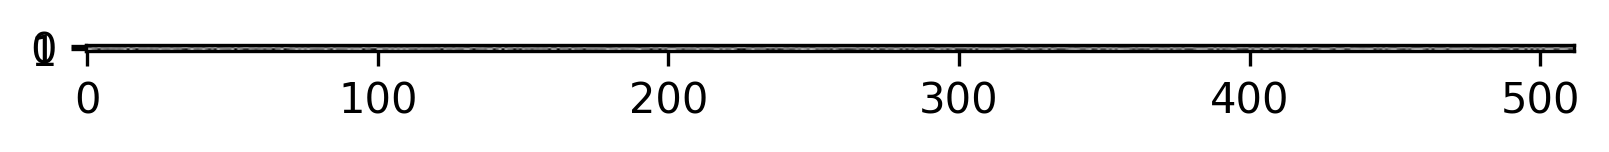

GRU(267, 256, batch_first=True, dropout=0.2)


In [ ]:
# @title visualise lin
# https://matplotlib.org/stable/plot_types/index.html
from torchvision import utils
import matplotlib.pyplot as plt

# for name, param in agent.jepa.pred.named_parameters(): # for param in model.parameters():
# for name, param in agent.emb.named_parameters():
for name, param in agent.tcost.named_parameters():
    print(name, param.shape)
    if len(param.shape)==1: param=param.unsqueeze(0)
    Z=param.detach()#.numpy()

    filter_img = utils.make_grid(Z, nrow = 12, normalize=True, padding=1)
    plt.imshow(filter_img.cpu().permute(1, 2, 0)) # (H, W, C)

    # fig, ax = plt.subplots()
    # pos=ax.imshow(Z)
    # fig.colorbar(pos)
    plt.show()

print(agent.jepa.pred)


In [ ]:
# print(vars(agent.jepa.pred.))
# print(vars(agent.tcost.state_dict()))
# print(agent.jepa.pred._parameters.keys())
# print(agent.jepa.pred._parameters['weight_ih_l0'])
# print(agent.jepa.pred._parameters['weight_hh_l2']) # weight_hh_l0, weight_hh_l2
# print(agent.tcost.state_dict().keys())
print(agent.tcost.state_dict()['tcost.1.weight']) # tcost.2.bias, tcost.4.bias
# print(agent.tcost.named_parameters())


tensor([[ 0.0015, -0.0132,  0.0280,  ...,  0.0297,  0.0289,  0.0152],
        [ 0.0168,  0.0031, -0.0288,  ..., -0.0064, -0.0137, -0.0085]])


In [ ]:
# @title ConvEnc
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class ConvEnc(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            # nn.Conv2d(1, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            # nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            # nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            # nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            # nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.BatchNorm2d(d_list[5]), nn.ReLU(),
            # # nn.Conv2d(d_list[5], d_list[5], 3, 2, 1), nn.BatchNorm2d(d_list[5]), nn.ReLU(),
            # nn.Conv2d(d_list[5], d_list[5], 2, 2, 0), nn.BatchNorm2d(d_list[5]), nn.ReLU(),
            # # 2457024

            # nn.Conv2d(1, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            # 685248

            # nn.Conv2d(1, d_list[0], 4, 2, 2), nn.BatchNorm2d(d_list[0]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[0], d_list[1], 4, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[1], d_list[2], 4, 2, 2), nn.BatchNorm2d(d_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[2], d_list[3], 4, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            # # #


            nn.Conv2d(1, d_list[0], 4, 4, 0), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 4, 4, 0), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 4, 4, 0), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 4, 4, 0), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            #


            nn.Flatten(start_dim=1),
            # # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            # nn.Linear(4*d_list[5],d_model), nn.ReLU(),
        )
    def forward(self, x): return self.cnn(x)


convenc = ConvEnc(256).to(device)
input = torch.rand((4,1,256,256), device=device)
out = convenc(input)
print(out.shape)
print(sum(p.numel() for p in convenc.parameters() if p.requires_grad)) #



torch.Size([4, 256])
690080


In [ ]:
# @title transfer weights
import torch
import torch.nn as nn

d = 10  # size of the first dimension
a = 5   # size of the extra nodes to omit
m = 8   # output dimension

source_layer = nn.Linear(d+a, m)
target_layer = nn.Linear(d, m)
# source_layer = nn.Linear(d, m)
# target_layer = nn.Linear(d+a, m)

def transfer(tgt,src):
    with torch.no_grad():
        tgt.weight[:, :src.weight.shape[1]].copy_(src.weight[:, :tgt.weight.shape[1]])
        tgt.bias.copy_(src.bias)
    return tgt,src

target_layer, source_layer = transfer(target_layer, source_layer)


src_sd = source_layer.state_dict()
tgt_sd = target_layer.state_dict()

def transfersd(tgt,src):
    with torch.no_grad():
        tgt['weight'][:, :src['weight'].shape[1]].copy_(src['weight'][:, :tgt['weight'].shape[1]])
        tgt['bias'].copy_(src['bias'])
    return tgt

tgt_sd = transfersd(tgt_sd, src_sd)
target_layer.load_state_dict(tgt_sd)


agent_src = Agent(d_model=256, dim_a=3, dim_z=1, dim_v=512).to(device)

# agent.tcost = TCost((1+agent.jepa.pred.num_layers)*agent.d_model) # replace tcost

agent = Agent(d_model=256, dim_a=3, dim_z=3, dim_v=512).to(device)

# agent.jepa.pred
# target_layer, source_layer = transfer(target_layer, source_layer)







# print(vars(agent.jepa.pred))
# gru = agent.jepa.pred
# gru = agent_src.jepa.pred
# for wht_name in gru._all_weights[0]: # weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0
#     print(wht_name, gru._parameters[wht_name].shape)

# weight_ih_l0 dim_z=3: [768, 262] , dim_z=1: [768, 260]
# weight_hh_l0 torch.Size([768, 256])
# bias_ih_l0 torch.Size([768])
# bias_hh_l0 torch.Size([768])

# tgt_gru = agent.jepa.pred
# src_gru = agent_src.jepa.pred
tgt_gru = torch.nn.GRU(d_model+dim_a+dim_z+2, d_model, num_layers=1, batch_first=True, dropout=0.0)
src_gru = torch.nn.GRU(d_model+dim_a+dim_z, d_model, num_layers=3, batch_first=True, dropout=0.0)

tgt_gru[]
def transfer_gru(tgt_gru, src_gru): # change input dim of gru
    with torch.no_grad():
        for i in range(min(len(tgt_gru._all_weights), len(src_gru._all_weights))):
        # for lyr in tgt_gru._all_weights:
            lyr = tgt_gru._all_weights[i]
            for wht_name in lyr: # weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0
                # print(wht_name, tgt_gru._parameters[wht_name].shape)
                tgt_wht, src_wht = tgt_gru._parameters[wht_name], src_gru._parameters[wht_name]
                if len(tgt_wht.shape)==2:
                    tgt_wht[:, :src_wht.shape[1]].copy_(src_wht[:, :tgt_wht.shape[1]])
                elif len(tgt_wht.shape)==1:
                    tgt_gru._parameters[wht_name] = src_wht
    return tgt_gru
tgt_gru = transfer_gru(tgt_gru, src_gru)

# for wht_name in tgt_gru._all_weights[0]: # weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0
#     print(wht_name, tgt_gru._parameters[wht_name].shape)




d_model=256; dim_a=3; dim_z=1; dim_v=512

pred = torch.nn.GRU(d_model+dim_a+dim_z, d_model, num_layers=1, batch_first=True, dropout=0.0)
# pred = torch.nn.GRU(d_model+dim_a+dim_z, d_model, num_layers=3, batch_first=True, dropout=0.0)
print(pred._all_weights)
for lyr in pred._all_weights:
    for wht_name in lyr: # weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0
        print(wht_name, pred._parameters[wht_name].shape)




# print(pred.state_dict().keys())

tgt_gru = torch.nn.GRU(d_model+dim_a+dim_z+2, d_model, num_layers=3, batch_first=True, dropout=0.0)
src_gru = torch.nn.GRU(d_model+dim_a+dim_z, d_model, num_layers=1, batch_first=True, dropout=0.0)
print(tgt_gru.state_dict()['weight_ih_l0'][0][:10])
print(src_gru.state_dict()['weight_ih_l0'][0][:10])

print(tgt_gru.state_dict()['bias_ih_l0'][:10])
print(src_gru.state_dict()['bias_ih_l0'][:10])
tgt_gru.state_dict().keys()
src_gru.state_dict().keys()

# tgt_gru
# src_gru
for wht_name in tgt_gru.state_dict().keys():
    if not wht_name in src_gru.state_dict().keys(): continue
    print(wht_name)
    # print(tgt_gru.state_dict()[wht_name])
    # tgt_gru.state_dict()[wht_name].copy_(src_gru.state_dict()[wht_name])

tgt_sd = tgt_gru.state_dict()
src_sd = src_gru.state_dict()
def transfer_sd(tgt_sd, src_sd): # change input dim of gru
    with torch.no_grad():
        for wht_name in tgt_sd.keys():
            if not wht_name in src_sd.keys(): continue
            # print(wht_name)
            tgt_wht, src_wht = tgt_sd[wht_name], src_sd[wht_name]
            if len(tgt_wht.shape)==2:
                tgt_wht[:, :src_wht.shape[1]].copy_(src_wht[:, :tgt_wht.shape[1]])
            elif len(tgt_wht.shape)==1:
                tgt_wht.copy_(src_wht)
    return tgt_sd
tgt_sd = transfer_sd(tgt_sd, src_sd)
print(tgt_sd['weight_ih_l0'][0][:10])
print(tgt_sd['bias_ih_l0'][:10])





In [ ]:
# @title test init norm
print(agent.emb.state_dict()['weight'].norm(dim=-1))

# x = torch.rand(16)
x = torch.rand(8,16)
# print(x)
# torch.nn.init.normal_(x, mean=0.0, std=1.0)
# torch.nn.init.xavier_normal_(x)
import time
start = time.time()
# torch.nn.init.xavier_uniform_(x)
# with torch.no_grad(): x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # 0.00966, 0.000602, 0.0004
# torch.nn.init.normal_(x, mean=0.0, std=1./x.shape[-1]**0.5)
torch.nn.init.normal_(x, mean=0., std=.3/x.shape[-1]**0.5)
print(time.time()-start)
# std = ((Sum (xi-mean)^2)/ N)^(1/2)
# print(x)
# print(((x**2).sum())**(0.5))
print(torch.norm(x, dim=-1))


0.0012018680572509766
tensor([0.2797, 0.2218, 0.2731, 0.3268, 0.2632, 0.2914, 0.3217, 0.2845])


In [ ]:
# @title wasserstein
import torch

def wasserstein(x, y, weight=1):
    # x, y = x / x.sum(), y / y.sum()
    cdf_x, cdf_y = x.cumsum(dim=-1), y.cumsum(dim=-1)
    dist = weight * torch.abs(cdf_x - cdf_y) # Wasserstein dist = L1 norm between CDFs
    # dist = weight * (cdf_x - cdf_y)**2 # me
    return dist.sum()

def wasserstein(x, y, weight=1):
    # x, y = x / x.sum(), y / y.sum()
    # cdf_x, cdf_y = x.cumsum(dim=-1), y.cumsum(dim=-1)
    # dist = weight * torch.abs(cdf_x - cdf_y) # Wasserstein dist = L1 norm between CDFs
    # cs = (x-y).cumsum(dim=-1)
    cs = (x-y) @ torch.tril(torch.ones(x.shape[0], x.shape[0]))
    # dist = weight * torch.abs(cs)
    dist = weight * cs**2
    # dist = weight * (cdf_x - cdf_y)**2 # me
    return dist.sum()


def soft_wasserstein_loss(x, y, smoothing=0.1):
    # Normalise distributions
    x = x / x.sum()
    y = y / y.sum()
    # Compute the cumulative distributions (CDFs) with a small smoothing factor
    cdf_x = torch.cumsum(x, dim=-1) + smoothing
    cdf_y = torch.cumsum(y, dim=-1) + smoothing
    # Compute smooth Wasserstein distance (L2 distance between CDFs)
    distance = torch.norm(cdf_x - cdf_y, p=2)  # L2 distance instead of L1 for smoother gradients
    return distance





# x = torch.tensor([0.2, 0.3, 0.5], dtype=torch.float32)
# x = nn.Parameter(torch.tensor([0.2, 0.3, 0.5], dtype=float))
x = nn.Parameter(torch.tensor([-0.01, -0.0, -0.99], dtype=torch.float))
y = torch.tensor([0.0, 0.0, -1.0], dtype=torch.float)

# x = nn.Parameter(torch.rand(1024, dtype=float))
# y = torch.rand(1024, dtype=float)
# a = len(train_data.buffer)/len(train_data.data) # ratio dided/tt steps
a=1/45

import time
start = time.time()
weight = torch.where(y < -0.5, 1/a, 1/(1-a))
print(weight)
dist = wasserstein(x, y, weight=weight)
print(time.time() - start)
print(dist)  # Should output 0.7
# dist.backward()

# 0.0004496574401855469
# 0.000331878662109375


In [ ]:
# @title wasserstein sinkhorn train

import torch
import torch.nn as nn

# agent.eval()
# batch_size, T, _ = sx.shape
x = nn.Parameter(torch.tensor([0,0,-1,0,0,0,-0.1, 0], device=device))
optim = torch.optim.SGD([x], lr=1e-3) # 3e3
# optim = torch.optim.AdamW([x], 1e-1, (0.9, 0.999)) # ? 1e0 ; 3e-2 1e-1
# optim = torch.optim.AdamW([x], 1e-0, (0.9, 0.95)) # ? 1e0 ; 3e-2 1e-1
y = torch.tensor([0,0,0,0,0,0,-1,0], dtype=torch.float)
a=1/45
weight = torch.where(y < -0.5, 1/a, 1/(1-a))
# print(weight)

# loss = wasserstein(x, y, weight=weight)
# loss = wasserstein(x, y)
# loss = sinkhorn(x, y)
# loss.backward()
# print(x.grad)


for i in range(50): # num epochs
    loss = wasserstein(x, y, weight=weight)
    # loss = sinkhorn(x, y)
    # loss = sinkhorn(x, y,0.05,80)
    loss.sum().backward()
    optim.step()
    optim.zero_grad()
    print(x.data, loss.item())






import torch

def sinkhorn(x, y, epsilon=0.05, max_iters=100):
    # x, y = x / x.sum(), y / y.sum()

    # Compute the cost matrix: here the cost is the squared distance between indices
    # (|i-j|^2 for each position i, j)
    posx = torch.arange(x.shape[-1], dtype=torch.float).unsqueeze(1)
    posy = torch.arange(y.shape[-1], dtype=torch.float).unsqueeze(0)
    cost_matrix = (posx - posy).pow(2)  # squared distance

    # Initialize the dual variables
    u = torch.zeros_like(x)
    v = torch.zeros_like(y)

    # Sinkhorn iterations
    K = torch.exp(-cost_matrix / epsilon)  # Kernel matrix, regularised with epsilon
    for _ in range(max_iters):
        u = x / (K @ (y / (K.t() @ u + 1e-8)) + 1e-8)
        v = y / (K.t() @ (x / (K @ v + 1e-8)) + 1e-8)
    # print(K,u.data,v.data)
    plan = torch.diag(u) @ K @ torch.diag(v)
    dist = torch.sum(plan * cost_matrix)
    return dist

# Example
x = torch.tensor([0.2, 0.3, 0.5], dtype=torch.float, requires_grad=True)
y = torch.tensor([0.0, 0.0, 1.0], dtype=torch.float)
# x = nn.Parameter(torch.tensor([0,0,-1,0,0,0,-0.1, 0], device=device))
# y = torch.tensor([0,0,0,0,0,0,-1,0], dtype=float)

# dist = sinkhorn(x, y)
dist = sinkhorn(x, y, 0.05,80)
dist.backward()  # To compute gradients with respect to x

print(dist.item())
print(x.grad)

# [2.0000e+07, 3.0000e+07, 1.0000e-08]) tensor([       0.,        0., 49999996.] episodes>=80



In [ ]:
# @title torchrl.data.PrioritizedReplayBuffer
from torchrl.data import LazyMemmapStorage, LazyTensorStorage, ListStorage
buffer_lazytensor = ReplayBuffer(storage=LazyTensorStorage(size))

from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
buffer_lazymemmap = ReplayBuffer(storage=LazyMemmapStorage(size), batch_size=32, sampler=SamplerWithoutReplacement())


from torchrl.data import ListStorage, PrioritizedReplayBuffer

torch.manual_seed(0)

rb = PrioritizedReplayBuffer(alpha=0.7, beta=0.9, storage=ListStorage(10))
data = range(10)
rb.extend(data)
# rb.extend(buffer)


sample = rb.sample(3)
print(sample)



## plot 3D

In [ ]:
# @title sklearn RBF
# https://gist.github.com/eljost/2c4e1af652ef02b2989da341c5569af7
# from nn_plot.ipynb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import scipy.stats as st

# np.random.seed(1)
def func(x):
    # print(x.shape)
    # x= np.sum(x**2, axis=-1)
    x=np.random.rand(x.shape[0])
    print(x.shape)
    return x

res = 50
num_pts=15
X=np.random.rand(num_pts,2)*res
# Y = func(X)
Y=np.random.rand(num_pts)
# print(X);print(Y)

lim = 1
# lin = np.linspace(-lim, lim, res)
lin = np.linspace(0, res, res)
x1, x2 = np.meshgrid(lin, lin)
xx = np.vstack((x1.flatten(), x2.flatten())).T

kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, Y)
# print("Learned kernel", gp.kernel_)
y_mean, y_cov = gp.predict(xx, return_cov=True)

posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov, size=1)

ax = plt.figure().add_subplot(projection='3d')
Z=posteriors.reshape(-1, res)
# ax.plot_surface(x1, x2, Z)
ax.plot_surface(x1, x2, Z, cmap='rainbow', alpha=0.7)

# ax.plot_surface(x1, x2, posteriors.reshape(-1, res))
ax.contour(x1, x2, Z, zdir='z', offset=-1, cmap='coolwarm') # https://matplotlib.org/stable/gallery/mplot3d/contour3d_3.html#sphx-glr-gallery-mplot3d-contour3d-3-py
# ax.set(xlim=(0, 50), ylim=(0, 50), zlim=(-0.4, 0.5))#, xlabel='X', ylabel='Y', zlabel='Z')
ax.set(xlim=(0, 50), ylim=(0, 50), zlim=(-1, 2))#, xlabel='X', ylabel='Y', zlabel='Z')

# ax.scatter3D(X[:, 0], X[:, 1],Y, c=zdata, cmap='Greens');
# ax.scatter3D(X[:, 0], X[:, 1],Y, cmap='Greens');

plt.show()


In [ ]:
# @title chatgpt RBFKernelLayer
import torch
import torch.nn as nn
import torch.nn.functional as F

class RBFKernelLayer(nn.Module):
    def __init__(self, in_features, out_features, sigma=1.0):
        super(RBFKernelLayer, self).__init__()
        self.centres = nn.Parameter(torch.randn(out_features, in_features))
        self.sigma = sigma

    def forward(self, x):
        dists = torch.cdist(x, self.centres, p=2) ** 2
        return torch.exp(-dists / (2 * self.sigma ** 2))

class SaddlePointNetwork(nn.Module):
    def __init__(self, in_features, out_features, sigma=1.0):
        super(SaddlePointNetwork, self).__init__()
        self.rbf_layer = RBFKernelLayer(in_features, out_features, sigma)
        self.linear = nn.Linear(out_features, 1)

    def forward(self, x):
        rbf_output = self.rbf_layer(x)
        # Introduce a saddle point structure
        linear_output = self.linear(rbf_output)
        # Example saddle function: x^2 - y^2
        saddle_output = torch.sum(linear_output[:, :1]**2 - linear_output[:, 1:]**2, dim=1, keepdim=True)
        return saddle_output

# sin(ax)sin(bx)
# (x^2 - y^2)
import torch

def rbf_saddle(x, y, gamma=1.0, a=1.0, b=1.0):
    # RBF-like term
    rbf_term = torch.exp(-gamma * torch.norm(x - y, p=2)**2)
    # Saddle point term
    saddle_term = (a * x)**2 - (b * y)**2
    return rbf_term + saddle_term

# Example usage
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([2.0], requires_grad=True)

output = rbf_saddle(x, y)
print(output)

# Compute gradients
output.backward()
print(x.grad, y.grad)



tensor([-2.6321], grad_fn=<AddBackward0>)
tensor([2.7358]) tensor([-4.7358])


In [ ]:
# @title plot 3d

import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 100)
y = torch.linspace(-2 * torch.pi, 2 * torch.pi, 100)
X, Y = torch.meshgrid(x, y)
Z = rbf_saddle(X, Y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [ ]:
# @title shape NN
num_pts=1

# X=torch.rand(num_pts,4)*2-1
# X=torch.cat([torch.tensor([0,0]).unsqueeze(0),torch.rand(num_pts,2)*2-1], dim=-1)
X=torch.cat([torch.zeros(1,1),torch.rand(num_pts,2)*2-1,torch.zeros(1,1)], dim=-1)
Y=torch.rand(num_pts)
print(X,Y)
optim = torch.optim.SGD(model.parameters(), 1e-1)

# model.train()
pred = model(X)
# print(Y.shape,pred.shape)
# loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.reshape(-1))
loss = F.mse_loss(Y, pred.squeeze(-1))
loss.backward()
optim.step()
optim.zero_grad()
print(loss)


tensor([[ 0.0000, -0.7231,  0.3792,  0.0000]]) tensor([0.3362])
tensor(0.0035, grad_fn=<MseLossBackward0>)


In [ ]:
# @title plot NN

xx = torch.linspace(-1, 1, 100)
yy = torch.linspace(-1, 1, 100)
X, Y = torch.meshgrid(xx, yy) # [100,100]
xy = torch.cat([X.unsqueeze(-1), torch.zeros(X.shape+(2,)), Y.unsqueeze(-1)], dim=-1)


# model = nn.Sequential(
#     nn.Linear(x.shape[-1]+z.shape[-1],d_model), nn.LeakyReLU(),
#     nn.Linear(d_model,d_model), nn.LeakyReLU(),
#     nn.Linear(d_model,d_model), nn.LeakyReLU(),
#     nn.Linear(d_model,1), nn.LeakyReLU(),
# )

with torch.no_grad(): Z = model(xy).squeeze(-1)
# print(Z)
# print(Z.shape)

# Z = rbf_saddle(X, Y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy(), cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()



In [ ]:
# @title test optim saddle same time
import torch
import torch.nn as nn

def f(x, y):
    return x ** 2 - y ** 2 + x * y
# (x-y)(x+y)+xy

batch=16
T=1
dim_x, dim_z = 3, 8
# torch.nn.init.xavier_uniform_(x)
xx = torch.empty((1, T, dim_x))
torch.nn.init.xavier_uniform_(xx)
# x = nn.Parameter(xx.clone().repeat(batch,1,1))
x = nn.Parameter(torch.empty((batch, T, dim_x)))

# tensor([[0.6478, 0.0531, 0.0861]]) tensor([[-1.,  1.]]) 0.2974517047405243
# tensor([-0.9419, -1.0000,  0.4416, -1.0000,  1.0000,  0.2963])

# x = nn.Parameter(torch.tensor([[0.6478, 0.0531, 0.0861]]))

lr = 3e-2 # sgd 1e-1,1e-0,1e4 ; adamw 1e-1
lr = 1e-1 # adamw 1e-1
ratio = 4
# optim_x = torch.optim.SGD([x], lr=lr)
# optim_x = torch.optim.AdamW([x], lr, (0.9, 0.95)) # 1e-1 ; 1e-2 3e-2
optim_x = torch.optim.AdamW([x], lr, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2

z = nn.Parameter(torch.empty((batch, T, dim_z)))
# z = torch.empty((1, T, 1))
torch.nn.init.xavier_uniform_(z)
# z = nn.Parameter(z.repeat(batch,1,1))
# z = nn.Parameter(torch.tensor([[-1.,  1.]]))
# optim_z = torch.optim.SGD([z], lr=ratio*lr, maximize=True) # 3e3
# optim_z = torch.optim.AdamW([z], ratio*lr, (0.9, 0.95), maximize=True) # 1e0 ; 3e-2 1e-1
optim_z = torch.optim.AdamW([z], ratio*lr, (0.9, 0.999), maximize=True) # 1e0 ; 3e-2 1e-1
# .95,1e-1,3e-1
# .99,

d_model = 4
# model = nn.Sequential(
#     nn.Linear(x.shape[-1]+z.shape[-1],d_model), nn.LeakyReLU(),
#     nn.Linear(d_model,d_model), nn.LeakyReLU(),
#     nn.Linear(d_model,d_model), nn.LeakyReLU(),
#     nn.Linear(d_model,1), nn.LeakyReLU(),
# )




# print("search",x.squeeze().data, z.squeeze())
# print("search",x.squeeze().data, z.squeeze().item())
for i in range(10): # num epochs
    # loss = f(x,z)
    # loss = f(x.sum(-1),z)
    xz = torch.cat([x,z], dim=-1)
    loss = model(xz)
    loss.sum().backward()
    optim_x.step(); optim_z.step()
    optim_x.zero_grad(); optim_z.zero_grad()
    # print(i,x.squeeze(), z.squeeze(), loss.squeeze().item())
    # print(i,x.squeeze()[0], z.squeeze(), loss.squeeze().item())
    print(i,x.squeeze()[0].data, z[0].squeeze().data, loss[0].squeeze().item())
    with torch.no_grad():
        # x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
        x.clamp_(min=-1, max=1)
        z.clamp_(min=-1, max=1)
    # print(i,x.squeeze().data, z.squeeze().item(), loss.squeeze().item())

# xz = torch.cat([x,z], dim=-1)
# loss = model(xz)
print(loss.squeeze())
idx = torch.argmin(loss) # choose best x even with greatest adv z
# idx = torch.argmax(loss)
# print(x[idx],z[idx],loss[idx])
print(x[idx].data,z[idx].data,loss[idx].item())

idx = torch.argmin(loss)
print(x[idx].data,z[idx].data,loss[idx].item())
print(torch.cat([x,z,loss],dim=-1).squeeze().data)



In [ ]:
# @title test optim saddle argm
import torch
import torch.nn as nn


def argm(sx, lr=3e3): # 3e3
    # batch=sx.size(dim=0)
    batch_size, T, _ = sx.shape
    batch = 16
    # z = nn.Parameter(torch.zeros((batch,1),device=device))
    # z = nn.Parameter(torch.empty((1,batch, T, dim_z)))
    z = nn.Parameter(torch.empty((batch_size,batch, T, dim_z)))
    torch.nn.init.xavier_uniform_(z)
    # optim = torch.optim.SGD([z], lr=lr, maximize=True)
    optim = torch.optim.AdamW([z], 1e1, (0.9, 0.95), maximize=True)
    sx = sx.detach().unsqueeze(1).repeat(1,batch,1,1)
    # sx = sx.detach()
    for i in range(20): # 10
        # print(sx.shape,z.shape)
        sxz = torch.cat([sx, z], dim=-1)
        with torch.amp.autocast('cuda'):
            cost = model(sxz)
        cost.sum().backward()
        optim.step()
        optim.zero_grad()
        with torch.no_grad(): z.clamp_(min=-1, max=1)
        # print("worst case",i,cost.item(), torch.mean(abs(z.detach())).item())
        # print("argm cost z",i,cost.item(), z.detach().item())
        # print("argm cost z",i,cost.squeeze(), z.detach().squeeze())
    # if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
    # return z.detach()
    print(cost.squeeze().data)
    idx = torch.argmax(cost.squeeze(), dim=1)
    return z[torch.arange(z.shape[0]),idx].detach()




batch=16
T=1
# x = nn.Parameter(torch.empty((batch, T, dim_x)))
# torch.nn.init.xavier_uniform_(x)
# x = nn.Parameter(xx.clone())
x = nn.Parameter(xx.clone().repeat(batch,1,1))

lr = 3e-2 # sgd 1e-1,1e-0,1e4 ; adamw 1e-1
# ratio = 6e0
lr = 1e-1 # adamw 1e-1
ratio = 4
# optim_x = torch.optim.SGD([x], lr=lr)
# optim_x = torch.optim.AdamW([x], lr, (0.9, 0.95)) # 1e-1 ; 1e-2 3e-2
optim_x = torch.optim.AdamW([x], lr, (0.9, 0.999)) # 1e-1 ; 1e-2 3e-2
# print(x.shape)


# print("search",x.squeeze().data, z.squeeze())
# print("search",x.squeeze().data, z.squeeze().item())
for i in range(50):
    z = argm(x)
    # print(x.shape,z.shape)
    xz = torch.cat([x,z], dim=-1)
    loss = model(xz)
    loss.sum().backward()
    optim_x.step()
    optim_x.zero_grad()
    # print(i,x.squeeze().data, z.squeeze().data, loss.sum().item())
    # print(i,x.squeeze().data, z.squeeze().data, loss.squeeze().item())
    # print(i,x.squeeze()[0], z.squeeze(), loss.squeeze().item())
    # print(i,x[0].squeeze().data, z[0].squeeze().data, loss.squeeze().item())
    with torch.no_grad():
        # x /= torch.norm(x, dim=-1).unsqueeze(-1).clamp_(min=1) # need x in place
        x.clamp_(min=-1, max=1)
    # print(i,x.squeeze().data, z.squeeze().item(), loss.squeeze().item())

# xz = torch.cat([x,z], dim=-1)
# loss = model(xz)
# print("z",z)
# print(loss.squeeze())
idx = torch.argmin(loss)
print(x[idx].data,z[idx],loss[idx].item())

print(torch.cat([x,z,loss],dim=-1).squeeze().data)


In [ ]:

x = torch.randn(16, 16)
# print((b==torch.max(b)).nonzero())
x = torch.randn(10, 3)
idx = torch.randint(3,(10,))
# print(x[:,idx].shape)
print(x[torch.arange(x.shape[0]),idx].shape)



torch.Size([10, 10])
torch.Size([10])


## trash

In [ ]:
# @title torch gru
# text_generation.ipynb https://colab.research.google.com/drive/1SguQZQYZBaalRuElJcxGdgF3YxhiwkAM
# RNNs.ipynb https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR

import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class gru(nn.Module):
    def __init__(self, emb_dim, rnn_units, num_layers):
        super().__init__()
        self.gru = nn.GRU(emb_dim, rnn_units, num_layers=num_layers, dropout=0.0, batch_first=True)
        self.dense = nn.Linear(rnn_units, vocab_size)
        self.rnn_units = rnn_units
        self.num_layers = num_layers

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.rnn_units, device=device) # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        if hidden is None: hidden = self.init_hidden(x.shape[0])
        # print('fwd',x.shape, hidden.shape) # fwd [batch_size, bptt, emb_dim], [num_layers, batch_size, rnn_units]
        output, hidden = self.gru(x, hidden)
        output = self.dense(output)
        return output, hidden


emb_dim = 256#256
rnn_units = 1024#1024
num_layers = 1
# model = gru(emb_dim, rnn_units, num_layers).to(device)
# model.summary()



In [ ]:
# @title ltm
import faiss
import numpy as np
import pickle
import torch

class Ltm():
    def __init__(self, ltmk=None, ltmv=None):
        self.index = None
        if ltmk is None:
            self.ltmk = torch.tensor([])
            self.ltmv = torch.tensor([])
        else:
            self.ltmk = ltmk # [len_ltm, d_model]
            self.ltmv = ltmv
        if len(self.ltmk)>=100:
            self.index = makefaissindex(ltmk)

    # def add(self, k, v):
    def add(self, k, v, mask=None):
        # self.ltmk.append(k)
        # self.ltmv.append(v)
        if k==None: return
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        if mask==None:
            self.ltmk = torch.cat([self.ltmk, k], dim=1)
            self.ltmv = torch.cat([self.ltmv, v], dim=1)
        else:
            self.ltmk[mask] = torch.cat([self.ltmk[mask], k], dim=1)
            self.ltmv[mask] = torch.cat([self.ltmv[mask], v], dim=1)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.1:
                self.index.train(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        return mask

    def __call__(self, query, k=5, treshold=36): # [batch_size, d_model]
        if self.index!=None and len(self.ltmk)>=100:
            mask = self.vecsearch(query, k, treshold)
            rag = self.ltmk[mask] # [len_rag, d_model]
        else:
            rag = self.ltmk
        if len(rag)==0: return 0
        # print("ltm call", query.shape, rag.shape)
        # attn = query @ rag.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ rag.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.ltmv
        return x # [batch_size, d_model]

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(file='ltm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv), f)

    def load(file='ltm.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv = pickle.load(f)

ltm = Ltm()


In [ ]:
# @title stm
import torch
import pickle

class Stm():
    def __init__(self, stmk=None, stmv=None, meta=None):
        self.stmk = stmk # [len_ltm, d_model]
        self.stmv = stmv
        self.meta = meta

    def __call__(self, query):
        # if len(rag)==0: return 0
        # print("stm call", query.shape, self.stmk.shape)
        # attn = query @ self.stmk.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.stmv
        self.meta = self.meta + attn.squeeze() # attention
        return x # [batch_size, d_model]

    def add(self, k, v):
        if k.ndim==1:
            k=k.unsqueeze(0)
            v=v.unsqueeze(0)
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)
        # self.meta = torch.cat([self.meta, torch.ones(1,1)], dim=-1)
        self.meta = torch.cat([self.meta, torch.ones(self.meta.shape[0],1)], dim=-1)
        # self.meta = torch.cat([self.meta, torch.ones(1)])

    def decay(self, g=0.9, k=256):
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
        self.meta = topk.values # cap stm size
        self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5):
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        popk, popv = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask]
        self.meta = self.meta[~mask]
        return popk, popv, mask.any(dim=-1)

    def save(file='stm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.stmk, self.stmv, self.meta), f)

    def load(file='stm.pkl'):
        with open(file, 'rb') as f: self.stmk, self.stmv, self.meta = pickle.load(f)



In [ ]:
# @title split params to train
# qkv for useful for critic predicting cost?

# train after each step: jepa(pred)(using SL)?

# train after each episode: critic, jepa()


# jepa is batch of same length episodes, take from history
# cost is single full episode buffer

# or combine string of episode buffers, batchify like rnn training


# batch_size = 64
# weights = torch.ones(len(buffer))#.expand(batch_size, -1)
# index = torch.multinomial(weights, num_samples=batch_size, replacement=False)
# buffer[index]


for name, p in agent.named_parameters():
    print(name, 'tcost' in name)
# https://pytorch.org/docs/stable/optim.html#per-parameter-options4
# optim.SGD([
#                 {'params': others},
#                 {'params': bias_params, 'weight_decay': 0}
#             ], weight_decay=1e-2, lr=1e-2)

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]

# # joptim = torch.optim.AdamW(agent.jepa.parameters(), lr=1e-3)
# joptim = torch.optim.AdamW([agent.jepa.parameters(),agent.q.parameters(), agent.k.parameters(), agent.v.parameters()], lr=1e-3)
# coptim = torch.optim.AdamW(agent.tcost.parameters(), lr=1e-3)
joptim = torch.optim.AdamW(tcost_params, lr=1e-3)
coptim = torch.optim.AdamW(others, lr=1e-3)
agent.train(buffer, joptim, coptim)


In [ ]:
# @title assorted
# print(type(buffer[0][0]))
# print(buffer[0][0])
# print(buffer[0][0].dtype)
import numpy as np

# b=np.random.randint(low=0, high=256, size=(1000, 64, 64, 3), dtype='uint8')
b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(1000)]
# print(b.shape)
# print(b[0])
def custom_collate(original_batch):
    return original_batch

train_data = BufferDataset(b, seq_len) # one line of poem is roughly 50 characters
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2) # num_workers = 4
# train_loader = DataLoader(train_data, shuffle = True, pin_memory = False, batch_size = batch_size, collate_fn=custom_collate) # num_workers = 4
# train_loader = DataLoader(test_dataset, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 0)

    # def plan(self, ): # mpc
    #     # xs, us = locuslab_mpc(x_init, goal_state, self.jepa)
    #     xs, us = locuslab_mpc(x_init, goal_state, self.jepa)

# def train_cost(self, dataloader, buffer, optim):

#         c = c + self.icost(world_state_) + reward
#         c_ = c_ + cost
#     closs = nn.MSELoss()(c,c_) # L1Loss MSELoss ; Sum reward
#     closs.backward()
#     optim.step()



In [ ]:
# @title custom transforms ToTensorme
import torchvision.transforms as transforms
# 100,3
# seq_len,
# for batch, Sar in enumerate(train_data):
for batch, Sar in enumerate(train_loader):
# for batch, (State, Action, Reward) in enumerate(train_loader):
# for batch, (Sar,_) in enumerate(train_loader):
    # print(len(Sar[0]))
    # print(Sar[0][0].shape)
    # State, Action, Reward = zip(*Sar)
    # State=Sar
    break
for s,a,r in zip(*Sar):
    state=s
    break
print(len(State))
print(len(State[0]))
print(type(State[0]))


# transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)),

# def ToTensorme(x):
#     print("ToTensorme",type(x))
#     # if type(x) == np.ndarray: return x.astype(np.float32)
#     # if type(x) == np.ndarray: return torch.from_numpy(x).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.permute(2,0,1).to(torch.float32)
#     if type(x) == torch.Tensor: return x.permute(0,3,1,2).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.to(torch.float32)

# # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.Lambda(ToTensorme), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Lambda(ToTensorme)])
# # https://pytorch.org/docs/stable/data.html#dataloader-collate-fn

print(State[0].shape)
# out=transform(State[0][0])
# out=transform(State[0])
# out=transform(list(State[0]))
# print(out)

# State = torch.tensor(State)
# print(State.shape)

# State[:,,]
# l=99
# lst=list(range(0,l,7))[1:]+[l]
# print(lst)


# b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(10)]
# for state in b:
#     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     transform(state)



50
16
<class 'torch.Tensor'>
torch.Size([16, 3, 64, 64])


In [ ]:
# @title batch pop to ltm
import torch
batch_size=8
d_model=4
# stmk=torch.rand(batch_size, 5, d_model)
# stmv=torch.rand(batch_size, 5, d_model)
# ltmk=torch.rand(batch_size, 5, d_model)
# ltmv=torch.rand(batch_size, 5, d_model)
# meta=torch.rand(batch_size, 5)*7
# mask = meta>5 # to pop to ltm
# popk, popv = stmk[mask], stmv[mask]
# print(popk.shape, popv.shape)
# stmk, stmv = stmk[~mask], stmv[~mask]
# meta = meta[~mask]
# # return popk, popv


# out=torch.rand(batch_size, 1, d_model)
out=[torch.rand(1, d_model) for _ in range(batch_size)]
lst=torch.rand(batch_size, 5, d_model)
mask=torch.rand(batch_size, 5) > 0.5
# out = torch.cat([out,lst[mask]], dim=1)
# batch, row = torch.where(mask)
# print(batch, row)
# out = torch.cat([out,lst[torch.where(mask)]], dim=1)
# print(out[batch].shape,lst[batch, row,:].shape)
# out[batch] = torch.cat([out[batch],lst[batch, row,:]], dim=1)
# out[batch] = torch.cat([out[batch],lst[batch, row,:].unsqueeze(1)], dim=1)

for b, m in enumerate(mask):
    # out[b] = torch.cat([out[b],lst[b][m]], dim=1)
    out[b] = torch.cat([out[b],lst[b][m]])



# num_masked = mask.sum(dim=1, keepdim=True)
# masked_elements = lst[torch.arange(lst.size(0))[:, None], mask]
# zeros = torch.zeros(batch_size, num_masked.max(), d_model)
# output = zeros.scatter(dim=1, index=masked_elements.nonzero(as_tuple=True)[1], src=masked_elements)
# torch.cat([out, output], dim=1)

# empty_mask = ~mask.any(dim=1)  # Find rows where all mask values are False
# padded_lst = torch.zeros(batch_size, 1, d_model)  # Create a zero tensor for padding
# padded_lst[~empty_mask] = lst[mask][~empty_mask]  # Fill non-empty masks with selected values
# out = torch.cat([out, padded_lst], dim=1)


# print(mask)
# print(mask[:, None])
# print(mask[:, None].expand(-1, lst.size(1), -1))

# out = torch.cat([out, lst[mask[:, None].expand(-1, lst.size(1), -1)]], dim=1)
# out = torch.cat([out, lst[mask[:, None]]], dim=1)

# print(out.shape)
print(out)


In [ ]:
# @title straight through estimator
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)


In [ ]:
# @title train


class Agent(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(1, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            # nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            # nn.Linear(4*d_list[4],d_model), nn.ReLU(),
            nn.Linear(4*d_list[3],d_model), nn.ReLU(),
            # nn.Linear(d_model,10),
        )

        mul=4
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Dropout(), nn.Linear(d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, 10),
            )
    # def forward(self, x): return self.cnn(x)

model = Agent(d_model=256).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-3


def train(model, train_loader, loss_function, optimizer):
    model.train()
    for image, r in train_loader:
        image, r = image.to(device), r.to(device)
        with torch.no_grad(): sx = model.cnn(image)
        # print(sx.shape, r.shape)
        with torch.amp.autocast('cuda'): loss = loss_function(model.tcost(sx), r)
        # loss.backward()
        # optim.step()
        # optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        print(loss.item())
        # try: wandb.log({"loss": loss.item()})
        # except: pass

for epoch in range(10):
    train(model, train_loader, loss_function, optimizer)


In [ ]:
# @title mnist data
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
# test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 64 # 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        nn.Linear(num_ftrs, dim_embd, bias=None),
        )
    return model

# model = get_res(10).to(device)
# model = get_res(2).to(device)

class Agent(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            nn.Linear(4*d_list[4],d_model), nn.ReLU(),
            nn.Linear(d_model,1),
        )
    def forward(self, x): return self.cnn(x)
model=Agent().to(device)


# loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-3


def train(model, train_loader, loss_function, optimizer):
    model.train()
    for image, r in train_loader:
        image, r = image.to(device), r.to(device)
        with torch.amp.autocast('cuda'):
            pred = model(image).squeeze(-1) # squeeze impt for regression!!!
            # print(pred.shape, r.shape)
            loss = loss_function(pred, r)
        # loss.backward()
        # optim.step()
        # optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        print(loss.item())
        try: wandb.log({"loss": loss.item()})
        except: pass

for epoch in range(10):
    train(model, train_loader, loss_function, optimizer)

    images,r = next(iter(train_loader))
    with torch.no_grad():
        # pred = model(images.to(device)).argmax(-1).cpu()
        pred = model(images.to(device)).squeeze(-1).cpu()
        print(r)
        print(pred)
        print((r==pred).sum())



In [ ]:
# @title bin clss
# def train(model, train_loader, loss_function, optimizer):
#     model.train()
#     for image, _ in train_loader:
#         image = image.to(device)#.reshape(-1, 28*28)
#         reconstructed = model(image)
#         loss = loss_function(reconstructed, image)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()


# class Agent(torch.nn.Module):
#     def __init__(self, d_model = 256):
#         super().__init__()
#         # d_list=[32, 64, 128, 256, 512, 1024] #
#         d_list=[32, 64, 128, 256, 256, 256] #
#         # d_list = [min(d, d_model) for d in d_list]
#         self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
#             nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
#             nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
#             nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
#             nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
#             nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
#             # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
#             nn.Flatten(start_dim=1),
#             # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
#             nn.Linear(4*d_list[4],d_model), nn.ReLU(),
#             nn.Linear(d_model,1),
#         )
#     def forward(self, x): return self.cnn(x)

d_model = 256
# tcost = nn.Sequential( # trained cost
#     # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, 1),
#     ).to(device)
mul=4
tcost = nn.Sequential( # trained cost
    # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
    nn.Dropout(), nn.Linear(d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, 2),
    ).to(device)


# agent = Agent(d_model=256).to(device)
# optim = torch.optim.AdamW(agent.parameters(), 1e-2, (0.9, 0.95))
optim = torch.optim.AdamW(tcost.parameters(), 1e-3, (0.9, 0.95))
# optim.param_groups[0]["lr"] = 1e-1

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

# loss_function = torch.nn.MSELoss()
# loss_function = torch.nn.L1Loss()
loss_function = torch.nn.CrossEntropyLoss()
def train_cost(model, dataloader, optim, loss_function=loss_function):
    model.train()
    tcost.train()
    for batch, (st, r) in enumerate(dataloader):
        st, r = st.to(device), r.to(device)#.squeeze(-1)
        # st.requires_grad=True; r.requires_grad=True
        # print(st.requires_grad, r.requires_grad)
        # loss = F.mse_loss(model.tcost(model.jepa.enc(st)), r)
        # print(model.jepa.enc(st))
        # loss = loss_function(model.tcost(model.jepa.enc(st)), r)
        with torch.no_grad(): sx = model.jepa.enc(st)
        with torch.amp.autocast('cuda'): loss = loss_function(tcost(sx), r)
        # print(tcost(sx).squeeze(-1))
        # loss = loss_function(model(st), r)
        # print(next(model.tcost[0].parameters()).grad)
        # print(next(model.jepa.enc.parameters()).grad)
        # print(model.tcost.parameters()[0].grad)
        # print(loss)
        # loss.backward()
        # optim.step()
        # optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        optim.zero_grad()
        print(loss.item())
        try: wandb.log({"closs": loss.item()})
        except: pass


# for i in range(30):
#     train_cost(agent, c_loader, optim)


In [ ]:
# @title train_ae

    def train_ae(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            # state = torch.rand((batch_size, 3,64,64), device=device)
            # sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.amp.autocast('cuda'): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]

                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # jloss = std_loss + cov_loss

                    # state_ = self.deconv(sy.detach()) # pure jepa
                    state_ = self.deconv(sy) # ae
                    # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))

                    conv_loss = F.mse_loss(state_, state)
                    # conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss
                    loss = conv_loss

                    # print("std, cov, conv", std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("loss", loss.item())
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    # sx_ = sx_.detach()

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass


    def get_down(self, state, world_state=None): # update world_state and mem from state
        current = self.sense(state) # [batch_size, d_model] or [1, d_model]
        obs = current# + mem # [batch_size, d_model]
        K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
        # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
        K = F.normalize(K, dim=-1)
        if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
        V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
        world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
        return world_state

    def train_ae(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            # state = torch.rand((batch_size, 3,64,64), device=device)
            # sx_ = self.jepa.enc(state) # [batch_size, d_model]
            world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT

            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.amp.autocast('cuda'):
                    world_state = self.get_down(state, world_state)
                    # sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # sy = self.convenc(world_state.unsqueeze(1)) # [batch_size, d_model]
                    # sy = self.convenc(world_state.unsqueeze(1).detach()) # [batch_size, d_model]
                    sy = self.effnet(world_state.unsqueeze(1).detach()) # [batch_size, d_model]

                    world_state_ = self.deconvenc(sy).squeeze(1) # ae
                    # loss = F.mse_loss(world_state_, world_state)
                    loss = F.mse_loss(world_state_, world_state.detach())
                    # print("std, cov, conv", std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("loss", loss.item())
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    # sx_ = sx_.detach()

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass




In [ ]:
# @title dataloader from transformer
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        # self.data = buffer
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # sar = self.data[idx*self.seq_len : (idx+1)*self.seq_len]
        state, action, reward = zip(*sar)
        state = [self.transform(s) for s in state]
        # print(state.shape, action.shape, reward.shape)
        return state, action, torch.tensor(reward, dtype=torch.float)

    def add(self, episode):
        self.data.append(episode)




class Datasetme(torch.utils.data.Dataset):
    def __init__(self, buffer, batch_size):
        self.batch_size = batch_size

        self.data = [step for episode in buffer for step in episode]
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


        seq_len = data.size(0) // batch_size
        data = data[:seq_len * batch_size]
        # data = data.view(bsz, seq_len).t().contiguous()
        data = data.view(batch_size, seq_len).T.contiguous()

        # self.bptt = 35
        # self.ind = torch.arange(0, self.data.size(0), step=self.bptt)


    def __len__(self):
        return self.data.size(0) // self.batch_size

    def __getitem__(self, index):
        i = self.ind[index]
        seq_len = min(self.bptt, len(self.data) - i)
        data = self.data[i:i+seq_len]
        return data

    def __getitem__(self, idx):
        # sar = self.data[idx*self.seq_len : (idx+1)*self.seq_len]
        # state, action, reward = zip(*sar)
        # state = [self.transform(s) for s in state]
        state, action, reward = self.data[idx]
        # print(state.shape, action.shape, reward.shape)
        return self.transform(state), action, torch.tensor(reward, dtype=torch.float)


def collate_fn(sar):
    # x,y=zip(*data)
    state, action, reward = zip(*sar)
    # print("collate",len(x),len(y))
    # x=torch.stack(list(x), dim=1) # batch_first->dim=0
    state=torch.stack(list(state), dim=0)
    action=torch.stack(list(action), dim=0)
    reward=torch.stack(list(reward), dim=0)
    # y=torch.stack(list(y)).T.flatten()
    return state, action, reward








# @title Datasetme

# class Datasetme(torch.utils.data.Dataset):
#     def __init__(self, raw_data, batch_size):
#         data = self.data_process(raw_data) # list of int, [2049990]
#         self.batch_size = batch_size

#         seq_len = data.size(0) // batch_size
#         data = data[:seq_len * batch_size]
#         # data = data.view(bsz, seq_len).t().contiguous()
#         data = data.view(batch_size, seq_len).T.contiguous()

#         self.bptt = 35
#         self.ind = torch.arange(0, self.data.size(0), step=self.bptt)

#     def __len__(self):
#         return self.data.size(0) // self.batch_size

#     def __getitem__(self, index):
#         i = self.ind[index]
#         seq_len = min(self.bptt, len(self.data) - i)
#         data = self.data[i:i+seq_len]
#         return data



# class Datasetme(torch.utils.data.Dataset):
#     def __init__(self, raw_data):
#         self.data = self.data_process(raw_data) # list of int, [2049990]
#         self.bptt = 35
#         self.ind = torch.arange(0, self.data.size(0) - 1, step=self.bptt)

#     def __len__(self):
#         return len(self.data) // self.bptt

#     def __getitem__(self, idx):
#         i=idx*self.bptt
#         seq_len = self.bptt
#         data = self.data[i:i+seq_len]
#         target = self.data[i+1:i+1+seq_len].reshape(-1)
#         return data, target

# train_iter, val_iter, test_iter = WikiText2() # line by line of wiki  = Valkyria Chronicles III =
# batch_size=128
# train_iter = Datasetme(train_iter)
# # train_loader = Datasetme(train_iter, batch_size)


# def collate_fn(data):
#     x,y=zip(*data)
#     # print("collate",len(x),len(y))
#     x=torch.stack(list(x), dim=1) # batch_first->dim=0
#     y=torch.stack(list(y)).T.flatten()
#     return x, y

# train_loader = torch.utils.data.DataLoader(train_iter, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)






# seq_len = 50 # 50
batch_size = 64 #512
train_data = BufferDataset(buffer, batch_size)
from torch.utils.data.dataloader import DataLoader
# train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
train_loader = DataLoader(train_data, shuffle = True,collate_fn=torch.utils.data._utils.collate.default_convert, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


In [ ]:
# @title transfer_optim bad?

import torch

def transfer_optim(src_optim, tgt_optim, param_mapping):
    src_sd = src_optim.state_dict()
    tgt_sd = tgt_optim.state_dict()

    # Iterate over each parameter in the target optimizer
    for (tgt_idx, target_param) in enumerate(tgt_optim.param_groups[0]['params']):
        target_id = id(target_param)

        # Find the corresponding source parameter using param_mapping
        if target_id in param_mapping:
            source_param = param_mapping[target_id]
            source_id = id(source_param)

            # If there's an existing state for the source parameter, transfer it
            if source_id in src_sd['state']:
                source_state = src_sd['state'][source_id]
                target_state = {}

                # Handle momentum/first and second moments (e.g., `exp_avg`, `exp_avg_sq` in Adam)
                for key in source_state.keys():
                    if source_state[key].shape == target_param.shape: target_state[key] = source_state[key].clone()
                    # If size doesn't match, either copy what you can or initialise new values
                    elif key in ['exp_avg', 'exp_avg_sq']:  # Momentums (specific to Adam-like optimizers)
                        target_state[key] = torch.zeros_like(target_param)
                        target_state[key][:source_param.numel()] = source_state[key].flatten()[:target_param.numel()]
                    else: target_state[key] = torch.zeros_like(target_param) # init
                tgt_sd['state'][target_id] = target_state

    # Load the updated state dict back into the target optimizer
    tgt_optim.load_state_dict(tgt_sd)
    return tgt_optim
# {'state': {0: {'step': tensor(1.), 'exp_avg': tensor, 'exp_avg_sq': tensor}, 1: }}



model_src = torch.nn.Linear(10, 5)  # Example source model
model_tgt = torch.nn.Linear(20, 5)  # Example target model (with more input dimensions)

# model_src = nn.Sequential( # trained cost
#     nn.Linear(10, 5, bias=False), nn.Softmax(),
#     )
# d_model=4
# model_tgt = nn.Sequential( # trained cost
#     nn.Linear(20, d_model), nn.ReLU(),
#     nn.Linear(d_model, d_model), nn.ReLU(),
#     nn.Linear(d_model, 5), nn.Softmax(),
#     )

source_optimizer = optim.AdamW(model_src.parameters())
target_optimizer = optim.AdamW(model_tgt.parameters())

dummy_input = torch.randn(3, 10)
dummy_target = torch.randn(3, 5)
criterion = torch.nn.MSELoss()
output = model_src(dummy_input)
loss = criterion(output, dummy_target)
loss.backward()
source_optimizer.step()

param_mapping = {id(tgt_param): src_param for src_param, tgt_param in zip(model_src.parameters(), model_tgt.parameters())}
target_optimizer = transfer_optim(source_optimizer, target_optimizer, param_mapping)

print(source_optimizer.state_dict())
print(target_optimizer.state_dict())


# checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
# torch.save(checkpoint, folder+'agentoptim.pkl')

# modelsd, optimsd = torch.load('agentoptim.pkl').values()

# optim.load_state_dict(optimsd)





# @title transfer_optim bad? 2
import torch
import torch.nn as nn

def transfer_optimizer_state(source_layer, target_layer, optimizer):
    opt_state_dict = optimizer.state_dict()
    for group in opt_state_dict['param_groups']:
        # For each parameter index (p in param group refers to the layer parameters)
        for param_idx, p in enumerate(group['params']):
            print(p,source_layer.weight)
            if p == source_layer.weight:
                # Find the corresponding target layer parameter (in this case, target_layer.weight)
                target_param = target_layer.weight
                source_state = optimizer.state[p]  # Get the state for the source parameter

                # If the parameter is found in the optimizer's state dict
                if 'exp_avg' in source_state and 'exp_avg_sq' in source_state:
                    exp_avg = source_state['exp_avg']  # First moment (momentum)
                    exp_avg_sq = source_state['exp_avg_sq']  # Second moment (variance)

                    # Handle input dimension mismatch (copy/truncate or pad)
                    source_in_dim = source_layer.weight.shape[1]
                    target_in_dim = target_layer.weight.shape[1]

                    # Copy optimizer state (exp_avg and exp_avg_sq) accordingly
                    with torch.no_grad():
                        # Copy the available part and initialize new dimensions to zero
                        new_exp_avg = torch.zeros_like(target_param)
                        new_exp_avg_sq = torch.zeros_like(target_param)
                        # new_exp_avg[:, source_in_dim:] = 0  # Initialize extra dimensions
                        # new_exp_avg_sq[:, source_in_dim:] = 0  # Initialize extra dimensions
                        new_exp_avg[:, :source_in_dim] = exp_avg[:, :target_in_dim]
                        new_exp_avg_sq[:, :source_in_dim] = exp_avg_sq[:, :target_in_dim]

                    # Update the target layer's optimizer state
                    optimizer.state[target_param] = {
                        'exp_avg': new_exp_avg,
                        'exp_avg_sq': new_exp_avg_sq,
                        'step': source_state['step']  # Keep the same step count
                    }

                # Handle the bias (if it exists)
                if hasattr(source_layer, 'bias') and hasattr(target_layer, 'bias'):
                    source_bias = optimizer.state[source_layer.bias]
                    target_bias = target_layer.bias

                    optimizer.state[target_bias] = source_bias
    return optimizer

# Example usage:
d = 10  # Input dimension of the source layer
a = 5   # Extra nodes to be omitted or added in the target layer
m = 8   # Output dimension (same for both)

# Source layer (input dimension d+a)
source_layer = nn.Linear(d+a, m)

# Target layer (input dimension d, or d+a, or arbitrary)
target_layer = nn.Linear(d, m)

# Optimizer (using AdamW in this case)
optimizer = torch.optim.AdamW(source_layer.parameters())

# Perform weight transfer (from d+a to d or vice versa) here (assumed done already)

print(optimizer.state_dict())
# Transfer optimizer states
optimizer = transfer_optimizer_state(source_layer, target_layer, optimizer)
print(optimizer.state_dict())





def transfer_optimizer_state(source_layer, target_layer, optimizer):
    state_dict = optimizer.state_dict()
    for old_param, new_param in zip(source_layer.parameters(), target_layer.parameters()):
        # If old_param exists in optimizer state
        if old_param in state_dict['state']:
            # Get the state for the old parameter
            old_state = state_dict['state'][old_param]
            new_state = {}

            for key, value in old_state.items():
                if key in ['exp_avg', 'exp_avg_sq']:  # for Adam or AdamW momentum estimates
                    # Handle the shape adjustment (copy, shrink, or randomly initialise the extra nodes)
                    new_state[key] = torch.zeros_like(new_param)  # Initialise with zeros
                    new_state[key][:old_param.shape[0]] = value[:new_param.shape[0]]  # Copy old values
                    # else:
                    #     new_state[key] = value.clone()  # Copy directly if shapes match
                else:
                    new_state[key] = value  # Copy other states directly if they exist

            # Set the new parameter in optimizer state
            state_dict['state'][new_param] = new_state
            # Remove the old parameter from the optimizer state
            del state_dict['state'][old_param]

    # Load the updated state dict into the optimizer
    optimizer.load_state_dict(state_dict)
    return optimizer




def transfer_optim(src_model, tgt_model, src_optim, tgt_optim):
    src_sd = src_optim.state_dict()
    for src_param, tgt_param in zip(src_model.parameters(), tgt_model.parameters()):
        # If src_param exists in optimizer state
        if src_param in src_sd['state']:
            # Get the state for the old parameter
            old_state = src_sd['state'][src_param]
            new_state = {}

            for key, value in old_state.items():
                new_state[key] = torch.zeros_like(tgt_param)  # Initialise with zeros
                new_state[key][:src_param.shape[0]] = value[:tgt_param.shape[0]]  # Copy old values

            src_sd['state'][tgt_param] = new_state
            del src_sd['state'][src_param]

    # Load the updated state dict into the optimizer
    optimizer.load_state_dict(src_sd)
    return optimizer



In [ ]:
# @title rename wht_name
# wht_name='jepa.enc.cnn.0.weight'
wht_name='jepa.pred.weight_ih_l0'
# wht_name='emb.weight'
# print(o.isnumeric())
# mask = [x.isnumeric() for x in o]
# print(o[mask])
na_=''
# j=0

for wht_name in agent.state_dict().keys():
    o=wht_name.split('.')
    # print(o)
    name=wht_name
    print("####", wht_name)
    for i in range(len(o)):
        c = o[i]
        if c.isnumeric():
            na = '.'.join(o[:i])
            me = '.'.join(o[i+1:])
            # print(c_,c, c_<c, )
            c=int(c)
            if na!=na_: # param name diff
                j=0 # reset num
                c_=c # track wht_name num
                na_=na # track param name
                name = f'{na}.{j}.{me}'
                print('1', name)
            elif c_<c: # same param name, diff num
                j+=1
                c_=c
                name = f'{na}.{j}.{me}'
                print('2', name)
            else: # same param name, same num
                name = f'{na}.{j}.{me}'
                print('3', name)
    print('4', name)


NameError: name 'agent' is not defined

In [ ]:
# @title geomloss, Python Optimal Transport
# !pip install geomloss[full]

import torch
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss

# # Create some large point clouds in 3D
# x = torch.randn(100000, 3, requires_grad=True).cuda()
# y = torch.randn(200000, 3).cuda()

# x = torch.rand(1000, 1)
# y = torch.rand(1000, 1)
x = torch.tensor([0, 0, 1]).float().unsqueeze(-1)
y = torch.tensor([0, 1, 0]).float().unsqueeze(-1)
# k=1.
# y = torch.tensor([k, k, k]).float().unsqueeze(-1)



# loss_fn = SamplesLoss(loss="sinkhorn", p=2, blur=.01) # 0.05, quadratic, Wasserstein-2. low blur => closer to true Wasserstein dist but slower compute

loss = loss_fn(x, y)  # By default, use constant weights = 1/number of samples
print(loss)
# g_x, = torch.autograd.grad(L, [x])

# [0, 1, 0]: 2.4253e-12, 2.4253e-12
# [0, 0, 0.1]: 0.1350; [0, 0, 0.5]: 0.0417; [0, 0, 1]: 0
# k=0.: 0.1666; k=0.1: 0.1383; k=0.333: 0.1111; k=0.5: 0.1250; k=1.: 0.3333





import torch
import torch.nn as nn
from geomloss import SamplesLoss

# Define x and y as n-dimensional tensors representing mass distributions
# x = torch.tensor([0.2, 0.3, 0.5], dtype=torch.float32, requires_grad=True).cuda()
# y = torch.tensor([0, 0, 1], dtype=torch.float32, requires_grad=True).cuda()
# x = torch.tensor([0.2, 0.3, 0.5]).float().unsqueeze(-1)
# x = nn.Parameter(torch.tensor([0.2, 0.3, 0.5]).float().unsqueeze(-1))
x = nn.Parameter(torch.tensor([0,1.5,0]).float().unsqueeze(-1))
y = torch.tensor([0, 0, 1]).float().unsqueeze(-1)

# Create a position tensor representing the index of each element
positions_x = torch.arange(x.shape[0], dtype=float).unsqueeze(1)
positions_y = torch.arange(y.shape[0], dtype=float).unsqueeze(1)

# Sinkhorn loss using GeomLoss
loss_fn = SamplesLoss("sinkhorn", p=1, blur=0.05)  # p=1 for Wasserstein-1
# loss_fn = SamplesLoss(loss="sinkhorn", p=1, blur=0.05, scaling=0.9, debias=True)

transport_cost = loss_fn(positions_x, x, positions_y, y)

print(transport_cost.item())
# 1.298424361328248

transport_cost.backward()





!pip install POT

import ot
import numpy as np

def sinkhorn_distance(x, y, reg=0.01):
    # x = x / np.sum(x)
    # y = y / np.sum(y)
    # Create the cost matrix (1D example, Euclidean distances between positions)
    n = len(x)
    cost_matrix = np.abs(np.arange(n)[:, None] - np.arange(n)[None, :])
    # print(cost_matrix)
    # # Compute Sinkhorn distance using POT's Sinkhorn algorithm
    print(x, y, cost_matrix, reg)
    transport_plan = ot.sinkhorn(x, y, cost_matrix, reg)
    print(transport_plan)
    distance = np.sum(transport_plan * cost_matrix)
    return distance

x = np.array([0.2, 0.3, 0.5])
y = np.array([0, 0, 1])
distance = sinkhorn_distance(x, y)
print(f'Sinkhorn distance: {distance}')
# distance.backward()

def sinkhorn_distance(x, y, reg=0.01):
    # x = x / torch.sum(x)
    # y = y / torch.sum(y)
    # Create the cost matrix (1D example, Euclidean distances between positions)
    n = len(x)
    cost_matrix = torch.abs(torch.arange(n)[:, None] - torch.arange(n)[None, :])
    # print(cost_matrix)
    # Compute Sinkhorn distance using POT's Sinkhorn algorithm
    print(x, y, cost_matrix, reg)
    transport_plan = ot.sinkhorn(x, y, cost_matrix, reg)
    print(transport_plan)
    distance = torch.sum(transport_plan * cost_matrix)
    return distance

# x = np.array([0.2, 0.3, 0.5])
# y = np.array([0, 0, 1])
x = nn.Parameter(torch.tensor([0.2, 0.3, 0.5]).float())#.unsqueeze(-1))
y = torch.tensor([0, 0, 1]).float()#.unsqueeze(-1)

distance = sinkhorn_distance(x, y)
print(f'Sinkhorn distance: {distance}')
distance.backward()




1.1746836772511624


In [ ]:
# @title batchify argm train

def rnn_pred(self, sx, la, lz=None, h0=None, gamma=0.9): # 0.95 [1, d_model], [batch, seq_len, dim_a/z], [num_layers, d_model]
    self.jepa.pred.train()
    batch, seq_len, dim_a = la.shape
    cost = 0
    sx=sx.repeat(batch, 1) # [batch, d_model]
    lsx=sx.unsqueeze(1)
    h0=h0.repeat(1, batch, 1) # [num_layers, batch, d_model]
    lh0 = torch.empty((0,)+h0.shape, device=device)
    # print(lsx.shape, la.shape, lz.shape)
    c=[]
    for t in range(seq_len):
        a, z = la[:,t], lz[:,t] # [1, dim_a], [1, dim_z]
        # print(sx.shape, a.shape, z.shape)
        sxaz = torch.cat([sx, a, z], dim=-1).unsqueeze(1)
        with torch.amp.autocast('cuda'):
            out, h0 = self.jepa.pred(sxaz, h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
            sx = sx + out.squeeze(1) # [batch,seq_len,d_model]
            syh0 = torch.cat([sx.flatten(1),h0.permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
            tcost = -self.tcost(syh0)
        c.append(tcost)
        lsx = torch.cat([lsx, sx.unsqueeze(1)], dim=1) # [batch, T, d_model]
        lh0 = torch.cat([lh0, h0.unsqueeze(0)], dim=0) # [seq_len, num_layers, batch, d_model]
        icost = 0#*0.0005*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
        # print("tcost icost", tcost.item(), icost.item())
        cost += (tcost + icost)*gamma**t
    return cost, lsx, lh0, c



def argm(self, sy, sy_, h0, a, reward, lr=3e3): # 3e3
    self.tcost.eval()
    batch_size = sy.shape[0] # [batch_size, d_model]
    z = nn.Parameter(torch.zeros((batch_size, self.dim_z), device=device))
    # torch.nn.init.xavier_uniform_(z)
    torch.nn.init.normal_(z, mean=0., std=.3/z.shape[-1]**0.5)
    # optim = torch.optim.SGD([z], lr=1e-2) # 1e-2
    # optim = torch.optim.AdamW([z], 1e-1, (0.9, 0.95)) # 1e-1
    optim = torch.optim.AdamW([z], 1e-1, (0.9, 0.999)) # 1e-1
    sy, sy_ = sy.detach(), sy_.detach()
    out = sy - sy_
    h0, a, reward = h0.detach(), a.detach(), reward.detach()
    for i in range(10): # 10
        with torch.amp.autocast('cuda'):



            syaz = torch.cat([sy_, a, z], dim=-1)
            out_, h0_ = self.jepa.pred(syaz.unsqueeze(1), h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
            repr_loss = F.mse_loss(out, out_[:, -1, :])
            # syh0 = torch.cat([sy.flatten(1),F.dropout(h0_, p=0.5).permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
            syh0 = torch.cat([sy.flatten(1),h0_.permute(1,0,2).flatten(1)], dim=-1) # [batch_size,seq_len,d_model], [num_layers,batch_size,d_model]
            clossl = self.tcost.loss(syh0, reward).squeeze(-1)
            z_loss = torch.abs(z).sum() # z_loss = torch.norm(z)
            print("z_loss", i, z[0].data, z_loss)
            cost = self.jepa.sim_coeff * repr_loss + self.closs_coeff * clossl + self.zloss_coeff * z_loss






        cost.backward()
        optim.step()
        optim.zero_grad()
        # with torch.no_grad(): z.clamp_(min=-1, max=1)
        with torch.no_grad(): z /= torch.norm(z, dim=-1).unsqueeze(-1).clamp_(min=1)
        # print(i, "repr c z loss, z", torch.cat([torch.tensor([repr_loss, clossl, z_loss]), z[0].cpu()],dim=-1).squeeze().data)
        # print("worst case",i,cost.item(), torch.mean(abs(z.detach())).item())
    # if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
    self.tcost.train() # https://pytorch.org/docs/stable/_modules/torch/autograd/grad_mode.html#no_grad # https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.eval
    return z.detach()






def argm(lsy, sy, h0, la, rwd):
    # lz = agent.argm(out, h0, la, reward)
    agent.tcost.eval()
    batch_size, bptt, _ = lsy.shape # [batch_size, bptt, d_model]
    lz = nn.Parameter(torch.zeros((batch_size, bptt, agent.dim_z), device=device))
    # torch.nn.init.xavier_uniform_(lz)
    torch.nn.init.normal_(lz, mean=0., std=.3/lz.shape[-1]**0.5)
    # optim = torch.optim.SGD([lz], lr=1e-2) # 1e-2
    # optim = torch.optim.AdamW([lz], 1e-1, (0.9, 0.95)) # 1e-1
    optim = torch.optim.AdamW([lz], 1e-1, (0.9, 0.999)) # 1e-1
    lsy, la, rwd = lsy.detach(), la.detach(), rwd.detach()
    for i in range(3): # 10
        sy_, h0_ = sy.detach(), h0.detach()
        lh0 = torch.empty((0,)+h0.shape, device=device)
        lsy_ = torch.empty((batch_size, 0, agent.d_model), device=device) # [batch_size, T, d_model]
        with torch.cuda.amp.autocast():
            for i, (a, z) in enumerate(zip(la.permute(1,0,2), lz.permute(1,0,2))):
                syaz = torch.cat([sy_.squeeze(1), a, z], dim=-1) # [batch_size, 1, d_model], [batch_size, dim_az]
                out_, h0_ = agent.jepa.pred(syaz.unsqueeze(1), h0_) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                sy_ = sy_ + out_[:, -1, :].unsqueeze(1)
                lsy_ = torch.cat((lsy_, sy_), dim=1)
                lh0 = torch.cat((lh0, h0_.unsqueeze(0)), dim=0)
            repr_loss = F.mse_loss(lsy, lsy_)
            syh0 = torch.cat([lsy_, lh0.permute(2,0,1,3).flatten(2)], dim=-1).flatten(end_dim=1) # [batch_size,bptt,d_model], [bptt,num_layers,batch_size,d_model] -> [batch_size*bptt, (1+num_layers)*d_model]
            clossl = agent.tcost.loss(syh0, rwd.flatten())
            z_loss = torch.abs(lz).sum() # z_loss = torch.norm(z)
            # print("z_loss", i, z[0].data, z_loss)
            cost = agent.jepa.sim_coeff * repr_loss + agent.closs_coeff * clossl + agent.zloss_coeff * z_loss
        cost.backward()
        optim.step()
        optim.zero_grad()
        with torch.no_grad(): lz /= torch.norm(lz, dim=-1).unsqueeze(-1).clamp_(min=1)
        # print(i, "repr c z loss, z", torch.cat([torch.tensor([repr_loss, clossl, z_loss]), z[0].cpu()],dim=-1).squeeze().data)
        # print("worst case",i,cost.item(), torch.mean(abs(z.detach())).item())
    # if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
    agent.tcost.train() # https://pytorch.org/docs/stable/_modules/torch/autograd/grad_mode.html#no_grad # https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.eval
    return lz.detach()





# closs_fn = SamplesLoss(loss="sinkhorn", p=2, blur=.01)
bptt = 25
for batch, Sar in enumerate(train_loader): # [seq_len, batch_size, ] -> [batch_size, ]
    h0 = torch.zeros((agent.jepa.pred.num_layers, batch_size, agent.d_model), device=device) # [num_layers, batch, d_model]
    state = torch.zeros((batch_size, 3,64,64), device=device)
    sy_ = agent.jepa.enc(state).unsqueeze(1) # [batch_size, 1, d_model]
    # sx=sy_
    state, action, reward = Sar # collate: [seq_len, batch_length], default: [batch_size, seq_len]
    state, action, reward = state.to(device), action.to(device), reward.to(device)

    for st, act, rwd in zip(torch.split(state, bptt, dim=1), torch.split(action, bptt, dim=1), torch.split(reward, bptt, dim=1)):
        lh0 = torch.empty((0,)+h0.shape, device=device)
        lsy_ = torch.empty((batch_size, 0, agent.d_model), device=device) # [batch_size, T, d_model]

        with torch.cuda.amp.autocast(): # with torch.amp.GradScaler('cuda'):
            lsy = agent.jepa.enc(st.flatten(end_dim=1)).unflatten(0, (batch_size, -1)) # [batch_size, bptt, d_model]
            la = agent.emb(act) # [batch_size, bptt, dim_a]
            out = lsy - torch.cat([sy_, lsy[:,:-1]], dim=1)
            # lz = agent.argm(out, h0, la, reward)
            lz = argm(lsy, sy_, h0, la, rwd)
            # lz = torch.zeros((batch_size, bptt, agent.dim_z), device=device)

            for i, (a, z) in enumerate(zip(la.permute(1,0,2), lz.permute(1,0,2))):
                syaz = torch.cat([sy_.squeeze(1), a, z], dim=-1) # [batch_size, 1, d_model], [batch_size, dim_az]
                out_, h0 = agent.jepa.pred(syaz.unsqueeze(1), h0) # [batch,seq_len,d_model], [num_layers,batch,d_model]
                sy_ = sy_ + out_[:, -1, :].unsqueeze(1)
                lsy_ = torch.cat((lsy_, sy_), dim=1)
                lh0 = torch.cat((lh0, h0.unsqueeze(0)), dim=0)

            repr_loss = F.mse_loss(lsy, lsy_)
            std_loss, cov_loss = agent.jepa.v_creg(agent.jepa.exp(lsy.flatten(end_dim=1)))
            jloss = agent.jepa.sim_coeff * repr_loss + agent.jepa.std_coeff * std_loss + agent.jepa.cov_coeff * cov_loss

            syh0 = torch.cat([lsy_, lh0.permute(2,0,1,3).flatten(2)], dim=-1).flatten(end_dim=1) # [batch_size,bptt,d_model], [bptt,num_layers,batch_size,d_model] -> [batch_size*bptt, (1+num_layers)*d_model]
            # print("syh0, rwd",syh0.shape,rwd.shape)
            clossl = agent.tcost.loss(syh0, rwd.flatten())
            # reward_ = agent.tcost(syh0)
            # clossl = wasserstein(rwd, reward_)#.squeeze(-1)
            closs = agent.closs_coeff * clossl

            # print(h0.requires_grad)
            # pred = agent.tcost(syh0).squeeze(-1).cpu()
            # mask = torch.where(abs(reward- pred)>0.5,1,0).bool()
            # print("reward, pred, clossl", reward[mask].data, pred[mask].data, clossl.item())
            # try: imshow(torchvision.utils.make_grid(state[mask], nrow=10))
            # except ZeroDivisionError: pass


            loss = jloss + closs

            # print("norm", torch.norm(sy, dim=-1)[0].item())
            norm = torch.norm(lsy, dim=-1)[0][0].item()
            z_norm = torch.norm(z)
            # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
            # print("repr, std, cov, clossl", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item())
            print("repr, std, cov, clossl, z, norm", repr_loss.item(), std_loss.item(), cov_loss.item(), clossl.item(), z_norm.item(), norm)
            scaler.scale(loss).backward()
            # torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad()
            sy_, h0 = sy_.detach(), h0.detach()
    break

